#Imports and installs

In [ ]:
!pip install pytorch-lightning --quiet
!pip install fastai --upgrade --quiet

     |████████████████████████████████| 708 kB 4.1 MB/s 
     |████████████████████████████████| 419 kB 55.6 MB/s 
     |████████████████████████████████| 5.9 MB 54.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.


In [ ]:
import random
import os
from os.path import join
from collections import OrderedDict

from PIL import Image
from pathlib import Path
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math, statistics
import json
import operator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from fastai.vision.models.unet import DynamicUnet
from fastai.data.transforms import parent_label

from PIL import Image, ImageChops, ImageOps 
import skimage.transform as skimage_tf

import requests

from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.datasets import MNIST,FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
from torchvision.utils import save_image
from torch.optim import Adam

from PIL import Image, ImageChops, ImageOps 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from typing import Tuple
import itertools

import scipy.stats as stats

In [ ]:
pl.seed_everything(seed=420)

INFO:pytorch_lightning.utilities.seed:Global seed set to 420


420

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


#Artifacts

##Pixel to Micron conversion

In [ ]:
class PixelToMicron():
    def __init__(self, scan_width, scan_height) -> None:
        self.frame_width_microns = 35 * 1000.0
        self.frame_height_microns = 24 * 1000.0
        self.scan_width = scan_width
        self.scan_height = scan_height
        self.width_ratio = self.frame_width_microns / self.scan_width 
        self.height_ratio = self.frame_height_microns / self.scan_height

    def convert_unit(self, bbox_width, bbox_height) -> Tuple[float, float]:
        bbox_width_microns = bbox_width * self.width_ratio 
        bbox_height_microns = bbox_height * self.height_ratio 
        return bbox_width_microns, bbox_height_microns
    
    def convert_area(self, area_pixels) -> float:
        return area_pixels * self.width_ratio * self.height_ratio

##Creating dataframe for contours in image


In [ ]:
def df_contours(contours_list, artifact_type, img, unit_converter):
    images_df_list = []
    mask = np.zeros_like(img)

    #quadrant_mask = np.arange(70).reshape(7,-1)
    quadrant_mask = np.indices((14,20)).transpose(1,2,0)
    quadrant_mask = np.repeat(quadrant_mask, 256, axis=0)
    quadrant_mask = np.repeat(quadrant_mask, 256, axis=1)

    for cnt in contours_list:
        area = cv.contourArea(cnt)
        if area != 0:
            rect = cv.boundingRect(cnt)
            x,y,w,h = rect
            area_sq_mm = unit_converter.convert_area(area) * 1e-6
            area_micron = unit_converter.convert_area(area)
            cv.drawContours(mask, [cnt], -1, 255, -1)
            artifact = cv.bitwise_and(img[y:y+h, x:x+w], mask[y:y+h, x:x+w])
            M = cv.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            quadrant = quadrant_mask[cY, cX]
            images_df_list.append(
                                    {
                                        'Contour': cnt, 
                                        'Contour Area (px)': area, 
                                        'Contour Area (sq mm)': area_sq_mm, 
                                        'Contour Area (sq micron)': area_micron, 
                                        'bbox x': x, 
                                        'bbox y': y, 
                                        'bbox w': w, 
                                        'bbox h': h, 
                                        'centroid x': cX,
                                        'centroid y': cY,
                                        'Quandrant': tuple(quadrant), 
                                        'Min bounding bounding box (center (x,y), (w, h), angle)': cv.minAreaRect(cnt), 
                                        'Type': artifact_type,
                                        'Artifact': artifact,
                                    }
                                )
    images_df = pd.DataFrame(images_df_list)
    return images_df

##Loading scans

In [ ]:
scans_path = '/content/drive/MyDrive/defect_scans/'

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
def points_to_contours(points):
    contours = []
    for point_entry in points:
        grid = np.asarray([(point_entry['x'], point_entry['y'])])
        contours.append(grid)
    contours = np.asarray(contours, dtype='int32')
    return contours

In [ ]:
def pad_artifact(target_shape, artifact):
    padded = np.zeros(target_shape)
    w, h = artifact.shape
    padded[(target_shape[0]-w)//2:(target_shape[0]-w)//2+w, (target_shape[1]-h)//2:(target_shape[1]-h)//2+h] = artifact
    return padded

In [ ]:
def pad_to_size(df):
    pad_to_size = df['bbox w'].max() if df['bbox w'].max() > df['bbox h'].max() else df['bbox h'].max()
    df["Padded Artifact"] = df["Artifact"].apply(lambda x: pad_artifact((pad_to_size, pad_to_size), x))

In [ ]:
def load_scans(scan_dir, verbose=True):
    df_all_artifacts_all_scans = pd.DataFrame()
    for img_filename in sorted_alphanumeric(os.listdir(scan_dir)):
        if img_filename.endswith(".jpg"):
            if verbose: print('Loading dust scan ', img_filename)
            img = cv.cvtColor(cv.imread(scan_dir+img_filename), cv.COLOR_BGR2GRAY)
            print(img.shape)
            filename = os.path.splitext(img_filename)[0]
            json_filename = filename+'.json'

            with open(scan_dir+json_filename) as f:
                if verbose: print('Loading json annotations ', )
                d = json.load(f)

            long_hair_contours = []
            short_hair_contours = []
            scratch_contours = []
            dirt_contours = []
            dust_contours = []
            
            if verbose: print('Converting contours to opencv format...')
            for key, value in d.items():
                contours = points_to_contours(d[key]['points'])
                if filename in ['Scan (8)', 'Scan (9)', 'Scan (10)']:
                    contours[:, :, 0] = contours[:, :, 0] * 1.5
                    contours[:, :, 1] = contours[:, :,  1] * 1.5
                if d[key]['label']['name'] == 'Dust':
                    dust_contours.append(contours)
                elif d[key]['label']['name'] == 'Dirt':
                    dirt_contours.append(contours)
                elif d[key]['label']['name'] == 'Scratch':
                    scratch_contours.append(contours)
                elif d[key]['label']['name'] == 'Long hair':
                    long_hair_contours.append(contours)
                elif d[key]['label']['name'] == 'Short hair':
                    short_hair_contours.append(contours)

            if verbose: print('Creating padded artifacts...')
            unit_converter = PixelToMicron(img.shape[1], img.shape[0])

            dfs_list = []
            if len(dust_contours) > 0: 
                df_dust = df_contours(dust_contours, 'dust', img, unit_converter)
                pad_to_size(df_dust)
                dfs_list.append(df_dust)

            if len(dirt_contours) > 0: 
                df_dirt = df_contours(dirt_contours, 'dirt', img, unit_converter)
                pad_to_size(df_dirt)
                dfs_list.append(df_dirt)

            if len(scratch_contours) > 0: 
                df_scratch = df_contours(scratch_contours, 'scratch', img, unit_converter)
                pad_to_size(df_scratch)
                dfs_list.append(df_scratch)

            if len(long_hair_contours) > 0: 
                df_long_hair = df_contours(long_hair_contours, 'long hair', img, unit_converter)
                pad_to_size(df_long_hair)
                dfs_list.append(df_long_hair)

            if len(short_hair_contours) > 0: 
                df_short_hair = df_contours(short_hair_contours, 'short hair', img, unit_converter)
                pad_to_size(df_short_hair)
                dfs_list.append(df_short_hair)

            
            df_all_artifacts = pd.concat(dfs_list, axis=0, ignore_index=True)
            df_all_artifacts['Scan'] = filename
            if verbose: print('Extracted artifacts for ', filename)

            df_all_artifacts_all_scans = pd.concat([df_all_artifacts_all_scans, df_all_artifacts], axis=0, ignore_index=True)
    
    return df_all_artifacts_all_scans

In [ ]:
df_artifacts = load_scans(scans_path)

Loading dust scan  Scan (1).jpg
(3408, 4980)
Loading json annotations 
Converting contours to opencv format...
Creating padded artifacts...
Extracted artifacts for  Scan (1)
Loading dust scan  Scan (2).jpg
(3408, 4980)
Loading json annotations 
Converting contours to opencv format...
Creating padded artifacts...
Extracted artifacts for  Scan (2)
Loading dust scan  Scan (3).jpg
(3396, 4944)
Loading json annotations 
Converting contours to opencv format...
Creating padded artifacts...
Extracted artifacts for  Scan (3)
Loading dust scan  Scan (4).jpg
(3396, 4944)
Loading json annotations 
Converting contours to opencv format...
Creating padded artifacts...
Extracted artifacts for  Scan (4)
Loading dust scan  Scan (5).jpg
(3396, 4944)
Loading json annotations 
Converting contours to opencv format...
Creating padded artifacts...
Extracted artifacts for  Scan (5)
Loading dust scan  Scan (6).jpg
(3360, 4944)
Loading json annotations 
Converting contours to opencv format...
Creating padded art

In [ ]:
df_artifacts

Contour  \
0                                                                                                                                            [[[560, 3049]], [[560, 3056]], [[562, 3057]], [[565, 3058]], [[570, 3057]], [[569, 3048]]]   
1                                                                                                                             [[[343, 3193]], [[341, 3194]], [[341, 3202]], [[346, 3202]], [[348, 3201]], [[349, 3199]], [[348, 3193]]]   
2                                                                                                                                                      [[[4654, 3190]], [[4654, 3194]], [[4656, 3196]], [[4661, 3195]], [[4660, 3189]]]   
3                                                                                                                                            [[[373, 3182]], [[373, 3186]], [[375, 3188]], [[379, 3188]], [[381, 3187]], [[381, 3181]]]   
4                                                                                                                                      [[[3097, 3180]], [[3095, 3182]], [[3096, 3189]], [[3100, 3189]], [[3102, 3188]], [[3102, 3180]]]   
...                                                                                                                                                                                                                                 ...   
12130                                                  [[[2715, 1710]], [[2719, 1732]], [[2718, 1753]], [[2740, 1776]], [[2761, 1776]], [[2767, 1761]], [[2758, 1759]], [[2748, 1767]], [[2727, 1750]], [[2728, 1735]], [[2719, 1698]]]   
12131                                                                                  [[[1305, 2458]], [[1315, 2482]], [[1311, 2509]], [[1309, 2530]], [[1284, 2550]], [[1287, 2562]], [[1309, 2542]], [[1324, 2496]], [[1315, 2454]]]   
12132                                                                                                                                                       [[[538, 2746]], [[568, 2779]], [[579, 2775]], [[549, 2740]], [[540, 2736]]]   
12133                                                             [[[702, 2973]], [[711, 3010]], [[700, 3016]], [[654, 3021]], [[636, 3024]], [[624, 3051]], [[633, 3054]], [[652, 3036]], [[712, 3027]], [[718, 3010]], [[709, 2959]]]   
12134  [[[1608, 3154]], [[1605, 3153]], [[1599, 3153]], [[1593, 3159]], [[1588, 3160]], [[1585, 3163]], [[1572, 3163]], [[1572, 3169]], [[1575, 3172]], [[1582, 3174]], [[1591, 3174]], [[1596, 3169]], [[1600, 3168]], [[1608, 3160]]]   

       Contour Area (px)  Contour Area (sq mm)  Contour Area (sq micron)  \
0                   84.0              0.004157               4157.474970   
1                   65.0              0.003217               3217.093727   
2                   38.5              0.001906               1905.509361   
3                   49.0              0.002425               2425.193733   
4                   56.5              0.002796               2796.396855   
...                  ...                   ...                       ...   
12130              947.0              0.047767              47767.074802   
12131              941.0              0.047464              47464.432300   
12132              573.0              0.028902              28902.358882   
12133             1780.5              0.089809              89809.162286   
12134              416.5              0.021008              21008.433638   

       bbox x  bbox y  bbox w  bbox h  centroid x  centroid y Quandrant  \
0         560    3048      11      11         564        3052   (11, 2)   
1         341    3193       9      10         344        3197   (12, 1)   
2        4654    3189       8       8        4657        3192  (12, 18)   
3         373    3181       9       8         377        3184   (12, 1)   
4        3095    3180       8      10        3098        3184  (12, 12)   
...       ...     ...     ...     ...   

##Visualise artifact props

In [ ]:
from matplotlib.lines import Line2D

def plot_artifact_prop(df, col_name, title, subtitle, xaxis_label, logx=True, logy=True, colours=[], fit_distrib=False):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,14),  dpi=300, facecolor='w')
    fig.suptitle(title, fontsize=14)

    gamma_params = {}

    # Generate histogram subplots
    for i, (ax, (name, subdf)) in enumerate(zip(axes.flatten(), df.groupby('Type'))):
        min = subdf[col_name].min()
        max = subdf[col_name].max()
        if logx:
            ax.hist(subdf[col_name], bins = 10 ** np.linspace(np.log10(min), np.log10(max)), edgecolor='k', color=colours[i])
            ax.set_xscale('log')
        else:
            ax.hist(subdf[col_name], bins = np.linspace(min, max), edgecolor='k', color=colours[i], density=fit_distrib)

        if logy:
            ax.set_yscale('log')

        gamma = stats.gamma

        x = np.linspace(min, max)
        # fit
        gamma_param = gamma.fit(subdf[col_name], floc=0)
        pdf_fitted = gamma.pdf(x, *gamma_param)

        gamma_params[name] = gamma_param
        
        if fit_distrib:
            ax.plot(x, pdf_fitted, color='k')

                
        mean = subdf[col_name].mean()
        std = subdf[col_name].std()

        ax.axvline(mean, color='k', linestyle='dashed')
        ax.axvline(mean - std, color='k', linestyle='dotted')
        ax.axvline(mean + std, color='k', linestyle='dotted')

        ax.set_xlabel(xaxis_label)
        if fit_distrib:
            ax.set_ylabel('Density')
        else:
            ax.set_ylabel('Frequency')

        ax.title.set_text('{} {}'.format(subtitle, name))
        lines = [
            Line2D([0], [0], color='k', linewidth=3, linestyle='dashed'), 
            Line2D([0], [0], color='k', linestyle='dotted'),
            ]
        labels = [
            'Mean: {:.2f}'.format(mean), 
            'SD: {:.2f}'.format(std),
            ]
        if fit_distrib:
            lines.append(
                            Line2D([0], [0], color='k', linestyle='solid'),
            )
            labels.append(
                        'Gamma PDF fit \nShape: {:.2f}, \nLocation: {:.2f}, \nScale: {:.2f}'.format(*gamma_param),
            )

        ax.legend(lines, labels, loc="upper right", fontsize=8)


 

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

    return gamma_params

###Visualisation

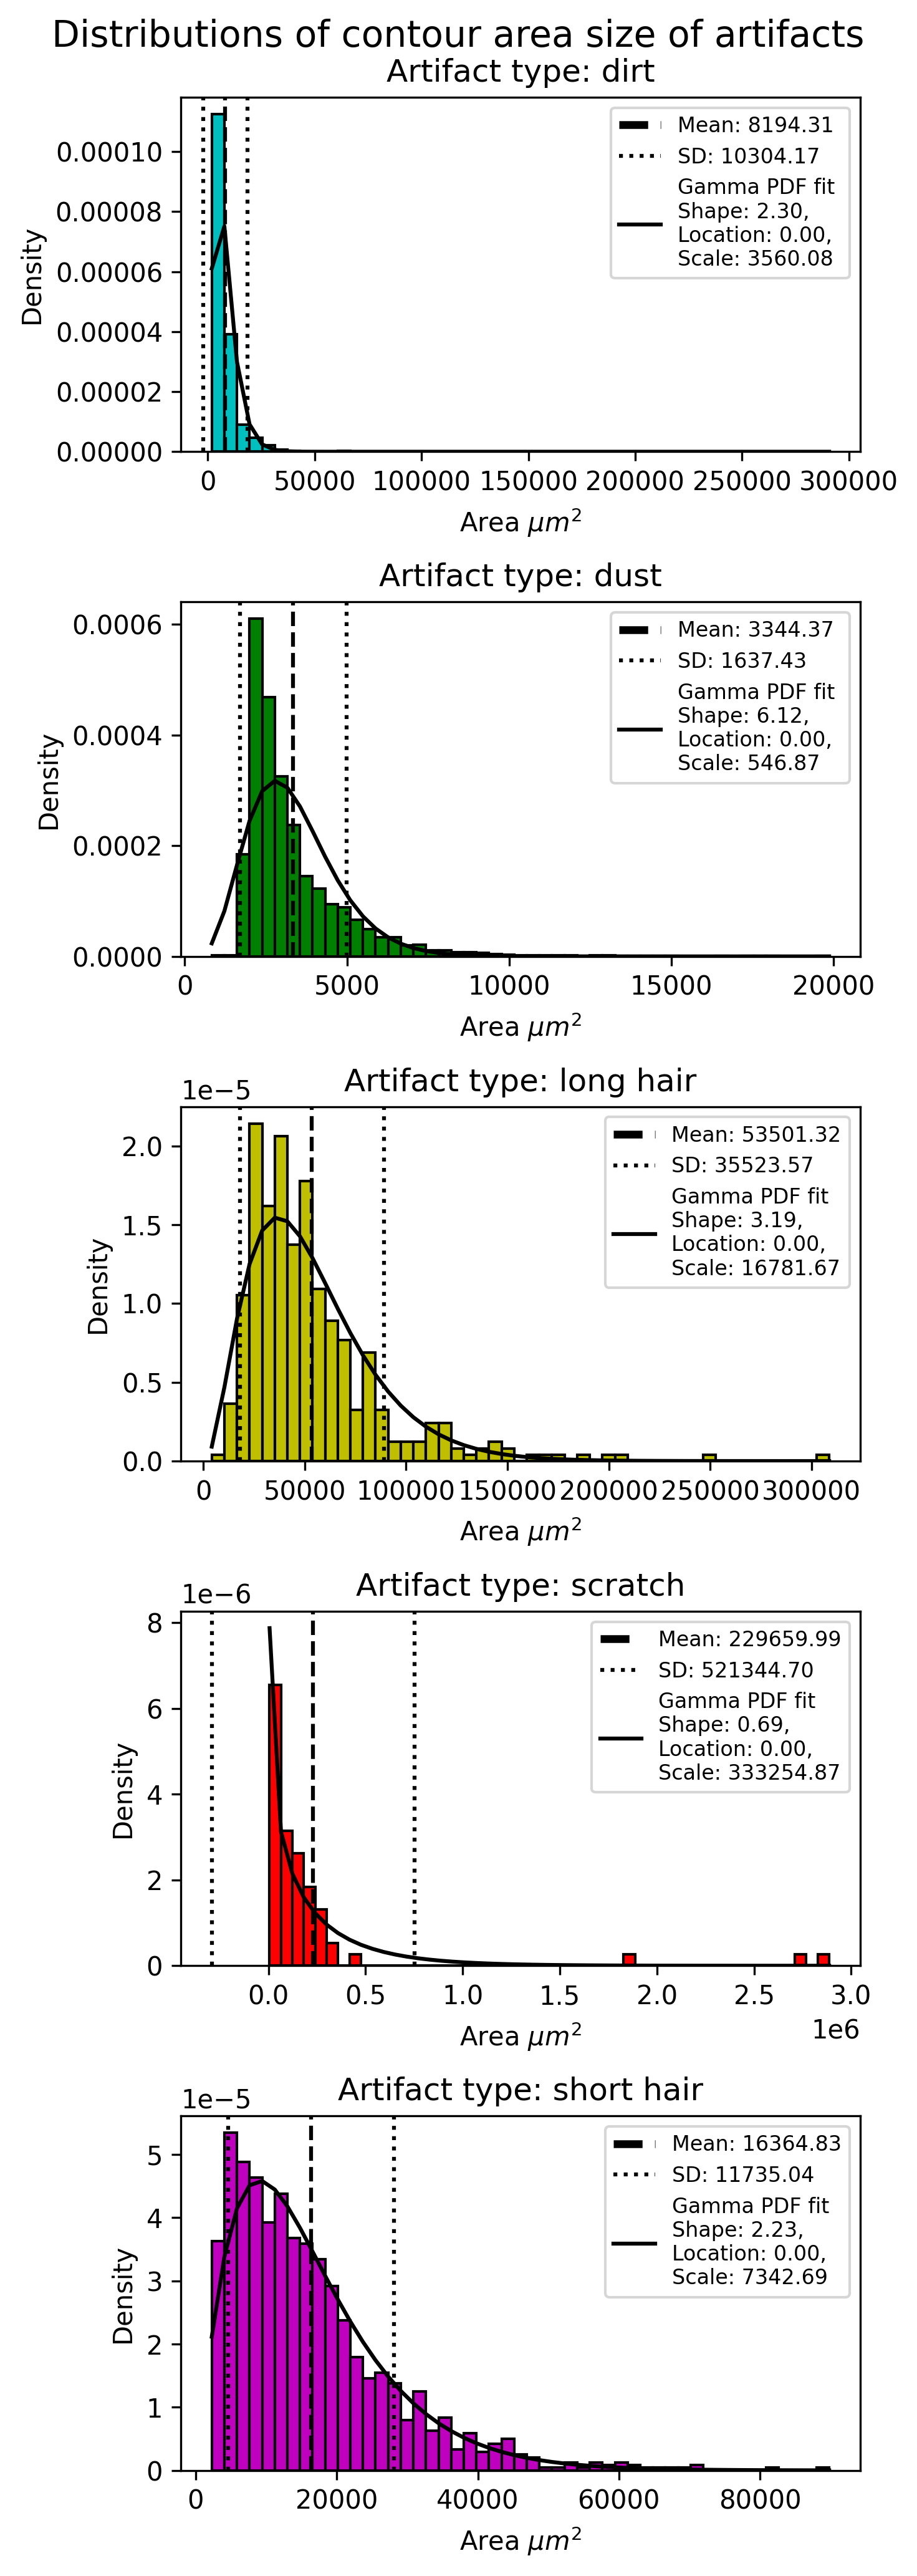

In [ ]:
gamma_params = plot_artifact_prop(df_artifacts, 'Contour Area (sq micron)', 
                   'Distributions of contour area size of artifacts', 
                   'Artifact type:', 
                   'Area $\mu$$m^2$', 
                   logx=False, 
                   logy=False,
                   colours=['c', 'g', 'y', 'r', 'm'],
                   fit_distrib=True)

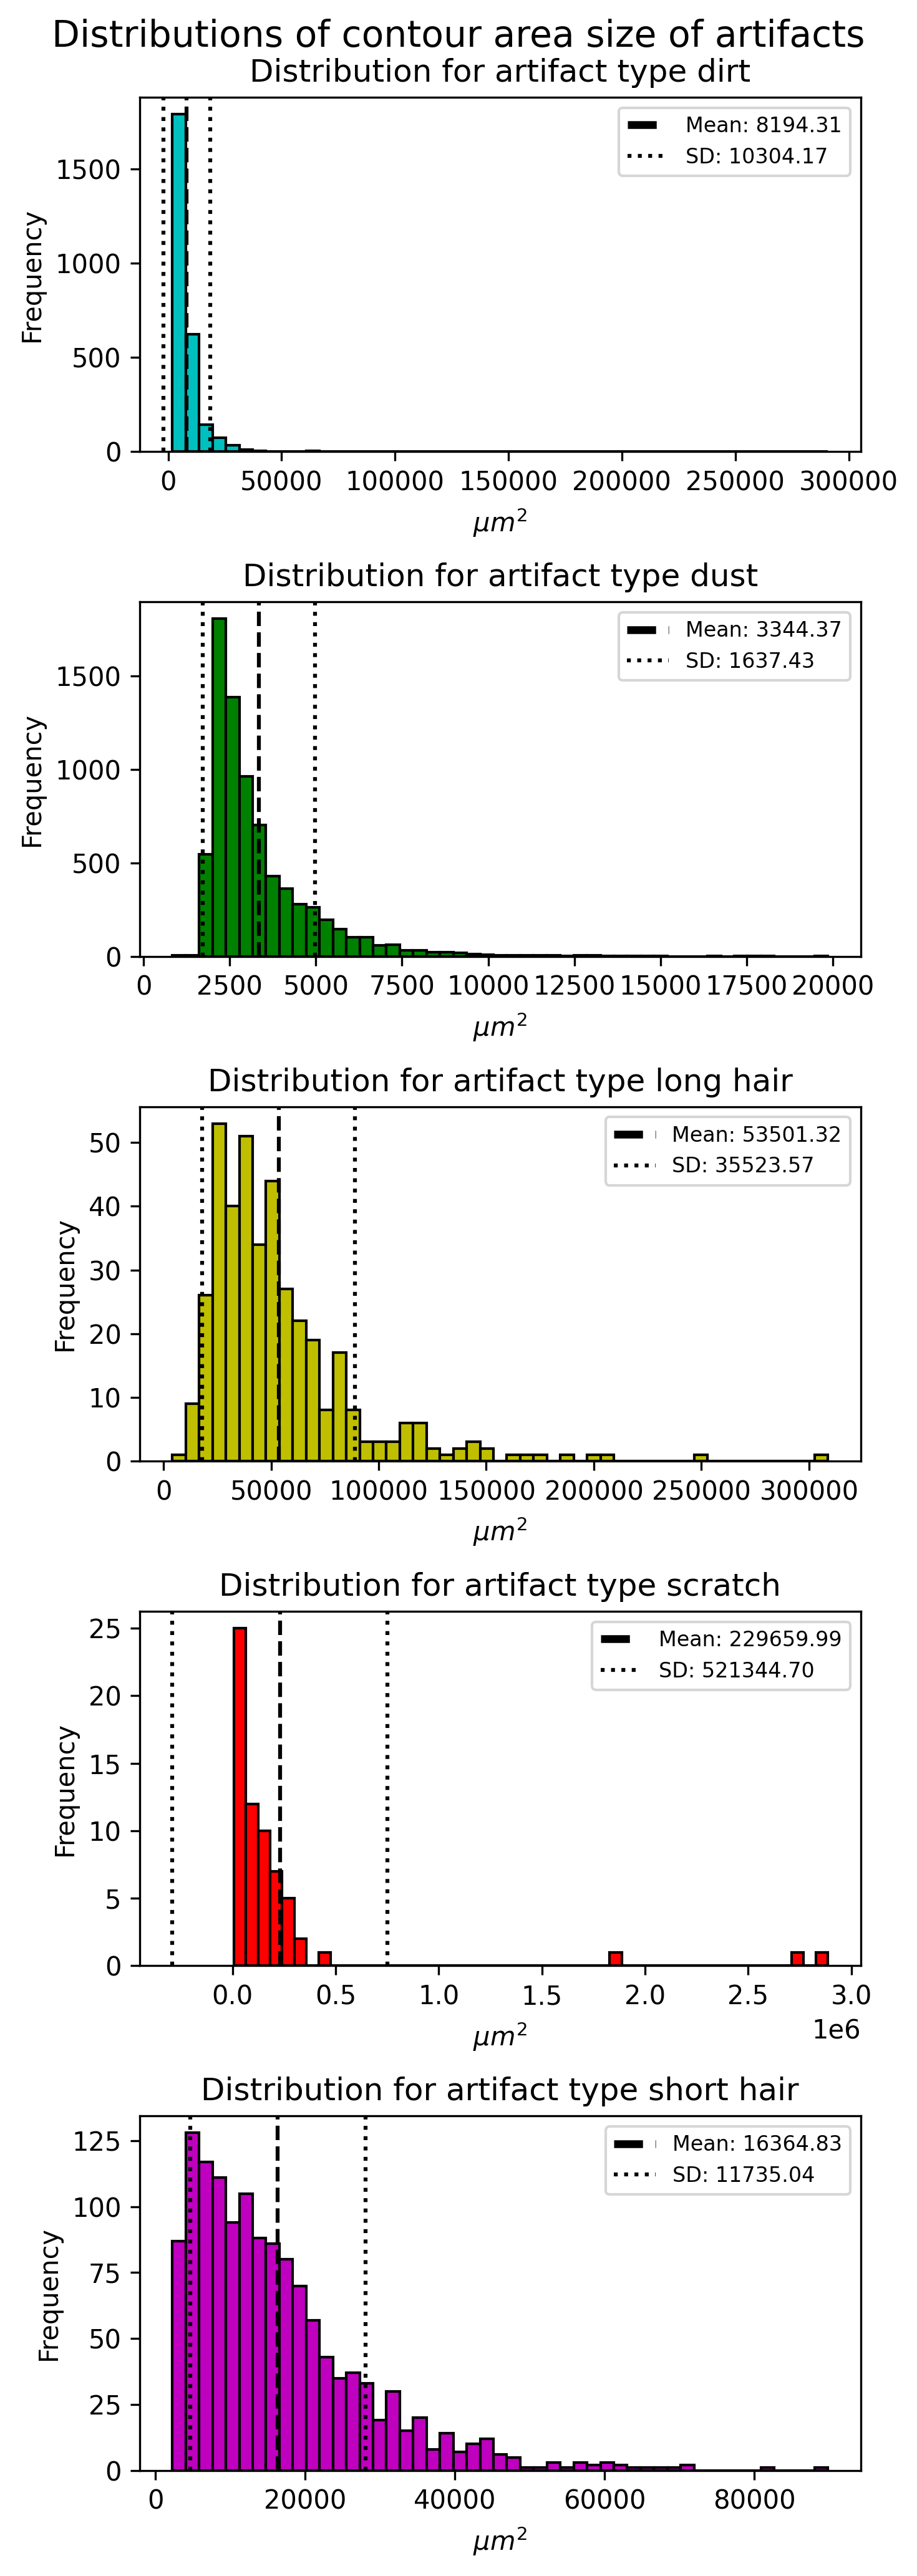

In [ ]:
gamma_params = plot_artifact_prop(df_artifacts, 'Contour Area (sq micron)', 
                   'Distributions of contour area size of artifacts', 
                   'Distribution for artifact type', 
                   '$\mu$$m^2$', 
                   logx=False, 
                   logy=False,
                   colours=['c', 'g', 'y', 'r', 'm'],
                   fit_distrib=False)

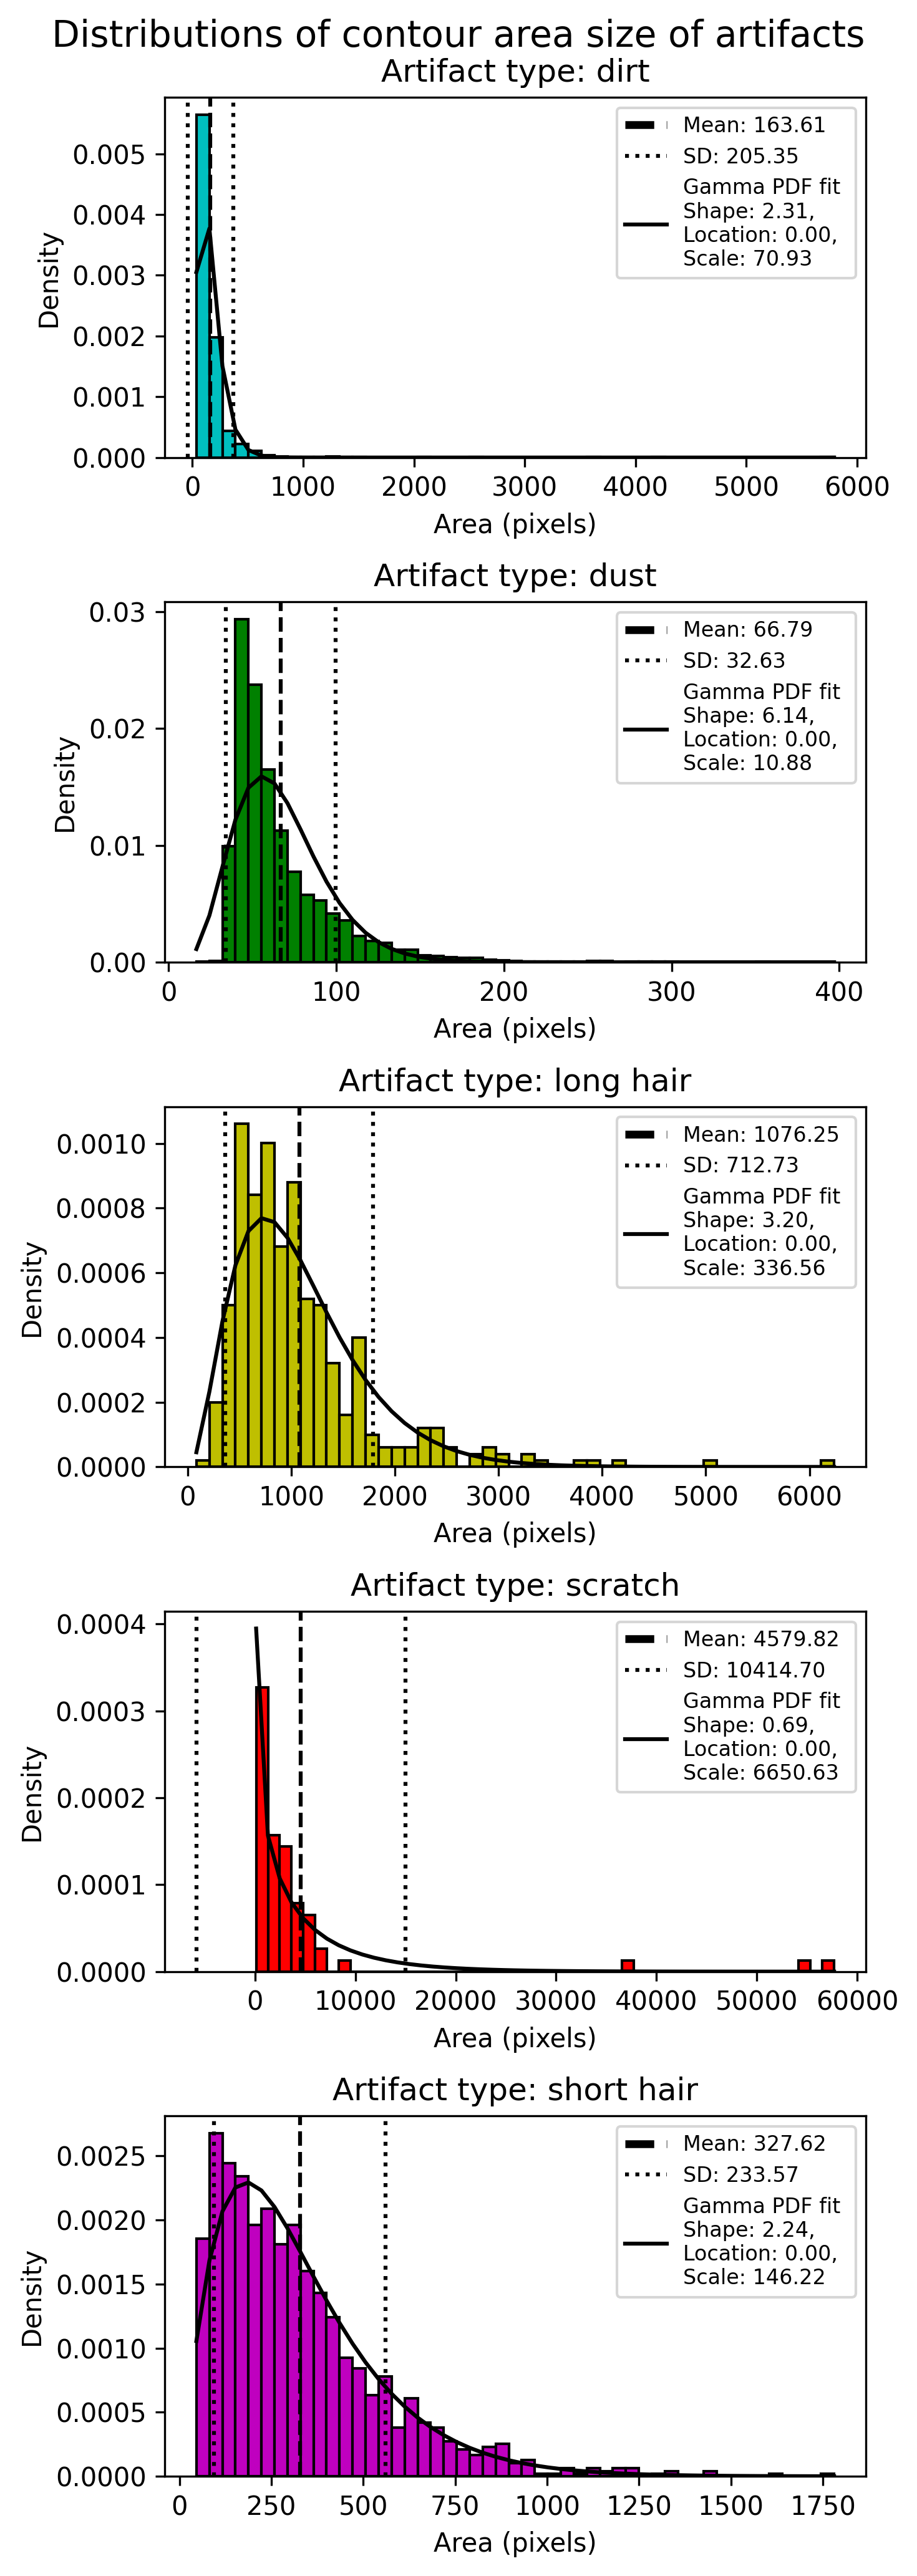

In [ ]:
gamma_params = plot_artifact_prop(df_artifacts, 'Contour Area (px)', 
                   'Distributions of contour area size of artifacts', 
                   'Artifact type:', 
                   'Area (pixels)', 
                   logx=False, 
                   logy=False,
                   colours=['c', 'g', 'y', 'r', 'm'],
                   fit_distrib=True)

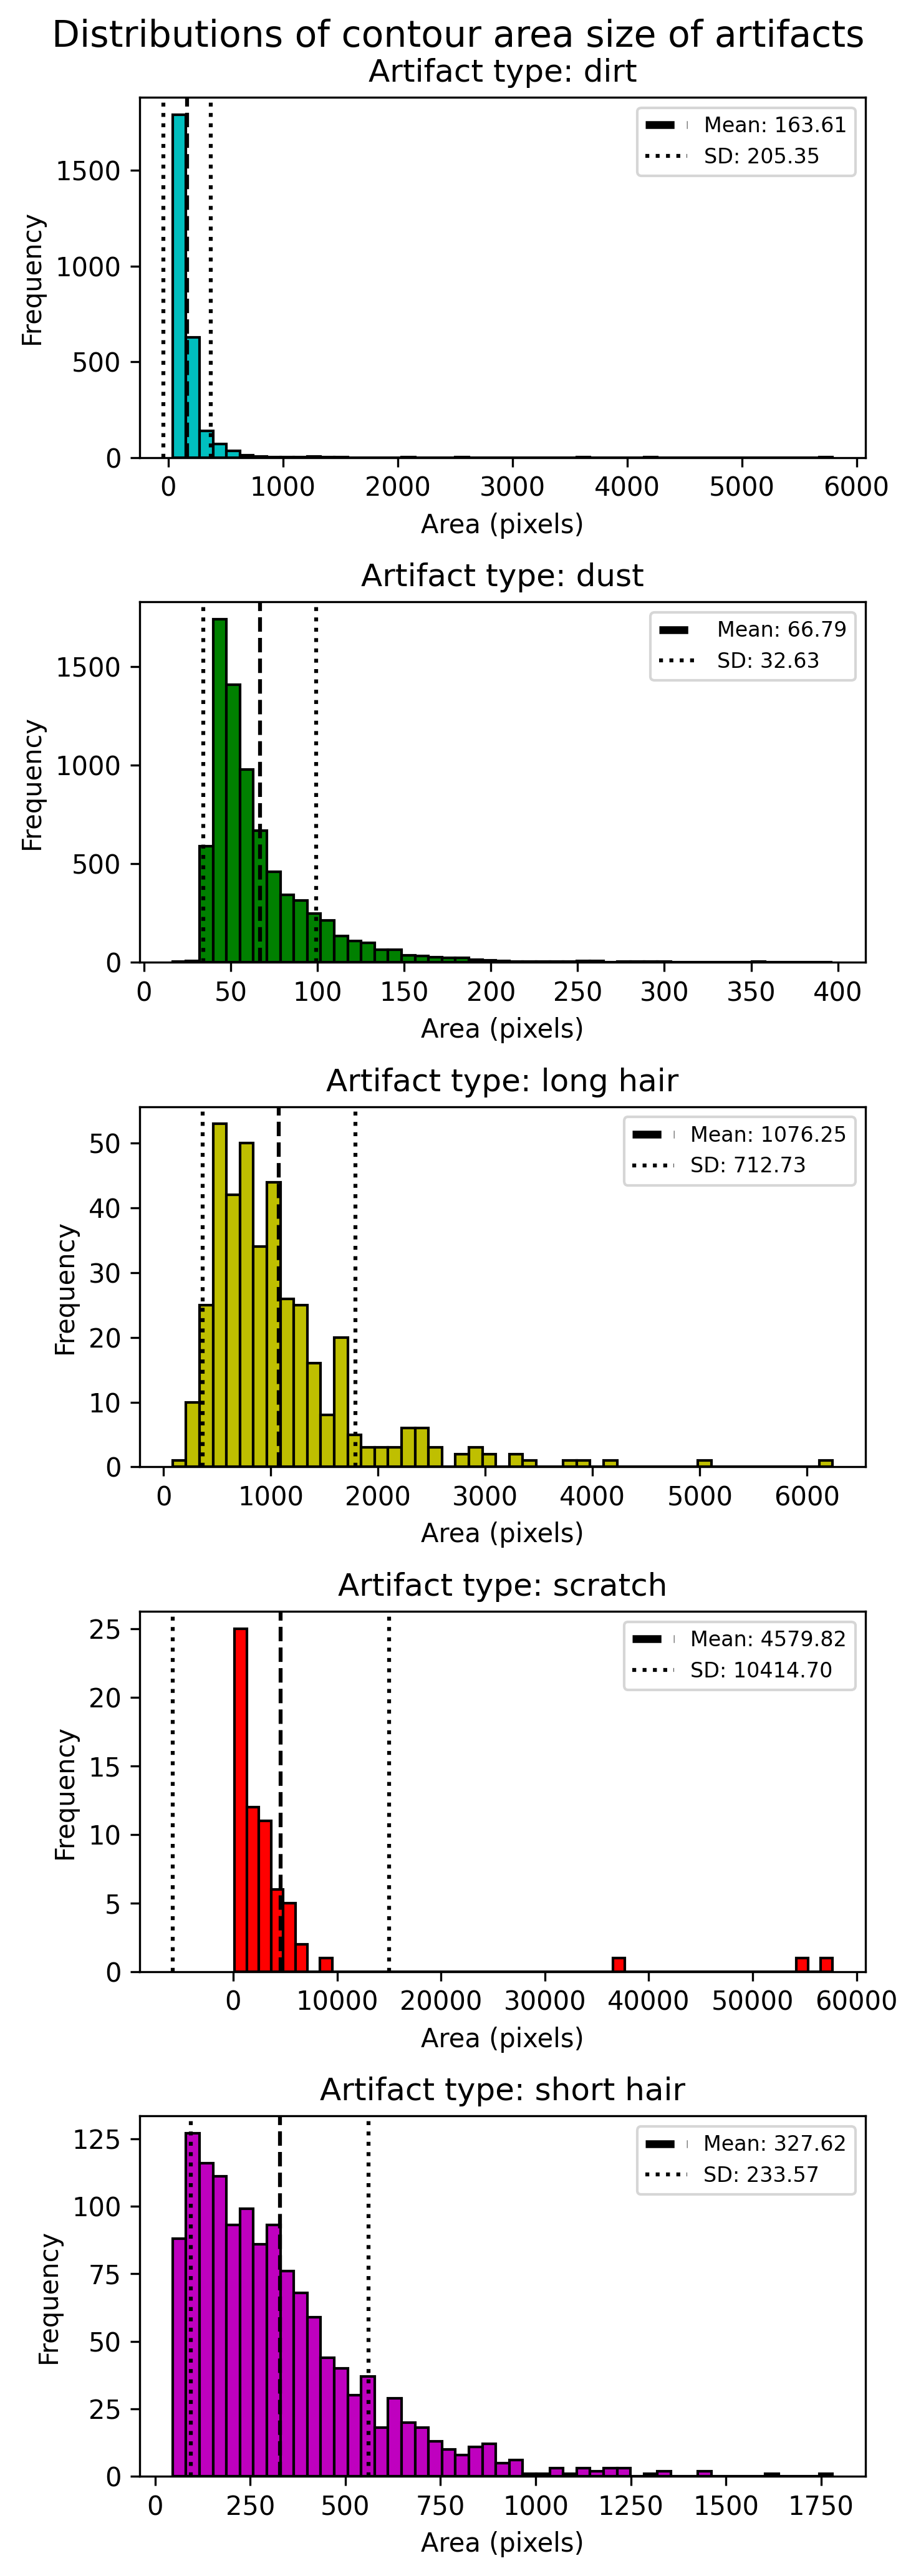

In [ ]:
gamma_params = plot_artifact_prop(df_artifacts, 'Contour Area (px)', 
                   'Distributions of contour area size of artifacts', 
                   'Artifact type:', 
                   'Area (pixels)', 
                   logx=False, 
                   logy=False,
                   colours=['c', 'g', 'y', 'r', 'm'],
                   fit_distrib=False)

In [ ]:
gamma_params

{'dirt': (2.30658026070733, 0, 70.93281123113805),
 'dust': (6.136948611591026, 0, 10.883419166566702),
 'long hair': (3.1978294154702547, 0, 336.55641379536587),
 'scratch': (0.6886303081154035, 0, 6650.626646766135),
 'short hair': (2.2406121407811614, 0, 146.21849767114065)}

In [ ]:
def plot_artifacts(df, num_rows, num_cols, title):
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4), dpi=300)
    df_elements = df.sample(n=num_rows*num_cols, ignore_index=True)

    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(df_elements.iloc[i]['Padded Artifact'], cmap='gray')
        plt.title('{0:.2f}'.format(df_elements.iloc[i]['Contour Area (sq micron)']))
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('{} {}'.format(title, r'(area in $\mu$$m^2$)'), fontsize=16)
    
    plt.show()

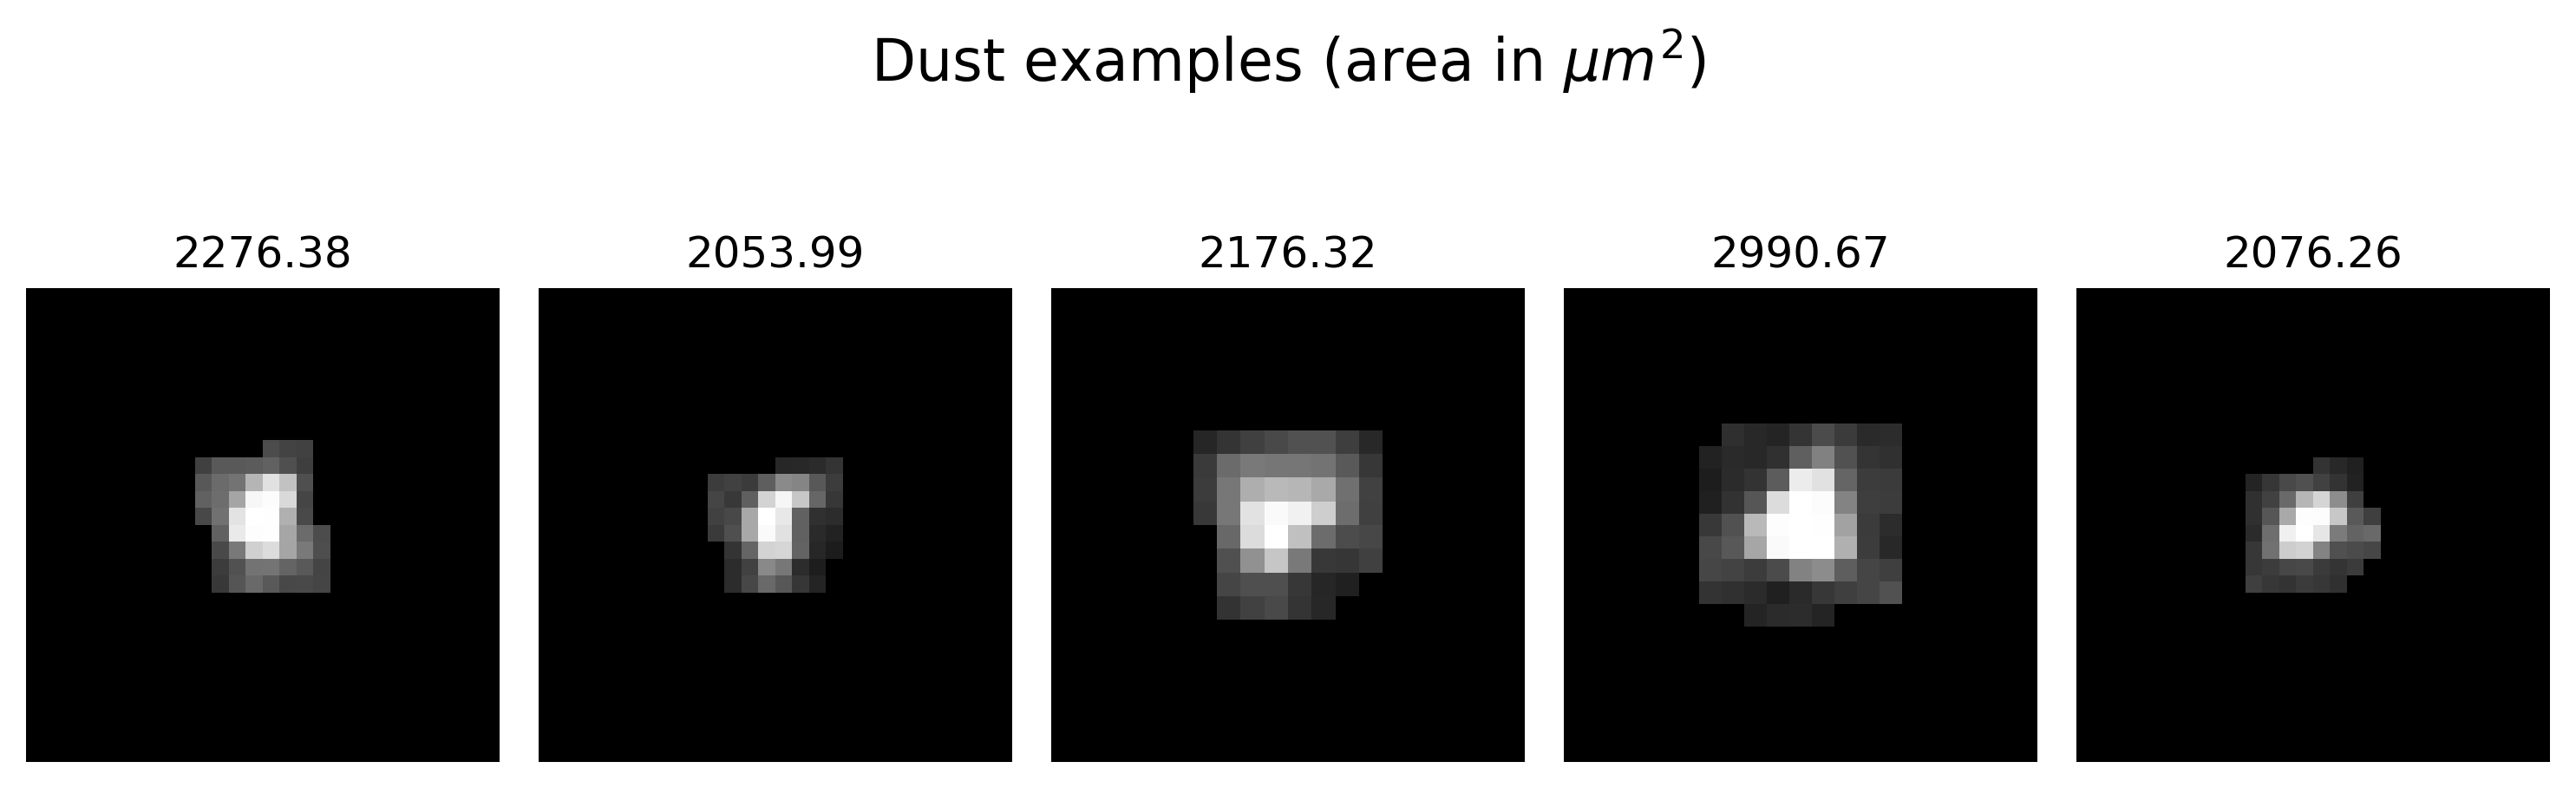

In [ ]:
plot_artifacts(df_artifacts.loc[df_artifacts['Type'] == 'dust'], 1, 5, 'Dust examples')

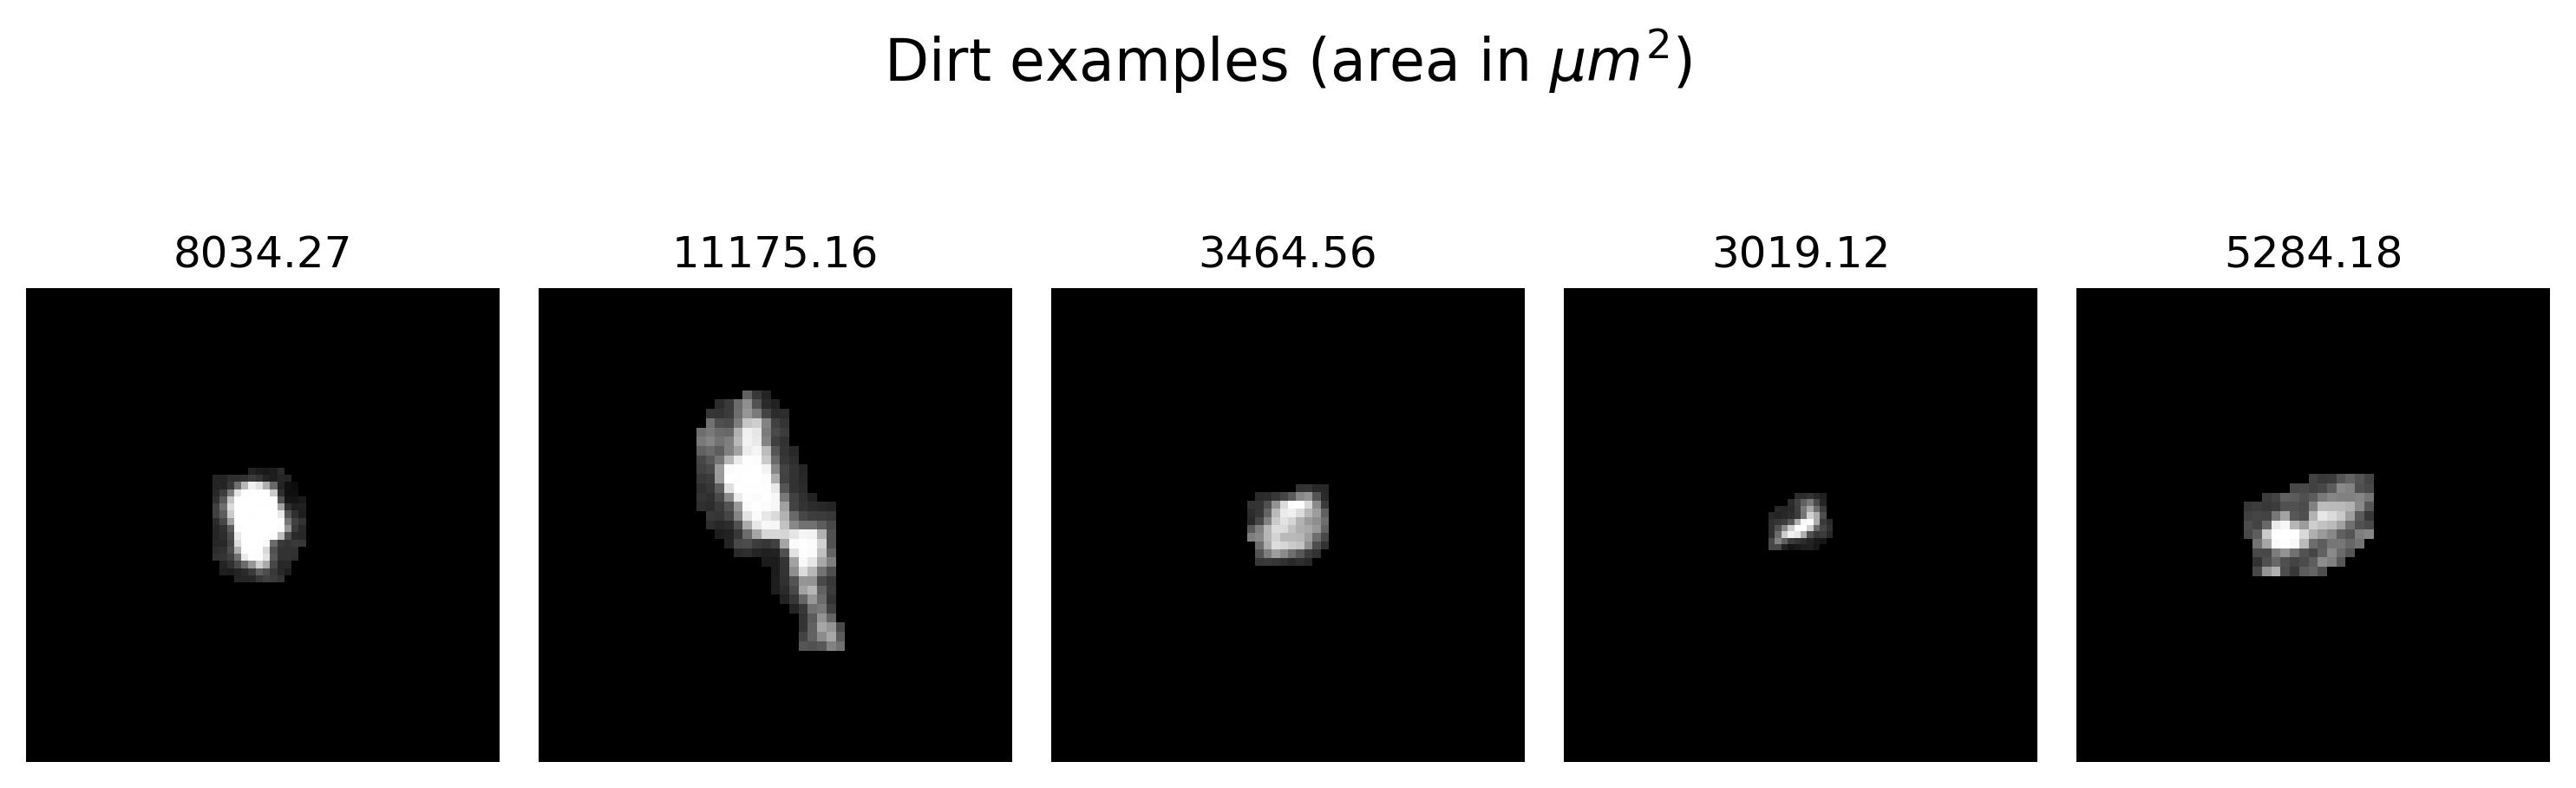

In [ ]:
plot_artifacts(df_artifacts.loc[df_artifacts['Type'] == 'dirt'], 1, 5, 'Dirt examples')

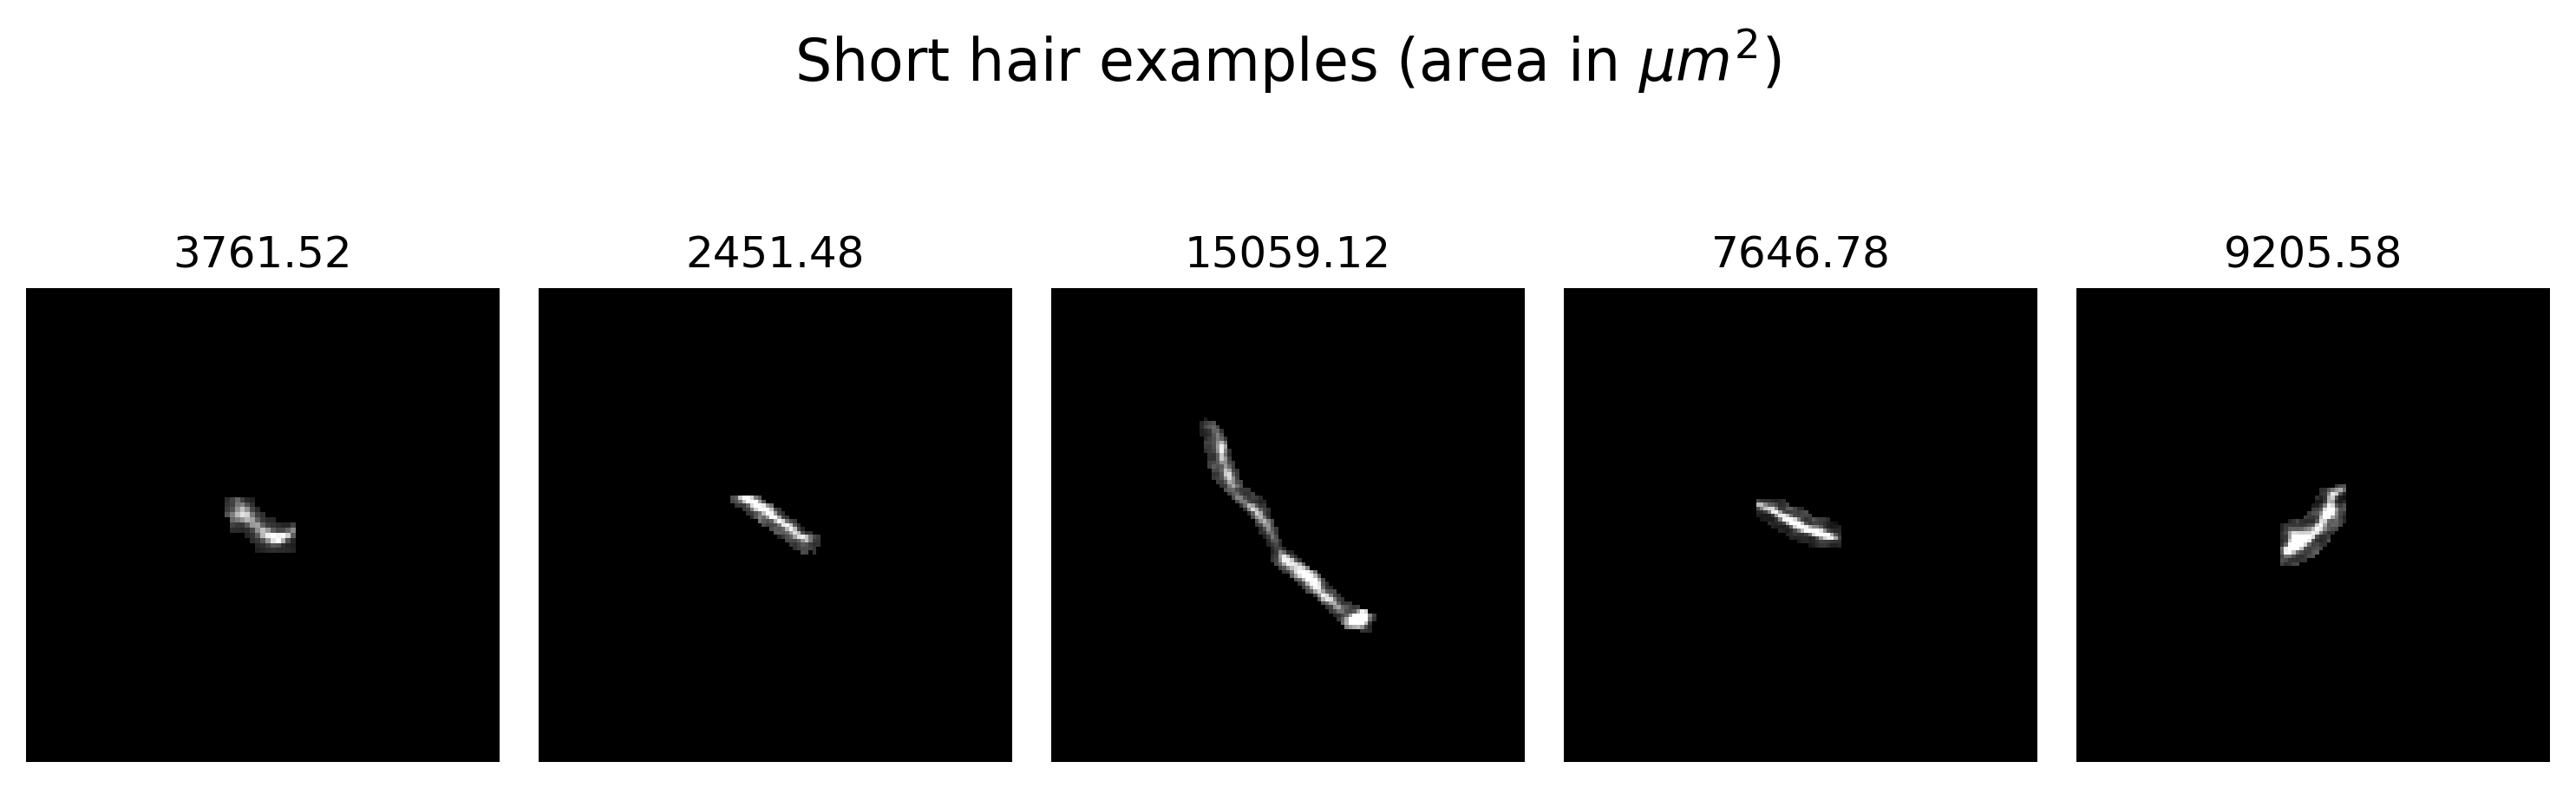

In [ ]:
plot_artifacts(df_artifacts.loc[df_artifacts['Type'] == 'short hair'], 1, 5, 'Short hair examples')

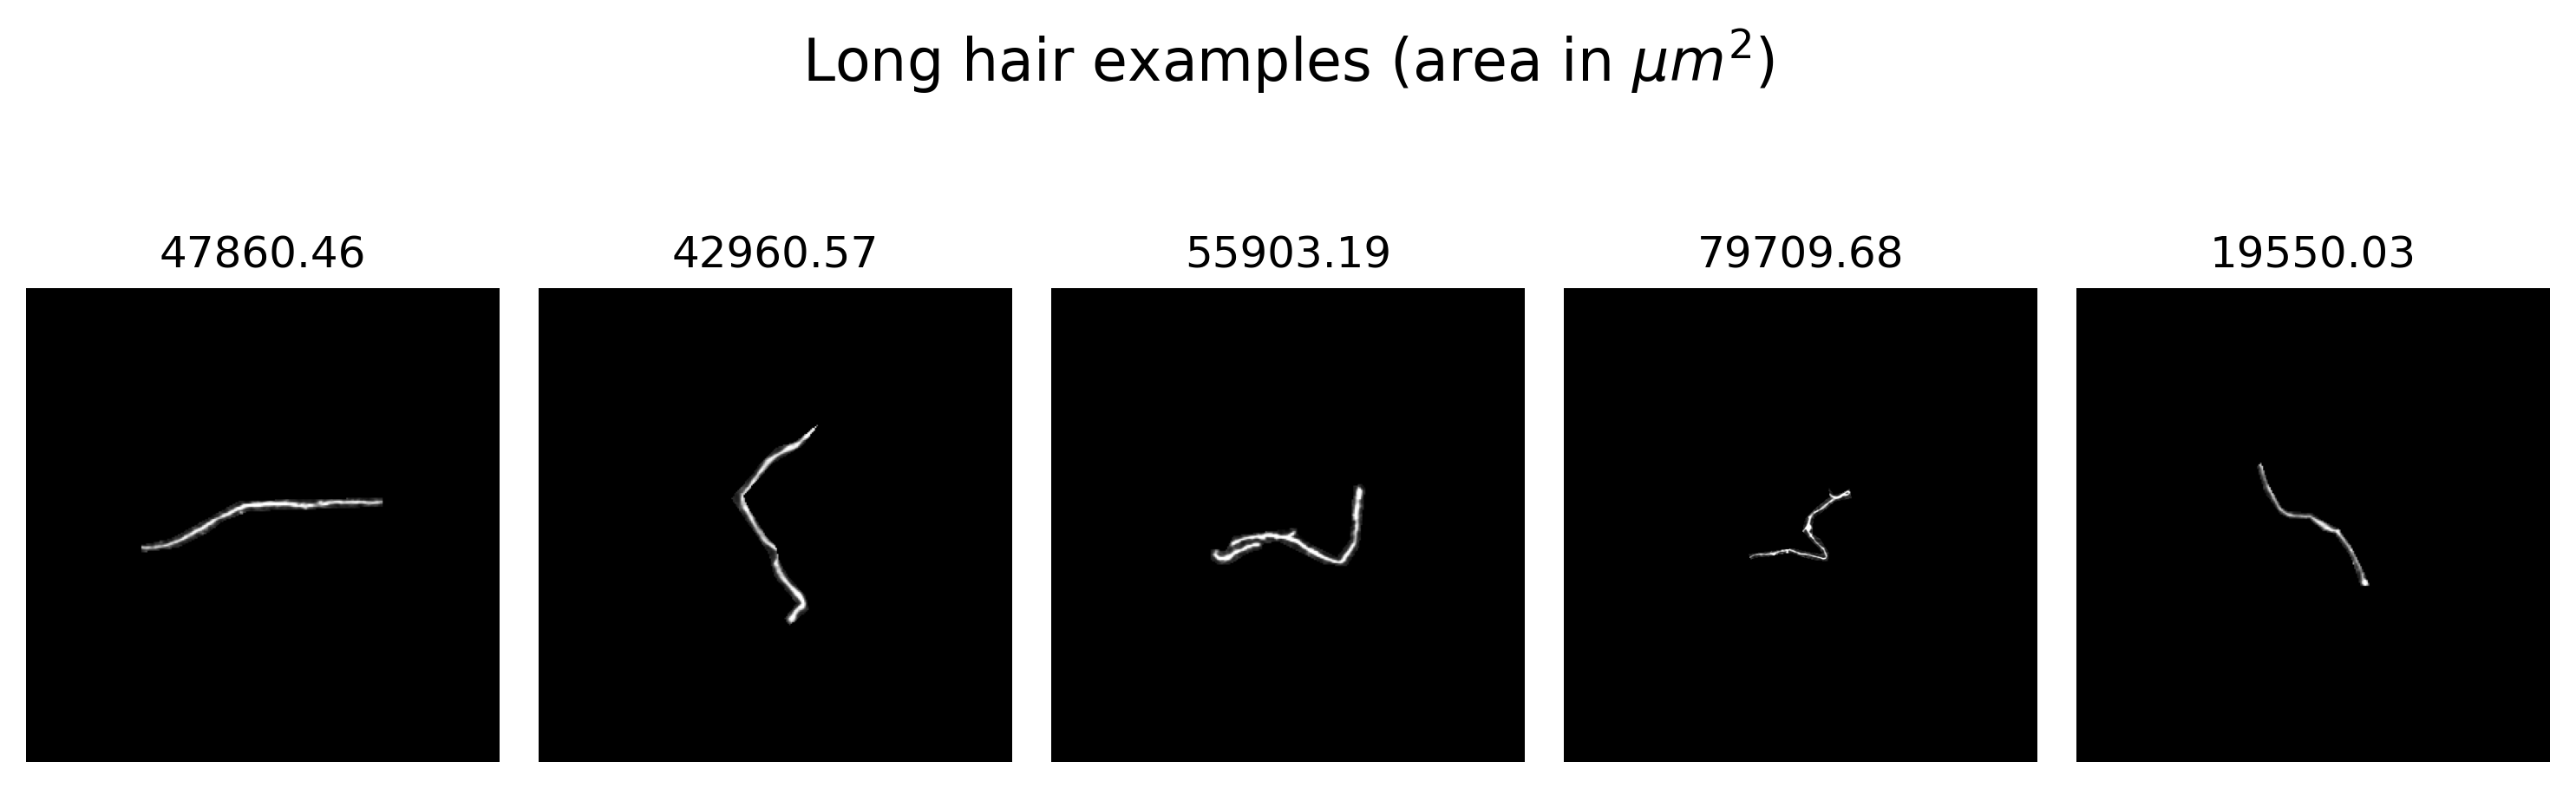

In [ ]:
plot_artifacts(df_artifacts.loc[df_artifacts['Type'] == 'long hair'], 1, 5, 'Long hair examples')

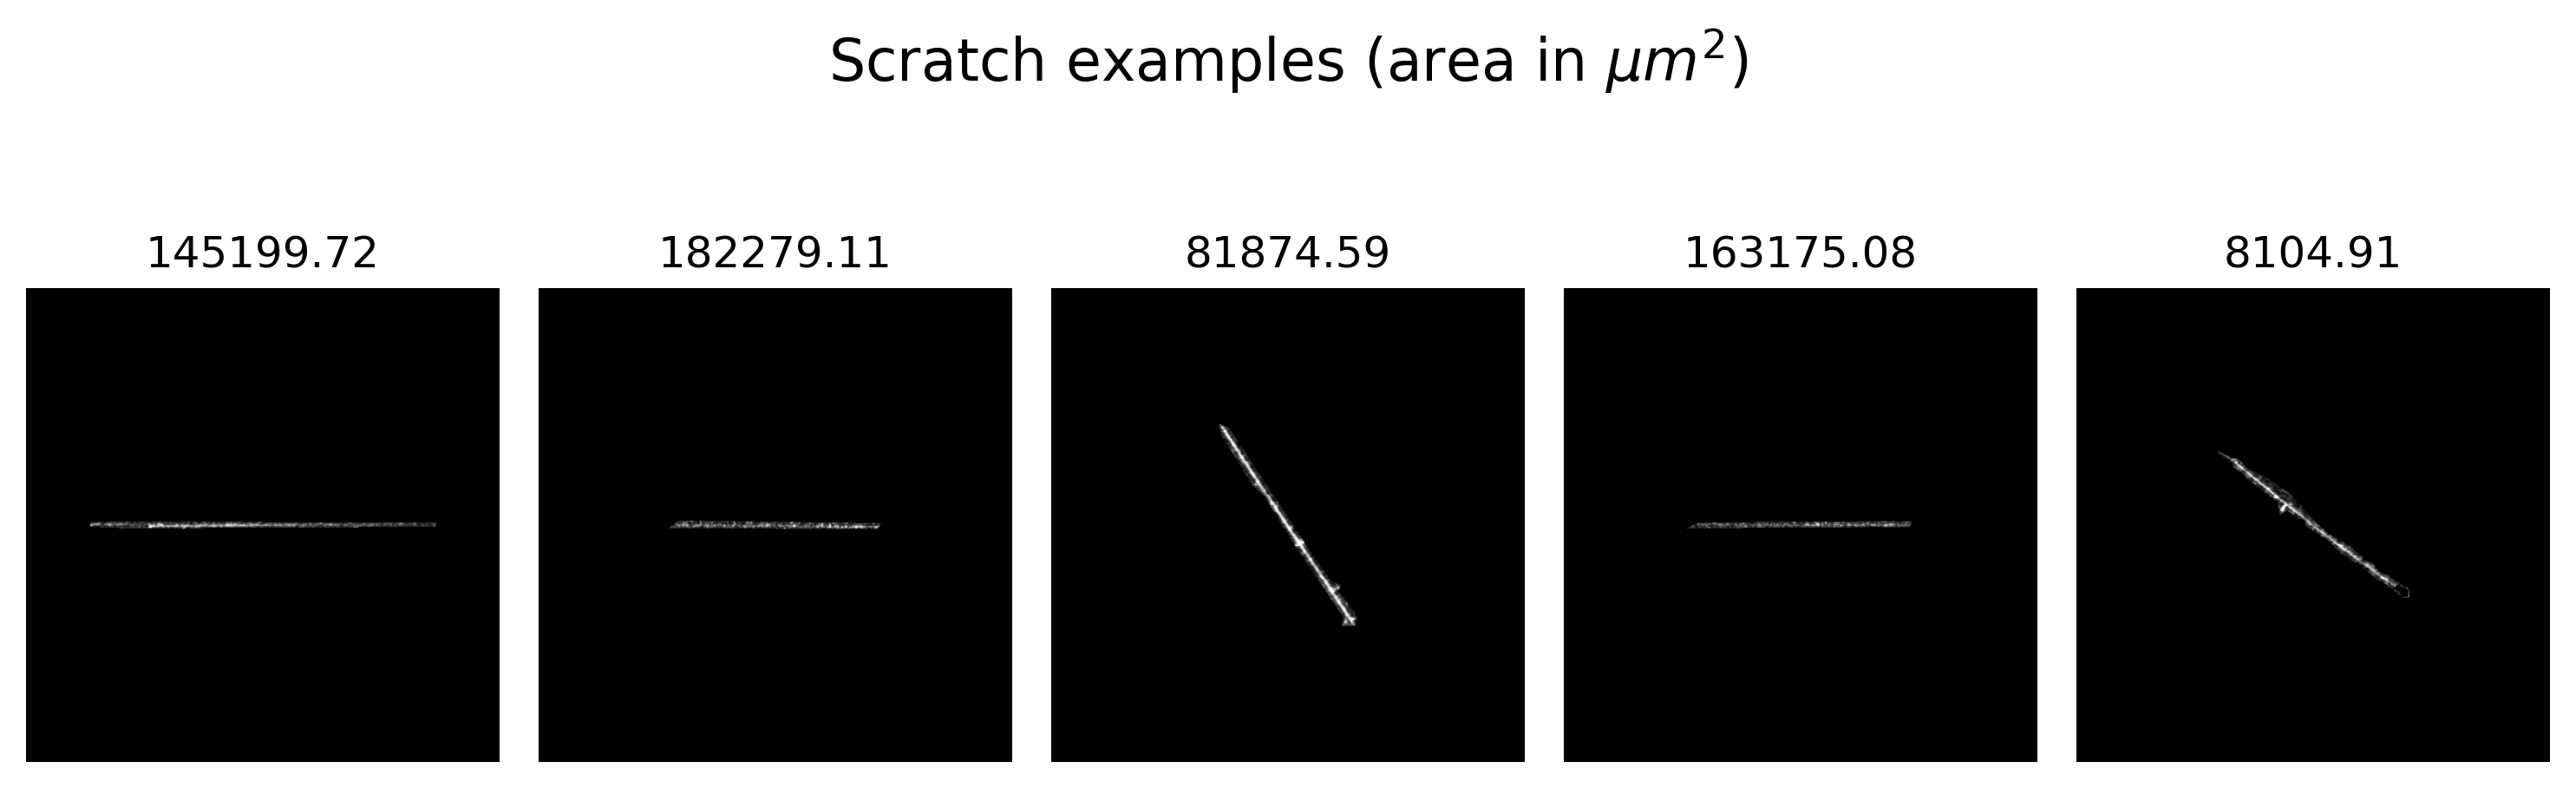

In [ ]:
plot_artifacts(df_artifacts.loc[df_artifacts['Type'] == 'scratch'], 1, 5, 'Scratch examples')

### Artifact distributions

In [ ]:
df_artifacts.groupby(['Type']).size()

Type
dirt          2700
dust          7631
long hair      398
scratch         65
short hair    1341
dtype: int64

In [ ]:
df_artifacts.groupby(['Scan','Type']).size()

Scan       Type      
Scan (1)   dirt           401
           dust           868
           long hair      122
           scratch          1
           short hair     386
Scan (10)  dirt            23
           dust            33
           long hair        2
           short hair      19
Scan (2)   dirt           394
           dust           923
           long hair      172
           short hair     328
Scan (3)   dirt           186
           dust          1278
           long hair        8
           scratch          6
           short hair      76
Scan (4)   dirt           477
           dust           841
           long hair       15
           scratch          3
           short hair     130
Scan (5)   dirt           115
           dust          1118
           long hair       47
           scratch         16
           short hair      85
Scan (6)   dirt           278
           dust           926
           long hair        6
           scratch          6
           short h

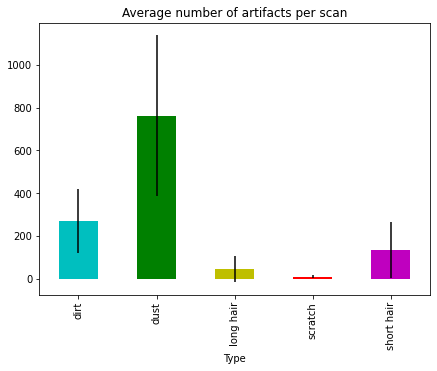

In [ ]:
df_artifacts.groupby(['Scan','Type']).size().groupby(level=1).mean().plot(
    kind='bar',
    yerr=df_artifacts.groupby(['Scan','Type']).size().groupby(level=1).std(),
    #logy=True,
    title='Average number of artifacts per scan',
    color=['c', 'g', 'y', 'r', 'm'],
    figsize=(7,5)
    )

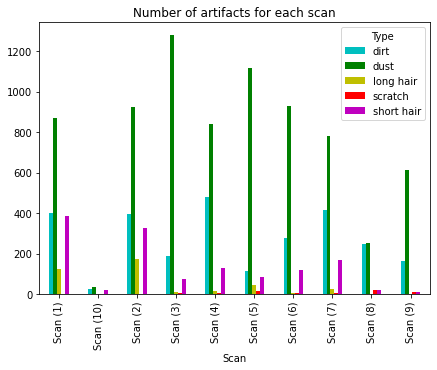

In [ ]:
pd.crosstab(df_artifacts['Scan'], df_artifacts['Type']).plot.bar(
    color=['c', 'g', 'y', 'r', 'm'],
    title='Number of artifacts for each scan',
    figsize=(7,5)
)

In [ ]:
df_per_patch_counts = df_artifacts.groupby(['Quandrant', 'Type']).size().to_frame('Counts').reset_index()

In [ ]:
df_per_patch_counts

Quandrant        Type  Counts
0       (0, 0)        dirt      19
1       (0, 0)        dust      60
2       (0, 0)  short hair       5
3       (0, 1)        dirt      30
4       (0, 1)        dust      46
...        ...         ...     ...
1077  (13, 17)        dust       7
1078  (13, 18)        dirt       2
1079  (13, 18)        dust       4
1080  (13, 18)  short hair       1
1081  (13, 19)        dust       4

[1082 rows x 3 columns]

In [ ]:
df_per_patch_counts.loc[df_per_patch_counts['Type'] == 'dust'].min()

Quandrant    (0, 0)
Type           dust
Counts            3
dtype: object

In [ ]:
df_per_patch_counts.loc[df_per_patch_counts['Type'] == 'scratch'].max()

Quandrant    (13, 15)
Type          scratch
Counts              2
dtype: object

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_quadrant_counts(df, col_name, title, subtitle, xaxis_label, colours=[], fit_distrib=False):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,14),  dpi=300, facecolor='w')
    fig.suptitle(title, fontsize=14)

    gamma_params = {}

    # Generate histogram subplots
    for i, (ax, (name, subdf)) in enumerate(zip(axes.flatten(), df.groupby('Type'))):
        min = subdf[col_name].min()
        max = subdf[col_name].max()
        hist, bins = np.histogram(subdf[col_name])
        ax.hist(subdf[col_name], bins = np.linspace(0, max), edgecolor='k', color=colours[i], density=fit_distrib)
        #ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), edgecolor='k', color=colours[i])

        mean = subdf[col_name].mean()
        std = subdf[col_name].std()

        x = np.linspace(0, max)

        gamma = stats.gamma
        
        gamma_param = gamma.fit(subdf[col_name], floc=0)
        pdf_fitted = gamma.pdf(x, *gamma_param)

        gamma_params[name] = gamma_param
        
        if fit_distrib:
            ax.plot(x, pdf_fitted, color='k')

        ax.axvline(mean, color='k', linestyle='dashed')
        ax.axvline(mean - std, color='k', linestyle='dotted')
        ax.axvline(mean + std, color='k', linestyle='dotted')

        ax.set_xlabel(xaxis_label)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        if fit_distrib:
            ax.set_ylabel('Density')
        else:
            ax.set_ylabel('Frequency')
        ax.title.set_text('{} {}'.format(subtitle, name))
        lines = [
            Line2D([0], [0], color='k', linewidth=3, linestyle='dashed'), 
            Line2D([0], [0], color='k', linestyle='dotted'),
            ]
        labels = [
            'Mean: {:.2f}'.format(mean), 
            'SD: {:.2f}'.format(std),
            ]
        if fit_distrib:
            lines.append(
                            Line2D([0], [0], color='k', linestyle='solid'),
            )
            labels.append(
                        'Gamma fit \nShape:{:.2f}, \nLocation:{:.2f}, \nScale:{:.2f}'.format(*gamma_param),
            )

        ax.legend(lines, labels, loc="upper right")

    fig.tight_layout()
    fig.subplots_adjust(top=0.91)

    plt.show()

    return gamma_params

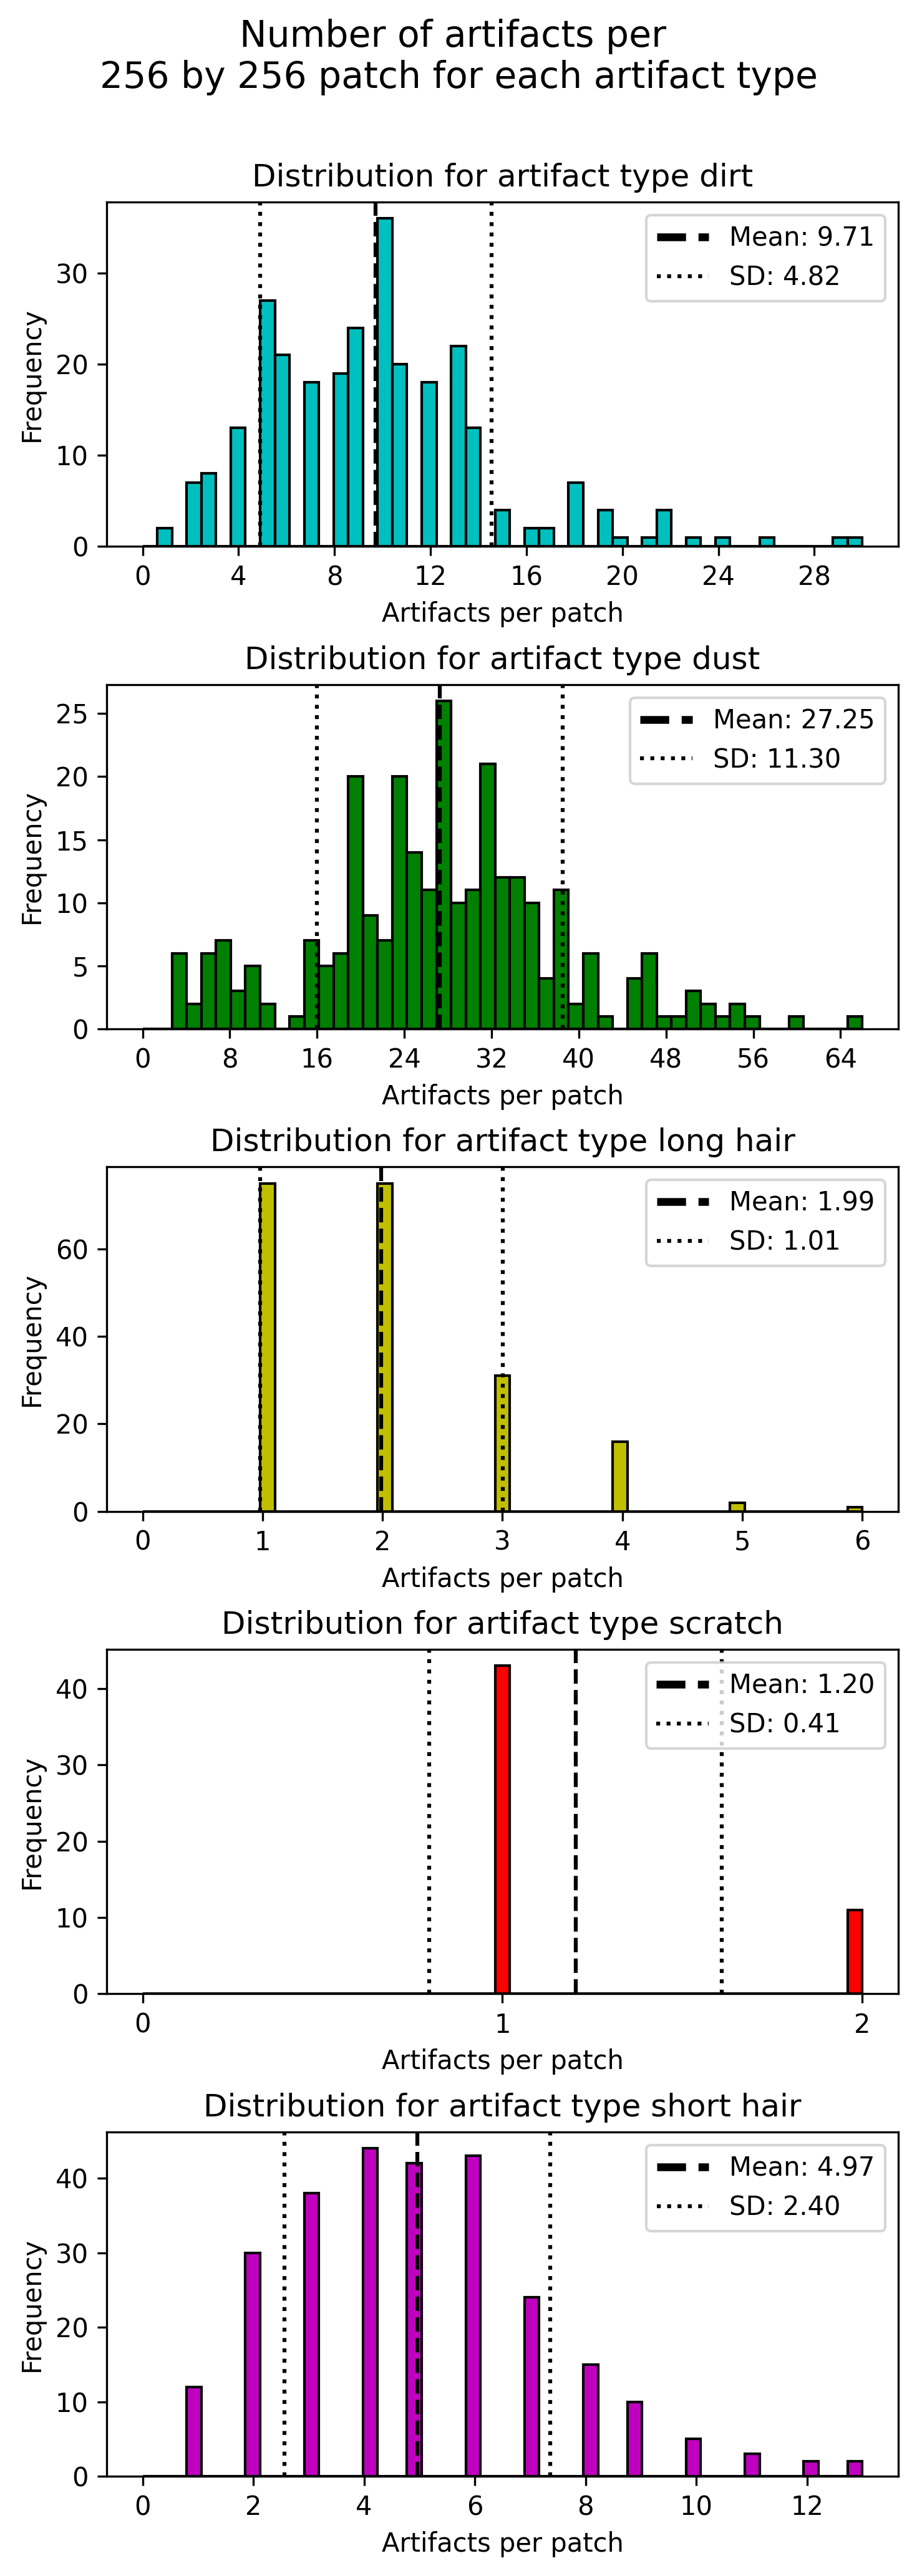

{'dirt': (3.9286190485400083, 0, 2.4721740886117964),
 'dust': (4.383478853757115, 0, 6.2173384058217085),
 'long hair': (4.259170684114018, 0, 0.4672271077142697),
 'scratch': (11.474692572384056, 0, 0.10490073665246916),
 'short hair': (3.9204481720064766, 0, 1.2668619629078626)}

In [ ]:
plot_quadrant_counts(df_per_patch_counts, 'Counts', 
                   'Number of artifacts per \n256 by 256 patch for each artifact type', 
                   'Distribution for artifact type', 
                   'Artifacts per patch', 
                   colours=['c', 'g', 'y', 'r', 'm'])

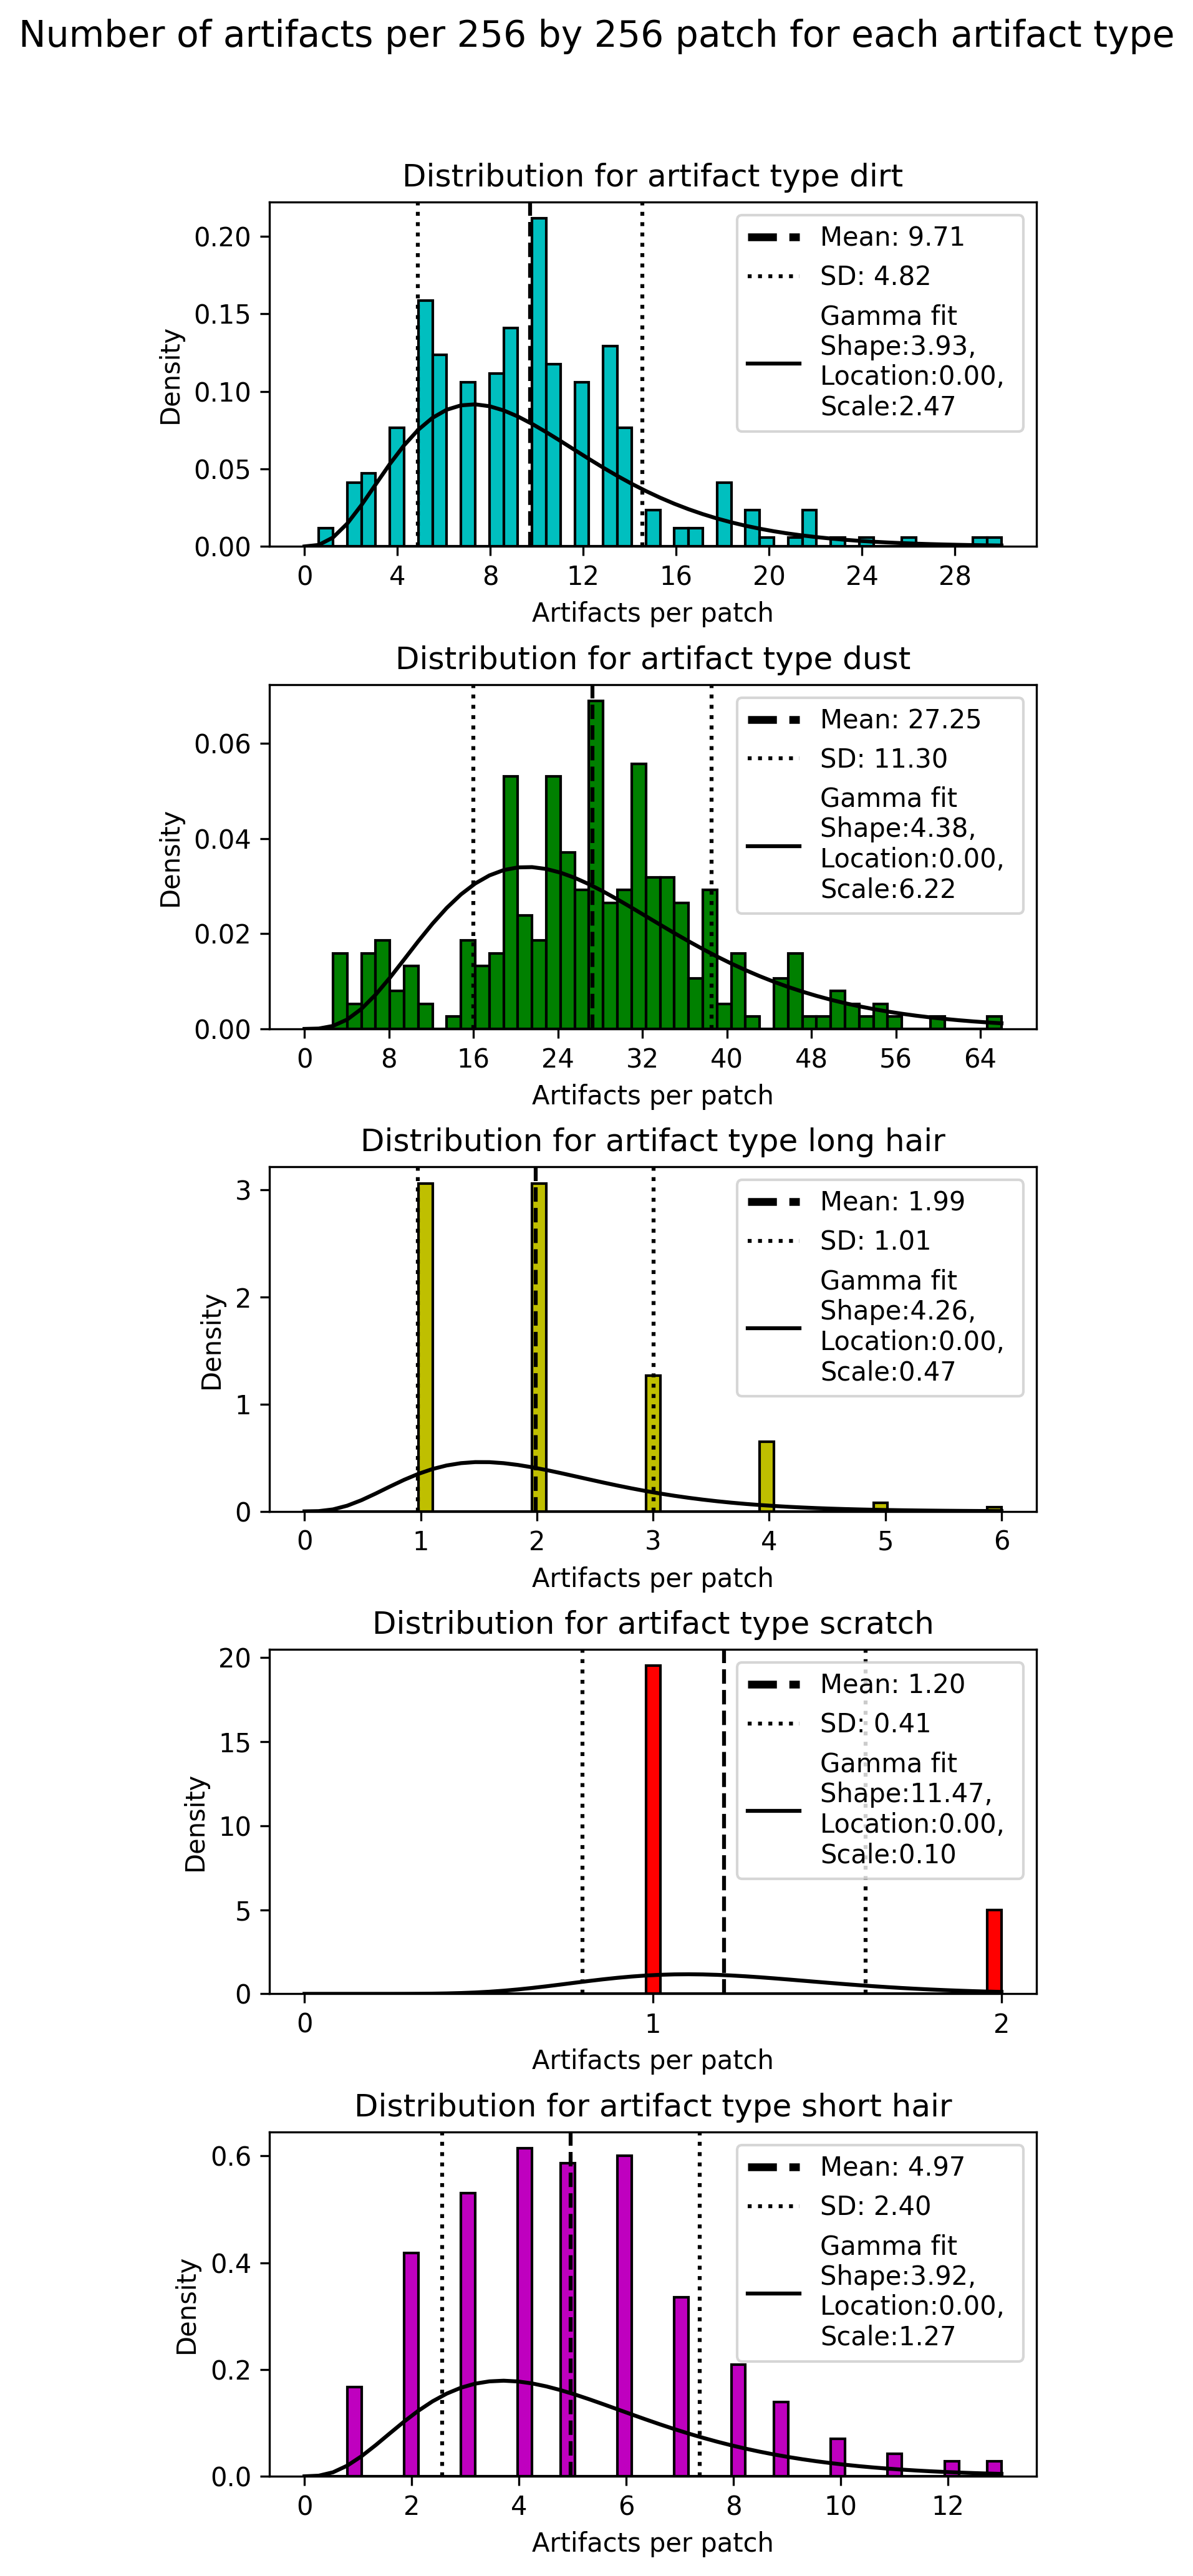

{'dirt': (3.9286190485400083, 0, 2.4721740886117964),
 'dust': (4.383478853757115, 0, 6.2173384058217085),
 'long hair': (4.259170684114018, 0, 0.4672271077142697),
 'scratch': (11.474692572384056, 0, 0.10490073665246916),
 'short hair': (3.9204481720064766, 0, 1.2668619629078626)}

In [ ]:
plot_quadrant_counts(df_per_patch_counts, 'Counts', 
                   'Number of artifacts per 256 by 256 patch for each artifact type', 
                   'Distribution for artifact type', 
                   'Artifacts per patch', 
                   colours=['c', 'g', 'y', 'r', 'm'],
                   fit_distrib=True)

###Visualisation

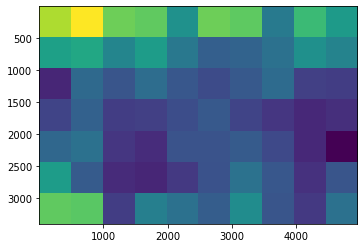

In [ ]:
heatmap, xedges, yedges = np.histogram2d(
    df_artifacts.loc[df_artifacts['Type'] == 'dust']['centroid x'], 
    df_artifacts.loc[df_artifacts['Type'] == 'dust']['centroid y'], 
    bins=(10, 7))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return matplotlib.colors.ListedColormap(color_list, cmap_name, N)

In [ ]:
def plot_quadrant_distrib(df, title, subtitle, xaxis_label, yaxislabel, cmap=''):
    #fig, axes = plt.subplots(nrows=df['Scan'].nunique()+1, ncols=1, figsize=(42,60), dpi=300, facecolor='w')
    fig, axes = plt.subplots(nrows=1, ncols=1, facecolor='w', dpi=300)
    # 3584, 5120
    # Generate 2d histogram subplots
    # for i, (ax, (name, subdf)) in enumerate(zip(axes.flatten(), df.groupby('Scan'))):
    #     base_img = cv.cvtColor(cv.imread(scans_path+name+'.jpg'), cv.COLOR_BGR2GRAY)
    #     base_img = cv.copyMakeBorder(base_img, 0, 3584-base_img.shape[0], 0, 
    #                                  5120-base_img.shape[1], cv.BORDER_CONSTANT, 0)
        
    #     heatmap, xedges, yedges = np.histogram2d(
    #     subdf['centroid x'], 
    #     subdf['centroid y'], 
    #     bins=(20, 14),
    #     range=[[0, 5120], [0, 3584]])
    #     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #     im = ax.imshow(heatmap.T, extent=extent, origin='lower')

    #     im.set_cmap(cmap=discrete_cmap(int(heatmap.max())+1, cmap))
    #     cbar = fig.colorbar(im, ax=ax, ticks=range(int(heatmap.max())+1), pad=0.01)
    #     tick_locs = (np.arange(int(heatmap.max())+1) + 0.5)*(int(heatmap.max())-1)/int(heatmap.max())
    #     cbar.set_ticks(tick_locs)
    #     cbar.set_ticklabels(np.arange(int(heatmap.max())+1))

    #     cbar.set_label('Number of artifacts')
    #     ax.invert_yaxis()
    #     im = ax.imshow(base_img, alpha = 0.5)
    #     ax.set_xlabel(xaxis_label)
    #     ax.set_ylabel(yaxislabel)
    #     ax.title.set_text('{} {}'.format(subtitle, name))

    heatmap, xedges, yedges = np.histogram2d(
    df['centroid x'], 
    df['centroid y'], 
    bins=(20, 14),
    range=[[0, 5120], [0, 3584]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axes.imshow(heatmap.T, extent=extent, origin='lower')
    im.set_cmap(cmap=discrete_cmap(int(heatmap.max())-int(heatmap.min()), cmap))
    cbar = fig.colorbar(im, ax=axes, ticks=range(int(heatmap.min()), int(heatmap.max())+1), fraction=0.046, pad=0.04)
    #cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
    tick_locs = (np.arange(int(heatmap.max())+1) + 0.5)*(int(heatmap.max()))/int(heatmap.max())
    cbar.set_ticks(tick_locs[0::10])
    cbar.set_ticklabels(np.arange(int(heatmap.max())+1)*10)
    cbar.set_label('Number of artifacts')
    axes.set_xlabel(xaxis_label)
    axes.set_ylabel(yaxislabel)
    axes.invert_yaxis()
    axes.title.set_text('{} {}'.format(subtitle, 'all scans, aggregated'))
    
    #plt.gca().invert_yaxis()
    fig.tight_layout()
    #fig.subplots_adjust(top=0.90)
    fig.set_facecolor("white")
    plt.show()

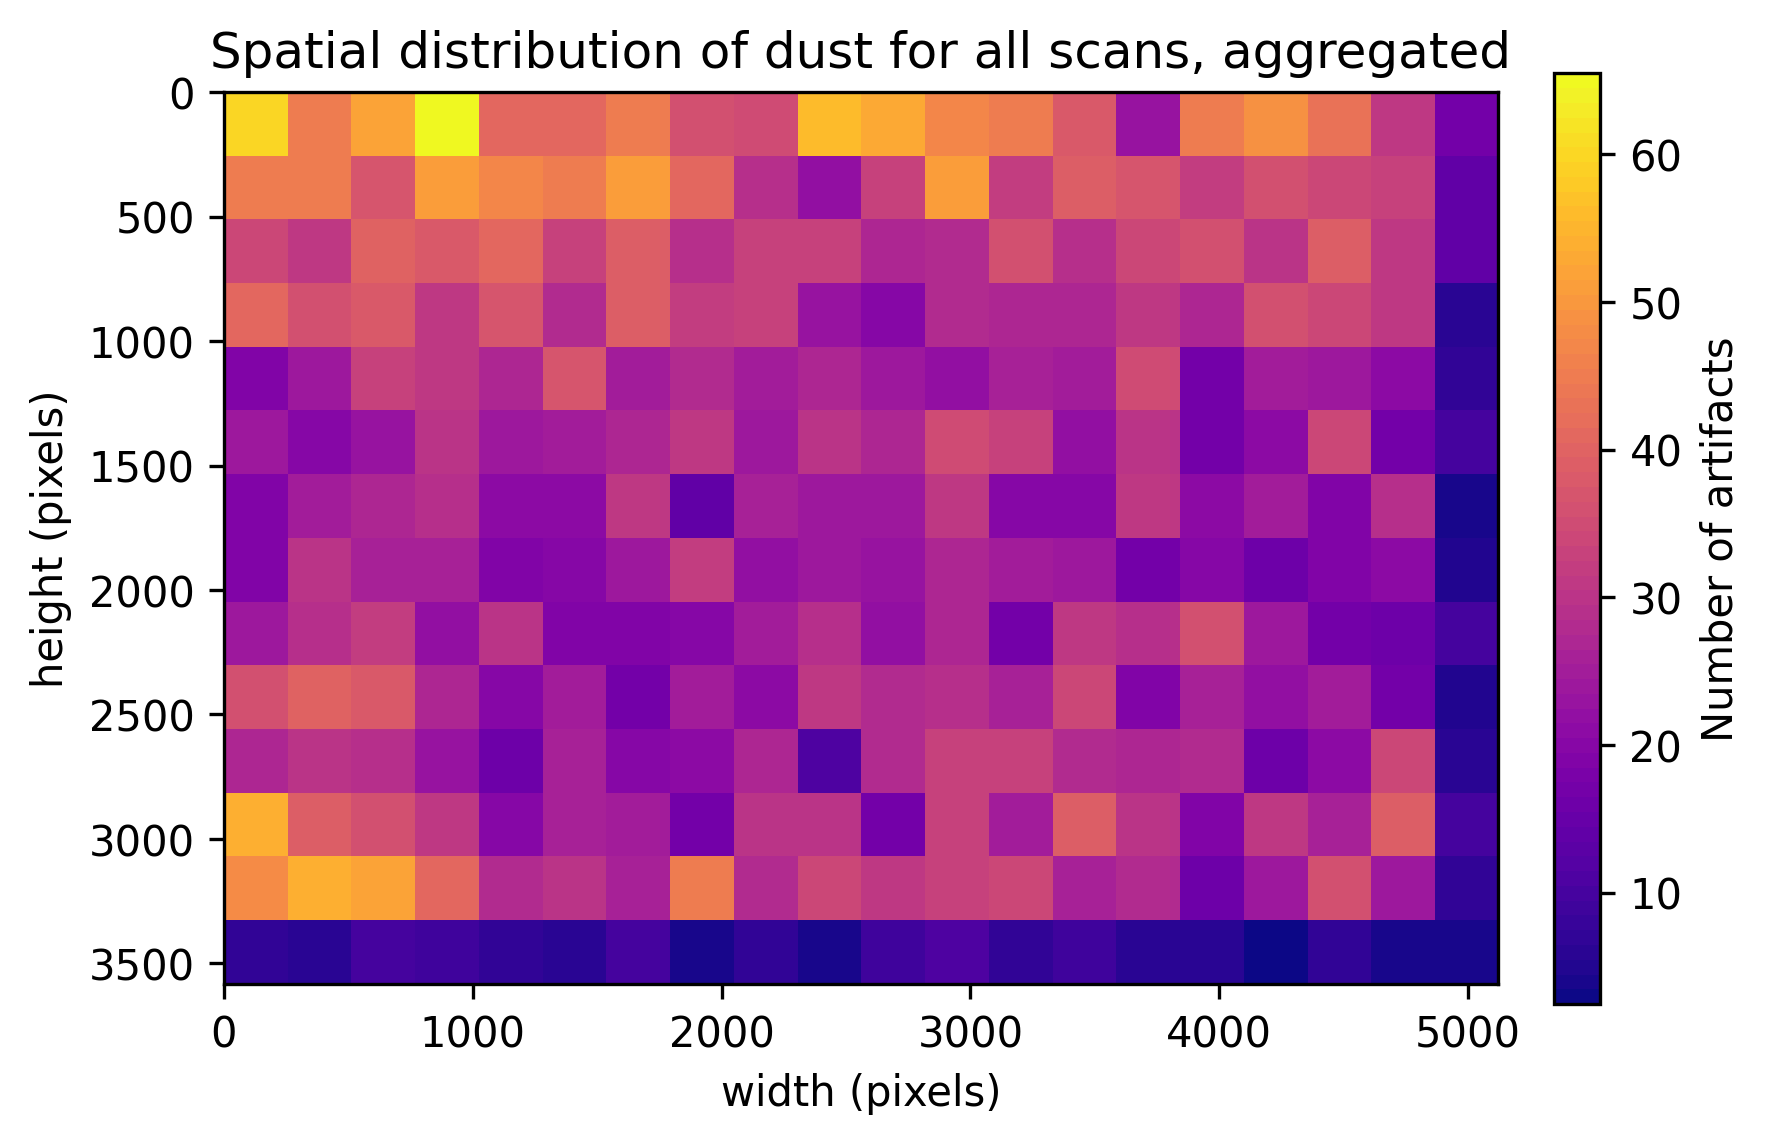

In [ ]:
plot_quadrant_distrib(df_artifacts.loc[df_artifacts['Type'] == 'dust'], 
                   'Number of dust artifacts per 256 by 256 patch', 
                   'Spatial distribution of dust for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

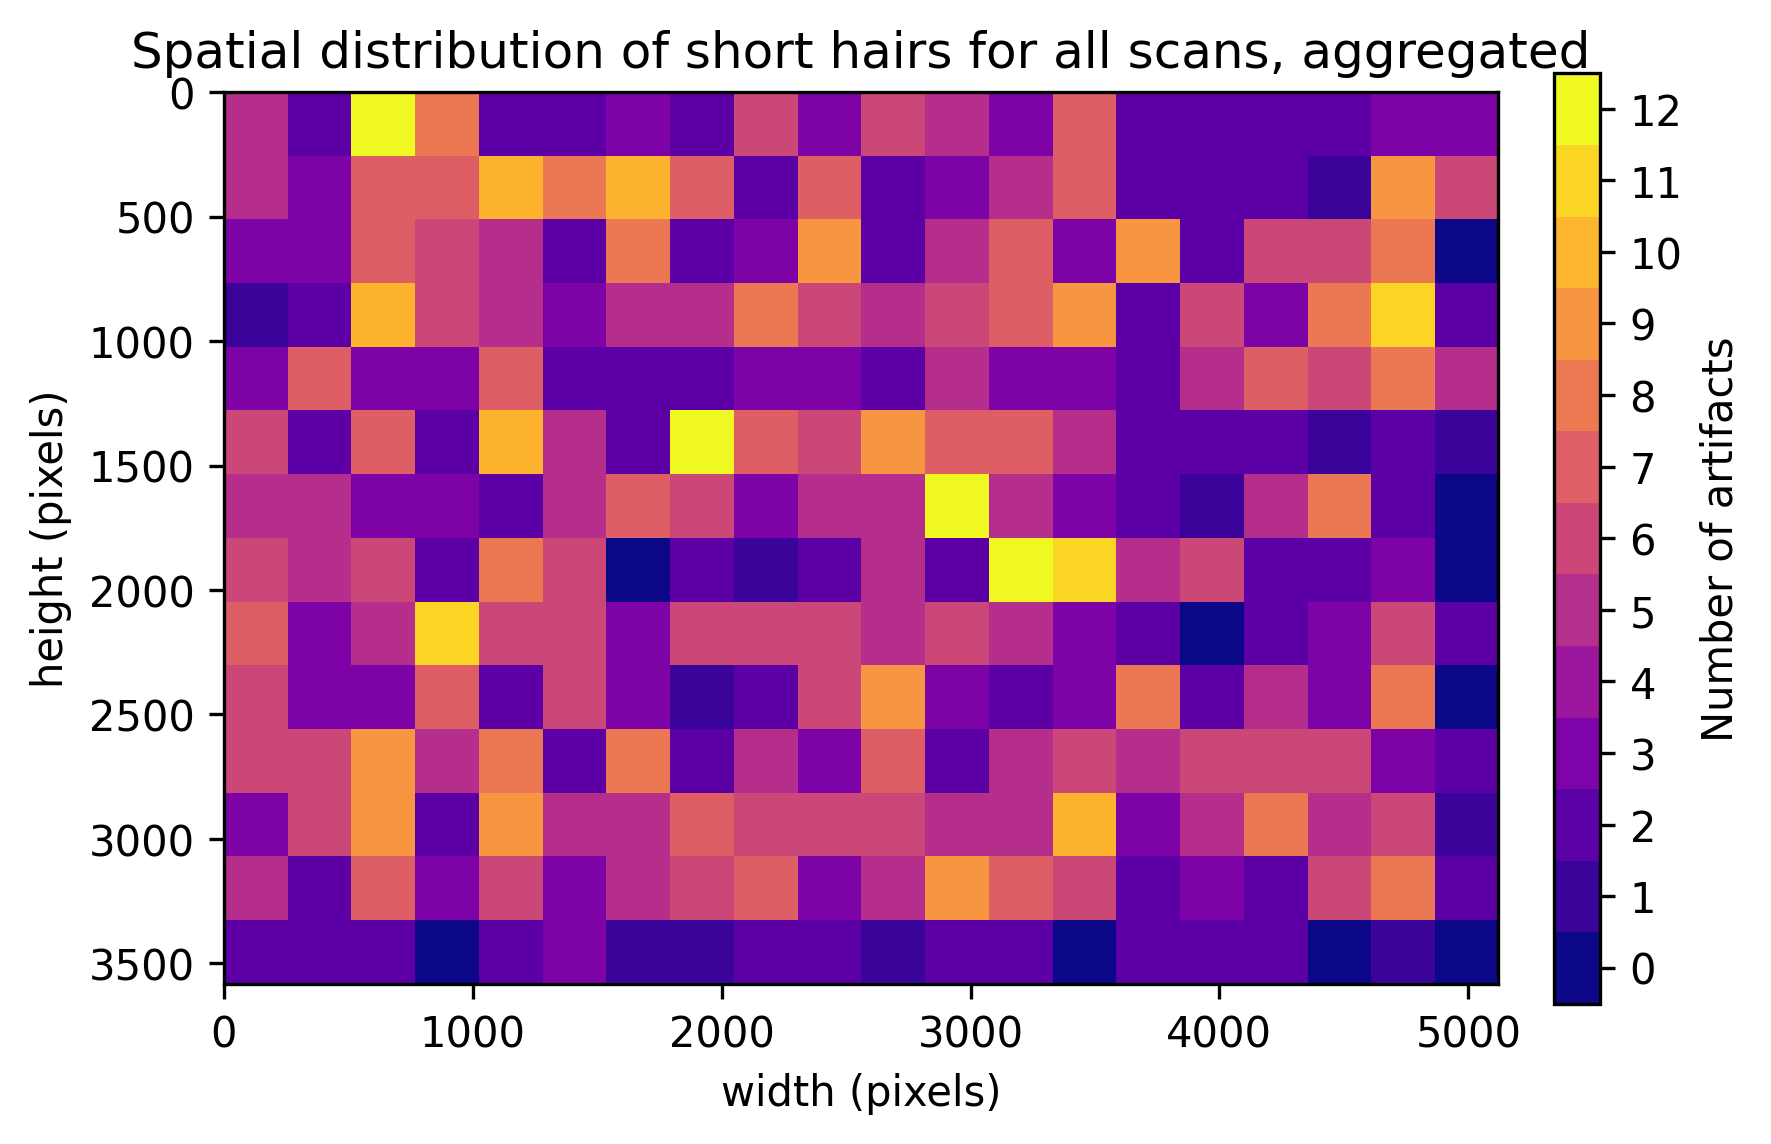

In [ ]:
plot_quadrant_distrib(df_artifacts.loc[df_artifacts['Type'] == 'short hair'], 
                   'Number of dust artifacts per 250 by 250 patch', 
                   'Spatial distribution of short hairs for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

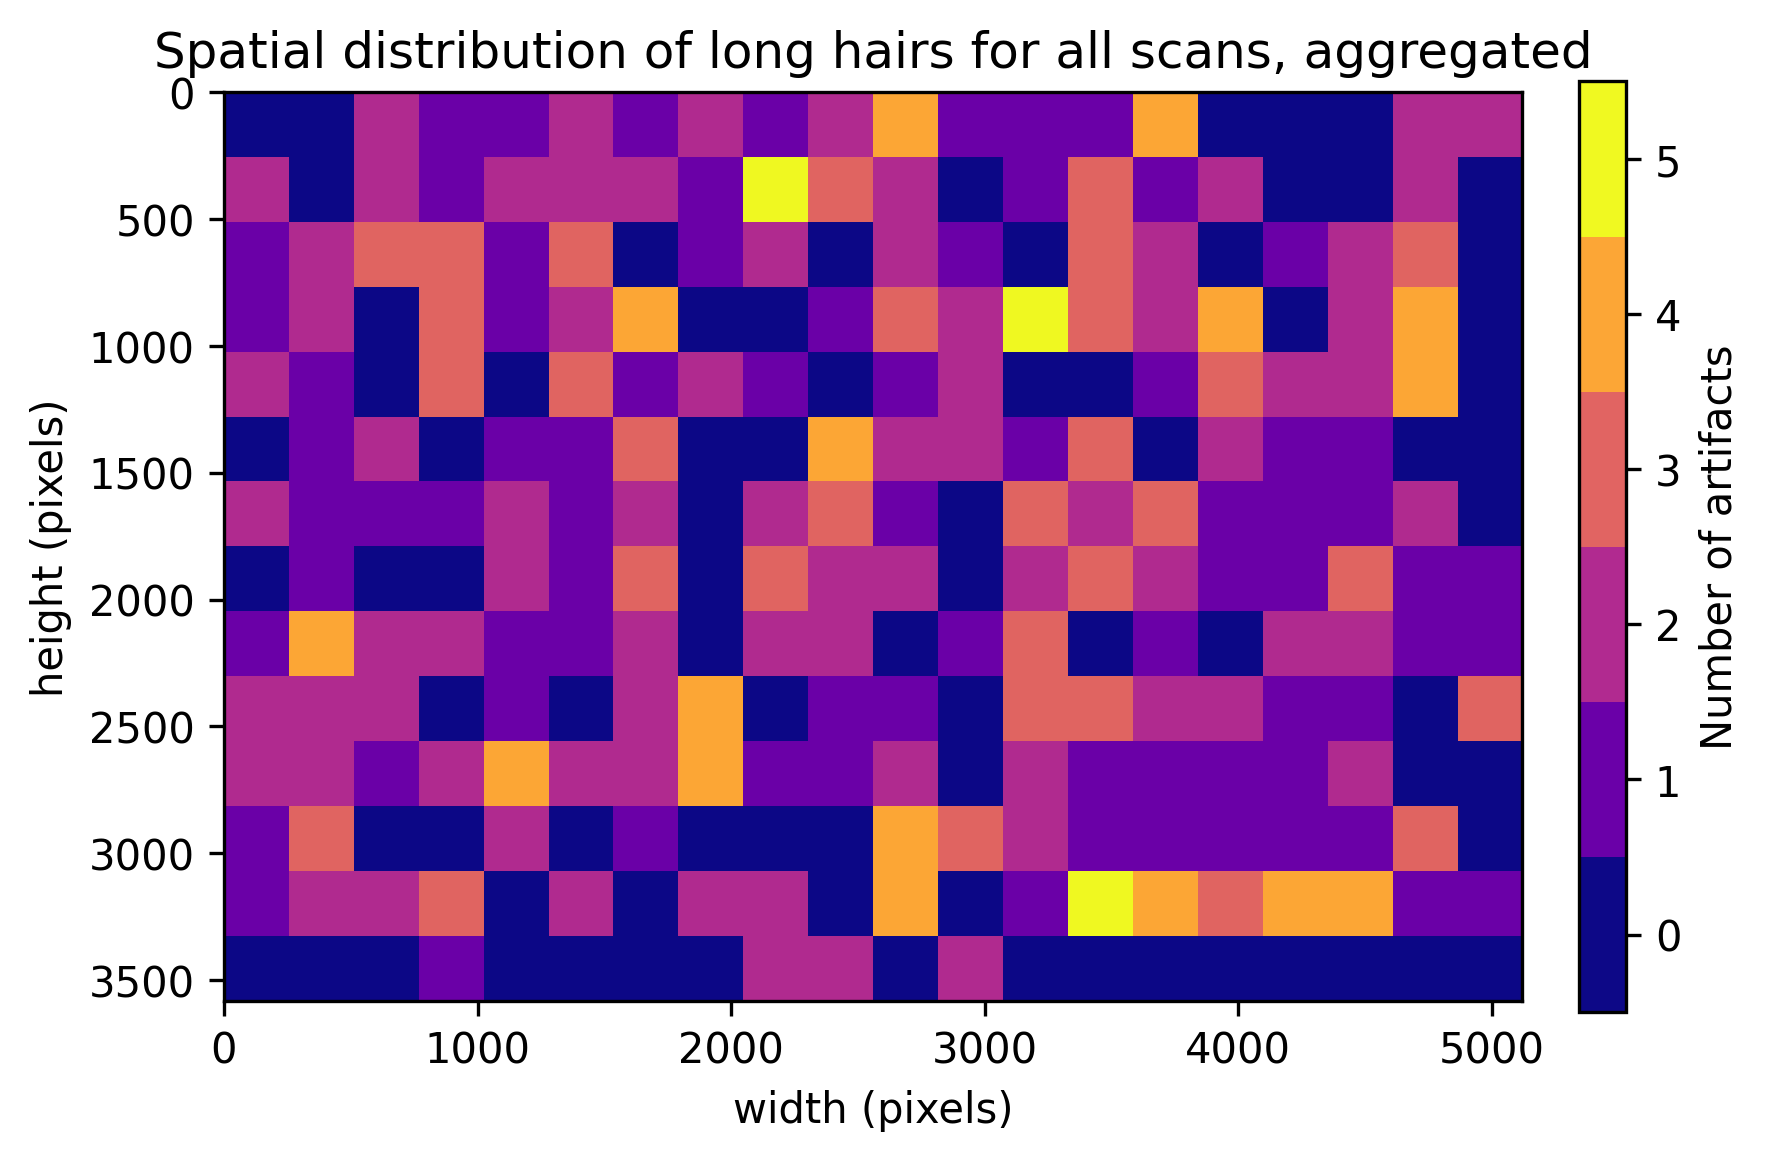

In [ ]:
plot_quadrant_distrib(df_artifacts.loc[df_artifacts['Type'] == 'long hair'], 
                   'Number of dust artifacts per 250 by 250 patch', 
                   'Spatial distribution of long hairs for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

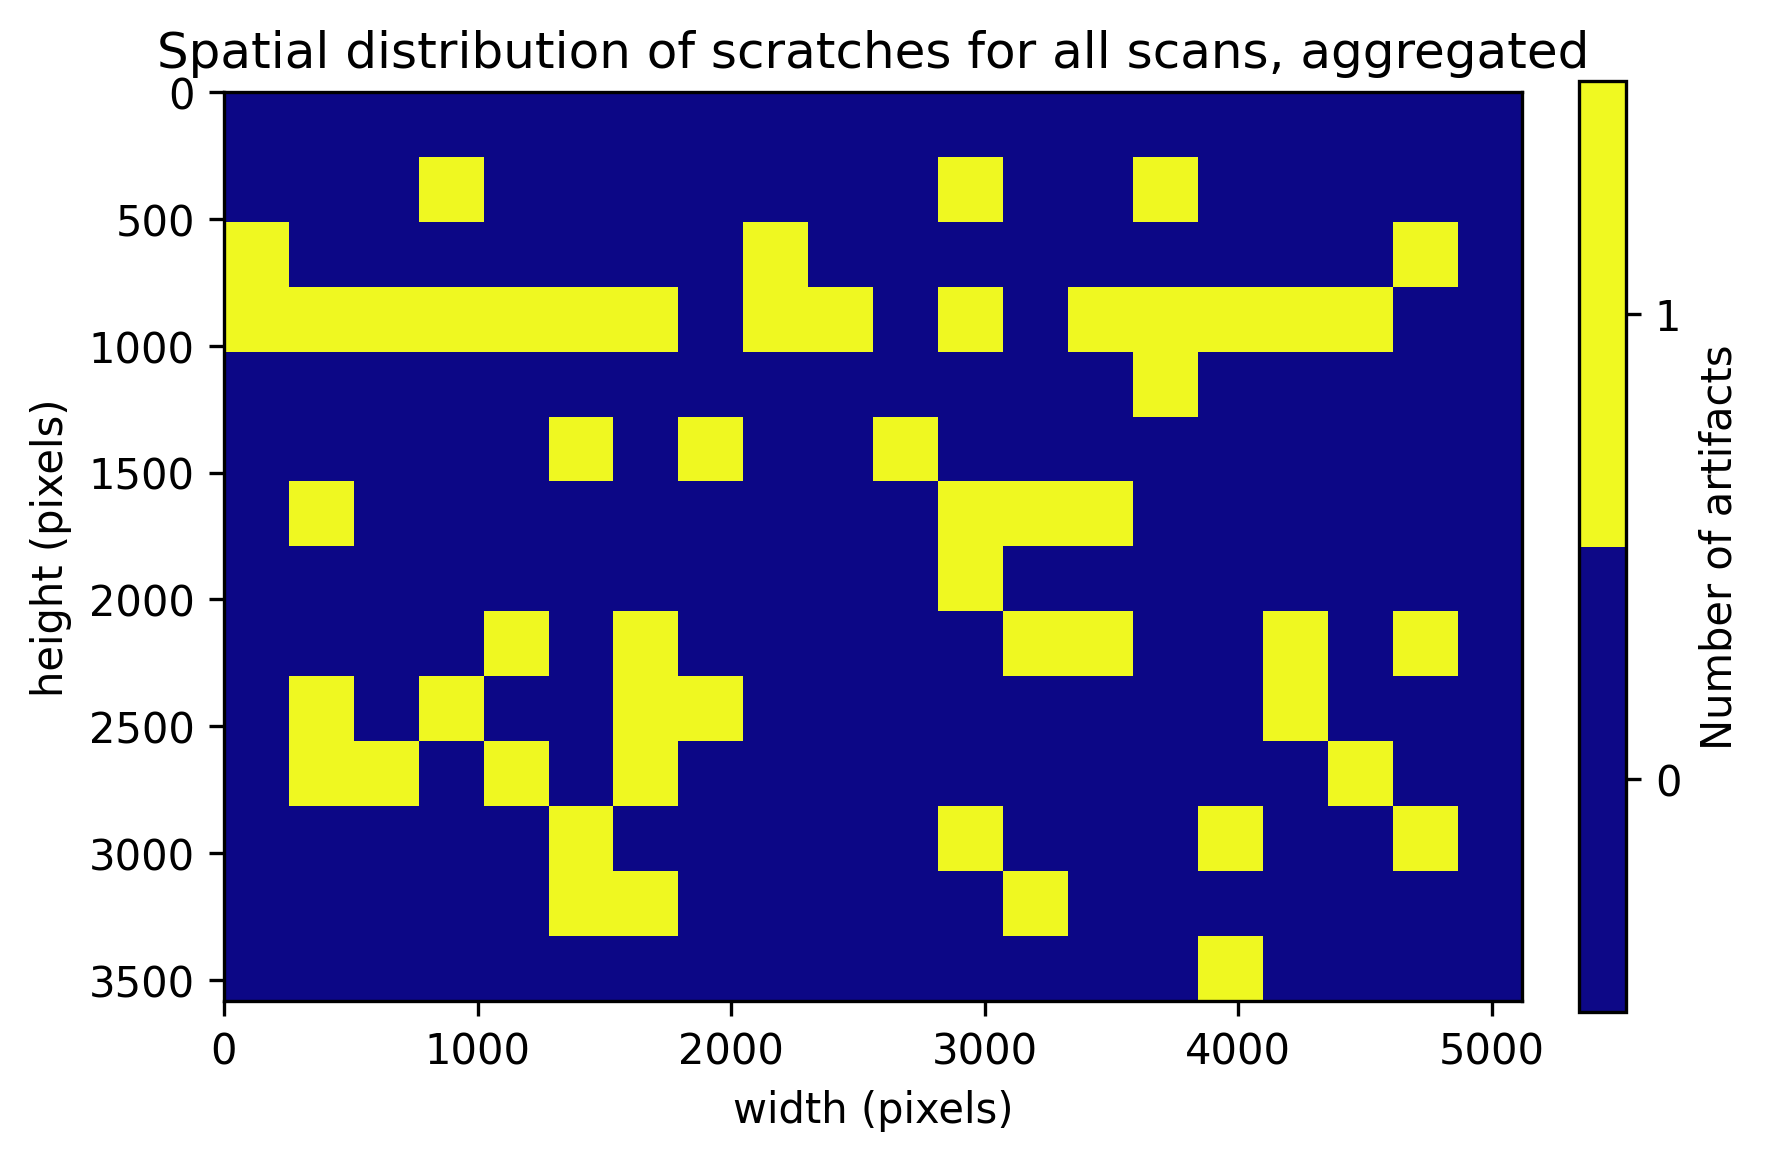

In [ ]:
plot_quadrant_distrib(df_artifacts.loc[df_artifacts['Type'] == 'scratch'], 
                   'Number of dust artifacts per 250 by 250 patch', 
                   'Spatial distribution of scratches for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

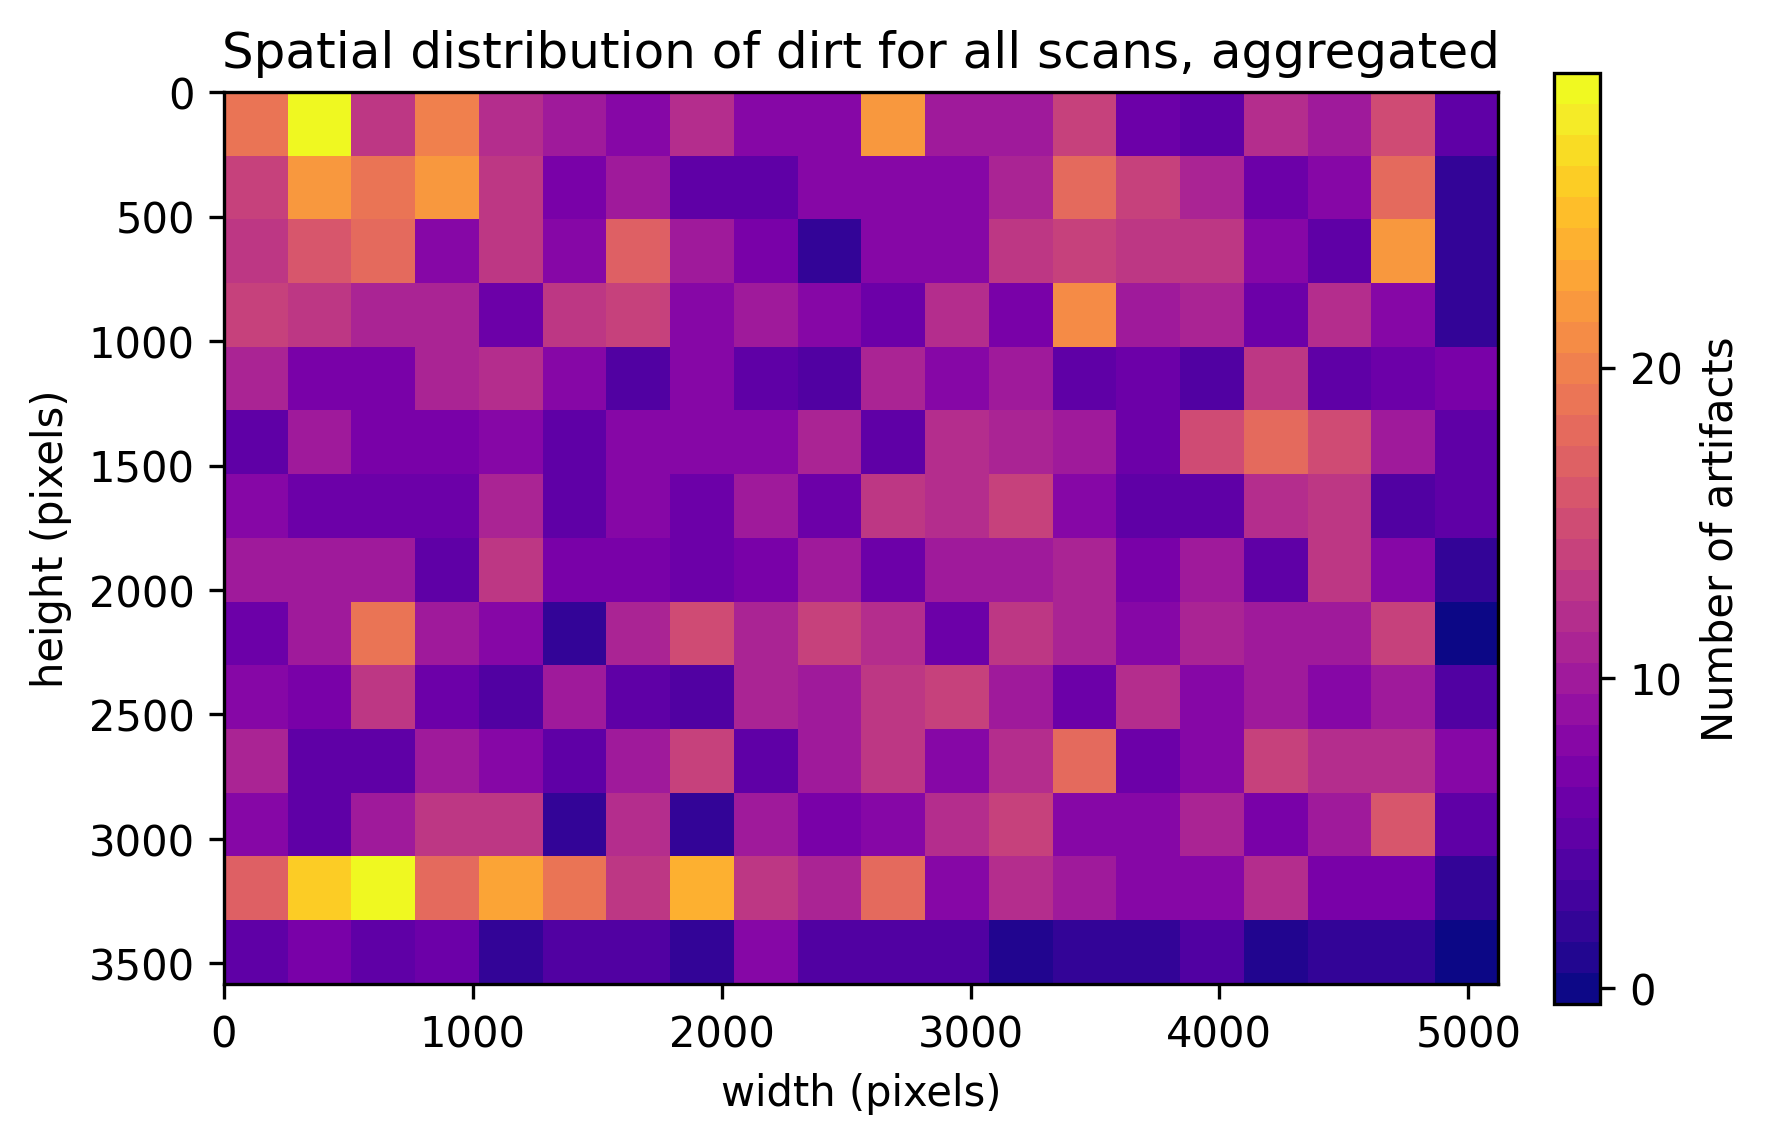

In [ ]:
plot_quadrant_distrib(df_artifacts.loc[df_artifacts['Type'] == 'dirt'], 
                   'Number of dust artifacts per 250 by 250 patch', 
                   'Spatial distribution of dirt for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

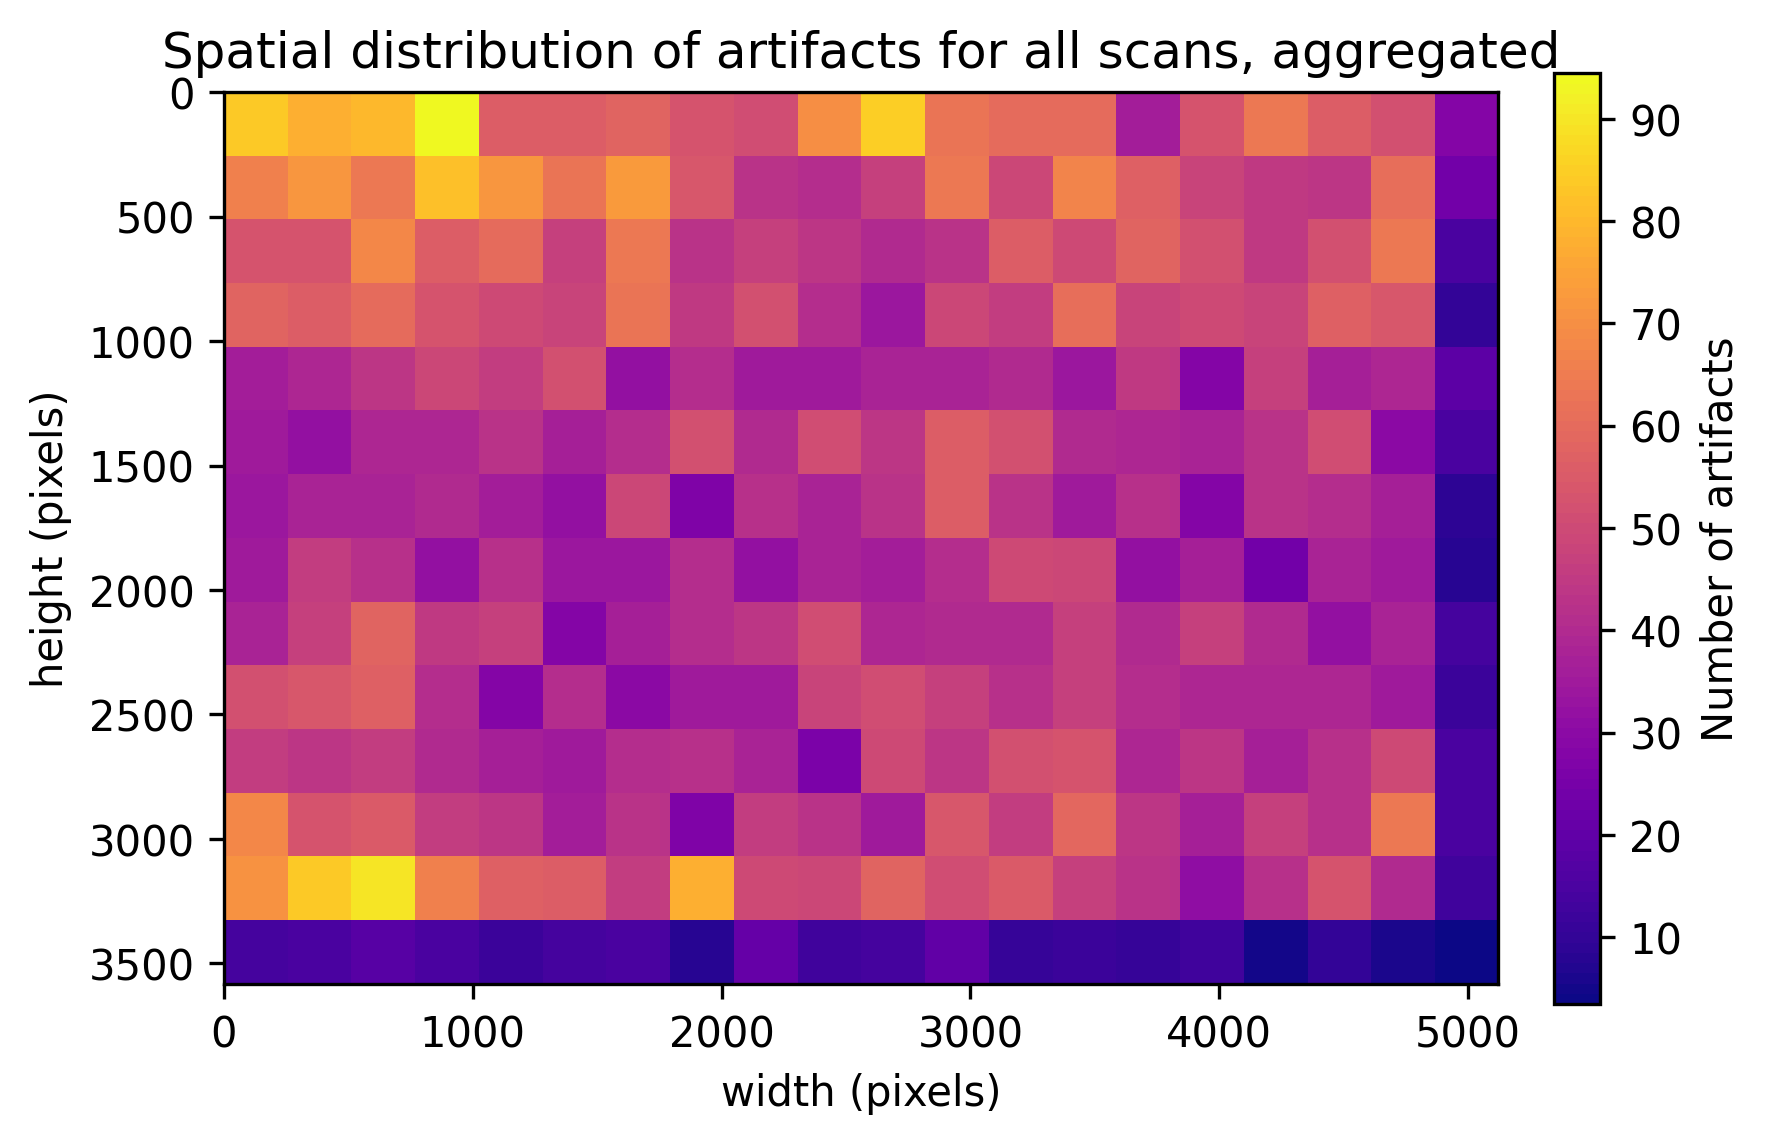

In [ ]:
plot_quadrant_distrib(df_artifacts, 
                   'Number of all artifacts per 250 by 250 patch', 
                   'Spatial distribution of artifacts for', 
                   'width (pixels)',
                   'height (pixels)', 
                   'plasma'
                   )

#Synthetic artifacts

In [ ]:
synthetic_artifacts_dir = '/content/drive/MyDrive/film_damage_elements'

In [ ]:
def load_images(synthetic_artifacts_dir, artifact_type, verbose=False):
    images = []
    images_df_list = []
    artifact_map = {
        'stain' : 'dirt',
        'spots' : 'dirt',
        'lint' : 'short hair',
        'dirt' : 'dirt',
        'dots' : 'dirt',
        'scratches' : 'dirt',
        'hair-short' : 'short hair',
        'sprinkles' : 'dust',
        'hair' : 'long hair',
        'smut' : 'dirt',
    }
    for img_filename in sorted_alphanumeric(os.listdir(synthetic_artifacts_dir+'/'+artifact_type+'/')):
        if img_filename.endswith(".png"):
            if verbose: print('Loading image overlay ', img_filename)
            img = cv.imread(synthetic_artifacts_dir+'/'+artifact_type+'/'+img_filename, cv.IMREAD_UNCHANGED)[:,:,3]
            if img is not None:        
                #images.append(img)
                
                ret, thresh = cv.threshold(img, 127, 255, 0)
                kernel = np.ones((3,3), np.uint8)
                contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
                cnt = max(contours, key=len)
                images_df_list.append(
                                        {
                                            'Contour': cnt, 
                                            'Contour Area (px)': cv.contourArea(cnt), 
                                            'Non-zero pixel area': cv.countNonZero(img),
                                            'Bounding box (x, y, w, h)': cv.boundingRect(cnt), 
                                            'Min bounding bounding box (center (x,y), (w, h), angle)': cv.minAreaRect(cnt), 
                                            'Original Type': artifact_type,
                                            'Type': artifact_map[artifact_type],
                                            'Artifact': img,
                                        }
                                      )
    #images_np = np.array(images)
    images_df = pd.DataFrame(images_df_list)
    return images_df#, images_np


*   stain -> dirt
*   spots -> dust
*   lint -> short hair
*   dirt -> dirt
*   dots -> dirt
*   scratches -> dirt
*   hair-short -> short hair
*   sprinkles -> dirt
*   hair -> long hair
*   smut -> dirt




In [ ]:
def load_all_synthetic_images(synthetic_artifacts_dir, verbose=False):
    subdirs = next(os.walk(synthetic_artifacts_dir))[1]
    df_synthetic_artifacts = pd.DataFrame()
    for subdir in subdirs:
        df_synthetic_artifacts = pd.concat([df_synthetic_artifacts, 
                   load_images(synthetic_artifacts_dir, subdir, verbose=verbose),
                   ], axis=0, ignore_index=True)
    return df_synthetic_artifacts

In [ ]:
df_synthetic_artifacts = load_all_synthetic_images(synthetic_artifacts_dir)

In [ ]:
df_synthetic_artifacts = df_synthetic_artifacts.sample(frac=1).reset_index(drop=True)

In [ ]:
df_synthetic_artifacts

Contour  \
0     [[[264, 113]], [[264, 114]], [[263, 115]], [[263, 116]], [[263, 117]], [[263, 118]], [[263, 119]], [[263, 120]], [[263, 121]], [[264, 122]], [[264, 123]], [[264, 124]], [[264, 125]], [[264, 126]], [[264, 127]], [[264, 128]], [[264, 129]], [[265, 130]], [[265, 131]], [[265, 132]], [[265, 133]], [[266, 134]], [[266, 135]], [[266, 136]], [[266, 137]], [[266, 138]], [[266, 139]], [[266, 140]], [[266, 141]], [[266, 142]], [[266, 143]], [[266, 144]], [[265, 145]], [[265, 146]], [[265, 147]], [[264, 148]], [[264, 149]], [[264, 150]], [[264, 151]], [[264, 152]], [[264, 153]], [[263, 154]], [[263, ...   
1     [[[134, 94]], [[134, 95]], [[135, 96]], [[136, 97]], [[137, 98]], [[138, 99]], [[139, 100]], [[140, 101]], [[141, 102]], [[142, 103]], [[143, 104]], [[144, 105]], [[145, 106]], [[146, 107]], [[147, 108]], [[148, 109]], [[149, 110]], [[149, 111]], [[150, 112]], [[151, 113]], [[152, 114]], [[153, 115]], [[154, 116]], [[155, 117]], [[156, 118]], [[157, 119]], [[158, 120]], [[159, 121]], [[160, 121]], [[161, 122]], [[162, 123]], [[163, 124]], [[164, 125]], [[165, 126]], [[166, 127]], [[167, 128]], [[168, 129]], [[169, 130]], [[170, 131]], [[171, 132]], [[172, 133]], [[173, 134]], [[174, 135]],...   
2     [[[174, 125]], [[173, 126]], [[172, 126]], [[171, 127]], [[170, 128]], [[169, 129]], [[168, 130]], [[167, 131]], [[166, 132]], [[165, 133]], [[164, 134]], [[163, 135]], [[163, 136]], [[162, 137]], [[161, 137]], [[160, 138]], [[160, 139]], [[159, 140]], [[159, 141]], [[159, 142]], [[160, 143]], [[160, 144]], [[160, 145]], [[161, 146]], [[161, 147]], [[162, 148]], [[162, 149]], [[162, 150]], [[162, 151]], [[162, 152]], [[161, 153]], [[161, 154]], [[161, 155]], [[160, 156]], [[159, 157]], [[158, 158]], [[158, 159]], [[157, 160]], [[156, 160]], [[156, 161]], [[156, 162]], [[155, 163]], [[154, ...   
3     [[[169, 153]], [[168, 154]], [[167, 154]], [[166, 154]], [[165, 154]], [[164, 154]], [[163, 154]], [[162, 155]], [[161, 155]], [[160, 155]], [[159, 156]], [[158, 156]], [[157, 156]], [[156, 156]], [[155, 156]], [[154, 157]], [[153, 157]], [[152, 157]], [[151, 157]], [[150, 157]], [[149, 157]], [[148, 157]], [[147, 157]], [[146, 157]], [[145, 157]], [[144, 157]], [[143, 157]], [[142, 156]], [[141, 156]], [[140, 156]], [[139, 156]], [[138, 156]], [[137, 156]], [[136, 156]], [[135, 156]], [[134, 156]], [[133, 156]], [[132, 156]], [[131, 156]], [[130, 156]], [[129, 156]], [[128, 156]], [[127, ...   
4     [[[120, 44]], [[121, 45]], [[121, 46]], [[121, 47]], [[122, 48]], [[122, 49]], [[123, 50]], [[123, 51]], [[123, 52]], [[124, 53]], [[124, 54]], [[125, 55]], [[125, 56]], [[125, 57]], [[126, 58]], [[126, 59]], [[126, 60]], [[127, 61]], [[127, 62]], [[127, 63]], [[127, 64]], [[128, 65]], [[128, 66]], [[128, 67]], [[128, 68]], [[128, 69]], [[129, 70]], [[129, 71]], [[129, 72]], [[129, 73]], [[129, 74]], [[130, 75]], [[130, 76]], [[130, 77]], [[130, 78]], [[131, 79]], [[131, 80]], [[131, 81]], [[132, 82]], [[132, 83]], [[132, 84]], [[133, 85]], [[133, 86]], [[133, 87]], [[134, 88]], [[134, 89]...   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ...   
6095  [[[177, 20]], [[177, 21]], [[178, 22]], [[179, 22]], [[180, 22]], [[181, 23]], [[182, 23]], [[183, 24]], [[184, 24]], [[185, 25]], [[186, 25]], [[187, 26]], [[188, 26]], [[189, 27]], [[190, 28]], [[191, 28]], [[192, 29]], [[193, 30]], [[194, 31]], [[195, 32]], [[196, 32]], [[197, 33]], [[198, 34]], [[199, 35]], [[199, 36]], [[2

In [ ]:
def plot_example_damage_items(damage_array):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 6),
                            subplot_kw={'xticks': [], 'yticks': []})

    for ax, damage_example in zip(axs.flat, damage_array.head(9)['Artifact'].tolist()):
        ax.imshow(damage_example, cmap='gray')

    plt.tight_layout()
    plt.show()

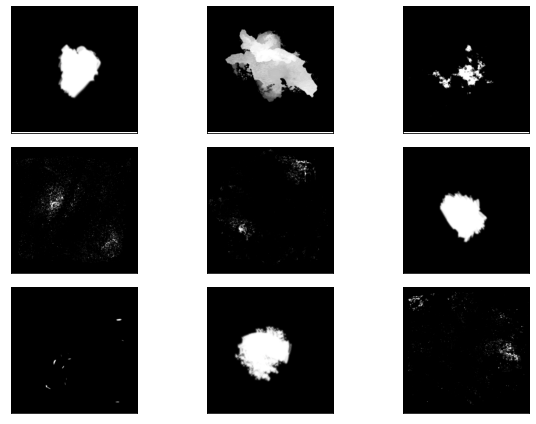

In [ ]:
plot_example_damage_items(df_synthetic_artifacts.loc[df_synthetic_artifacts['Type']=='dirt'])

#Dustifier

## Perlin noise for spatial sampling

In [ ]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [ ]:
def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise

In [ ]:
def increase_contrast(pixvals):
    minval = np.percentile(pixvals, 2)
    maxval = np.percentile(pixvals, 98)
    pixvals = np.clip(pixvals, minval, maxval)
    pixvals = ((pixvals - minval) / (maxval - minval))
    return pixvals

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
def random_uniform(num_samples, noise_array):
    # Create a flat copy of the array
    linear_idx = np.random.choice(noise_array.size, size=num_samples)
    x, y = np.unravel_index(linear_idx, noise_array.shape)
    return x, y

In [ ]:
def random_perlin_with_numpy(num_samples, noise_array):
    # Create a flat copy of the array
    linear_idx = np.random.choice(noise_array.size, p=noise_array.ravel()/float(noise_array.sum()), size=num_samples)
    x, y = np.unravel_index(linear_idx, noise_array.shape)
    return x, y

In [ ]:
import random
def random_perlin_with_random_choices(num_samples, noise_array):
    # Create a flat copy of the array
    linear_idx = random.choices(np.arange(noise_array.size), weights=noise_array.ravel(), k=num_samples)
    x, y = np.unravel_index(linear_idx, noise_array.shape)
    return x, y

## Create masks

In [ ]:
def shift_bit_length(x):
    return 1<<(x-1).bit_length()

In [ ]:
def line_scratch(length):

    length_pot = shift_bit_length(length.item())
    noise_scale = np.random.randint(1, 4, size=1, dtype=int)[0].item()
    perlin_noise = generate_perlin_noise_2d((length_pot, length_pot), (2**noise_scale, 2**noise_scale))
    normalised_noise = (perlin_noise - np.min(perlin_noise))/np.ptp(perlin_noise)
    slice_fade = np.random.randint(low=0, high=length-20, size=1, dtype=int)[0]
    fade = increase_contrast(normalised_noise)[0:length.item(), slice_fade.item():slice_fade.item()+20]
    fade *= (255.0/fade.max())
    mean = 0
    var = 15
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (fade.shape[0], fade.shape[1])) 
    fade = fade + gaussian
    fade = fade.astype(np.uint8)

    num_lines = np.random.randint(1, 2, size=1, dtype=int)
    lines_xs = np.random.randint(1, 19, size=num_lines, dtype=int)
    lines_ys = np.random.randint(0, int(length*0.2), size=num_lines, dtype=int)

    line_mask_width, line_mask_height = 20, length
    line_mask = np.ones((line_mask_height, line_mask_width)) * 255
    line_thickness = 1

    
    #for i in range(num_lines[0]):
    x1, y1 = lines_xs[0], lines_ys[0]
    x2, y2 = lines_xs[0], np.random.randint(lines_ys[0]+10, length-(lines_ys[0]+10), size=1, dtype=int)
    line = cv.line(line_mask, (x1, y1), (x2, int(y2)), (0, 255, 0), thickness=line_thickness).astype(np.uint8)

    scratch = cv.bitwise_and(fade, np.invert(line)).astype(np.uint8)
    scratch = cv.GaussianBlur(scratch, (3,3), 0).astype(np.uint8)
    scratch = cv.resize(scratch, None, fx = 0.5, fy = 1, interpolation = cv.INTER_CUBIC)

    return scratch

In [ ]:
line_scratch(np.int64(60))

array([[ 0,  0,  0,  0,  0,  0,  0,  0, 20,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 23,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 36,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 41, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 46, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 53, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 59, 14],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 62, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 64, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 62, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 61, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 59, 14],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 56, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 54, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 52, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 52, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 51, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 49, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 47, 11],
       [ 0,  0,  0, 

In [ ]:
def get_random_patch_of_size(img_size, target_size):
    if img_size[0]-target_size[0]-1 > 0 and img_size[1]-target_size[1]-1 > 0:
        x1 = np.random.randint(0, img_size[0]-target_size[0]-1)
        y1 = np.random.randint(0, img_size[1]-target_size[1]-1)

        x2, y2 = x1+target_size[0], y1+target_size[1]
    else: 
        x1, x2, y1, y2 = None, None, None, None
    return x1, x2, y1, y2

In [ ]:
def sample_size_artifacts(df, artifact_type, num_artifact):
    min = df.loc[df['Type'] == artifact_type]['Contour Area (px)'].min()    
    max = df.loc[df['Type'] == artifact_type]['Contour Area (px)'].max()    
    x = np.linspace(min, max)
    gamma = stats.gamma
    gamma_param = gamma.fit(df.loc[df['Type'] == artifact_type]['Contour Area (px)'], floc=0)
    pdf_fitted = gamma.pdf(x, *gamma_param)
    shape, _, scale = gamma_param
    samples = np.random.gamma(shape, scale, num_artifact)
    return samples

In [ ]:
def sample_num_artifacts(df_counts, artifact_type, target_size=None):
    ratio = target_size[0]/256
    min = df_counts.loc[df_counts['Type'] == artifact_type]['Counts'].min()
    max = df_counts.loc[df_counts['Type'] == artifact_type]['Counts'].max()
    # Sometimes we don't want any artifacts
    x = np.linspace(0, max)
    gamma = stats.gamma
    gamma_param = gamma.fit(df_counts.loc[df_counts['Type'] == artifact_type]['Counts'], floc=0)
    pdf_fitted = gamma.pdf(x, *gamma_param)
    shape, _, scale = gamma_param
    num_artifact = np.random.gamma(shape, scale, 1)
    #num_artifact = num_artifact * (ratio**2)
    return num_artifact.astype(int)

In [ ]:
def sample_closest_in_area(df, target_areas):
    df = df.sample(frac=1).reset_index(drop=True) # reshuffle
    dust_areas = df['Contour Area']
    indexes = []
    for i in target_areas:
        df_sort = df.iloc[(dust_areas-i).abs().argsort()[:15]]
        candidate_indexes = df_sort.index.tolist()
        index = random.choice(candidate_indexes)
        indexes.append(index)
        dust_areas = dust_areas.drop(dust_areas.index[[index]])
    df = df.iloc[indexes].copy()
    df['Target size'] = target_areas
    return df

Area 1 = 2 * 2 = 4
Area 2 = 4 * 4 = 16

Ratio area = 16/4 = 4
Ratio sides = 4/2 = 2 = sqrt(4)

skimage resize expects scale or tuple of scales meaning it should be 1D 

In [ ]:
def create_random_mask(target_size, df, df_synthetic, df_counts,
                       use_synthetic=False, 
                       min_artifacts=5, max_artifacts=100, rescale=True, 
                       uniform_sample=False, verbose=True):
   
    if rescale:
        rescale_factor = target_size[0]/2560 if target_size[0] <= target_size[1] else target_size[1]/2560
    else:
        rescale_factor = 1.
    if not uniform_sample:

        num_dust = sample_num_artifacts(df_counts, 'dust', target_size)
        num_dirt = sample_num_artifacts(df_counts, 'dirt', target_size)
        num_long_hair = sample_num_artifacts(df_counts, 'long hair', target_size)
        num_short_hair = sample_num_artifacts(df_counts, 'short hair', target_size)
        num_scratch = sample_num_artifacts(df_counts, 'scratch', target_size)
        
        add_scratches = random.random()
        num_extra_scratch = np.random.gamma(6, 2, 1).astype(int) if add_scratches > 0.5 else 0

        resize_targets_dust = sample_size_artifacts(df, 'dust', num_dust)
        resize_targets_dirt = sample_size_artifacts(df, 'dirt', num_dirt)
        resize_targets_short_hair = sample_size_artifacts(df, 'short hair', num_short_hair)
        resize_targets_long_hair= sample_size_artifacts(df, 'long hair', num_long_hair)
        resize_targets_scratch = sample_size_artifacts(df, 'scratch', num_scratch)

        if verbose: print(
            "Sampling {} dust artifacts, {} dirt artifacts, {} long hairs, {} short hairs, {} scratches and {} extra scratches...".format(
                num_dust, num_dirt, num_long_hair, num_short_hair, num_scratch, num_extra_scratch
            ))
        
        if use_synthetic: 
            df_merged = pd.concat([df[['Type', 'Contour Area (px)', 'Artifact']].rename(columns={'Contour Area (px)':'Contour Area'}),
                               df_synthetic[['Type', 'Non-zero pixel area', 'Artifact']].rename(columns={'Non-zero pixel area':'Contour Area'})],
                              ignore_index=True)
            # df_merged = df_synthetic[['Type', 'Non-zero pixel area', 'Artifact']].rename(columns={'Non-zero pixel area':'Contour Area'})
        else:
            df_merged = df[['Type', 'Contour Area (px)', 'Artifact']].rename(columns={'Contour Area (px)':'Contour Area'})

        df_merged = df_merged.sample(frac=1).reset_index(drop=True)
        
        df1 = df_merged.loc[df_merged['Type'] == 'dust'].reset_index(drop=True)
        df2 = df_merged.loc[df_merged['Type'] == 'dirt'].reset_index(drop=True)
        df3 = df_merged.loc[df_merged['Type'] == 'short hair'].reset_index(drop=True)
        df4 = df_merged.loc[df_merged['Type'] == 'long hair'].reset_index(drop=True)
        df5 = df_merged.loc[df_merged['Type'] == 'scratch'].reset_index(drop=True)

        df1 = sample_closest_in_area(df1, resize_targets_dust)
        df2 = sample_closest_in_area(df2, resize_targets_dirt)
        df3 = sample_closest_in_area(df3, resize_targets_short_hair)
        df4 = sample_closest_in_area(df4, resize_targets_long_hair)
        df5 = sample_closest_in_area(df5, resize_targets_scratch)

        selected_artifacts_df = pd.concat([
                                           df1, 
                                           df2, 
                                           df3, 
                                           df4, 
                                           df5,
                                           ])

        artifacts_num = num_dust + num_dirt + num_short_hair + num_long_hair + num_scratch + num_extra_scratch


    else: 
        artifacts_num = np.random.randint(min_artifacts, max_artifacts)
        selected_artifacts_df = df.sample(artifacts_num)
        if verbose: print("Number of artifacts in generated mask: ", artifacts_num)

    mask_final = np.zeros(target_size).astype(np.uint8)

    perlin_noise = generate_perlin_noise_2d(target_size, (2, 2))
    normalised_noise = (perlin_noise - np.min(perlin_noise))/np.ptp(perlin_noise)
    contrast_perlin_noise = increase_contrast(normalised_noise)
    xs, ys = random_perlin_with_numpy(artifacts_num, normalised_noise)
    i = 0
    random_angles = np.random.randint(0, 360, size=artifacts_num)

    for _, artifact_row in selected_artifacts_df.iterrows():
        try:
            artifact_var_idx = np.random.randint(1, 4)
            artifact = artifact_row['Artifact'].astype(np.uint8)

            random_scale = artifact_row['Target size']/artifact_row['Contour Area']
            random_angle = random_angles[i]

            if verbose: print("Global rescale factor {}, Random scale {}, Product {}".format(
                rescale_factor, math.sqrt(random_scale), rescale_factor*math.sqrt(random_scale)))

            new_rescale_factor = rescale_factor * math.sqrt(random_scale)
            #new_rescale_factor = new_rescale_factor if new_rescale_factor > 0.05 else 0.1
            artifact = skimage_tf.rescale(artifact, round(new_rescale_factor, 2), anti_aliasing=True, preserve_range=True)
            artifact = skimage_tf.rotate(artifact, angle=random_angle, resize=True, preserve_range=True)
            artifact_w, artifact_h = artifact.shape[:2]

            x1 = xs[i] - artifact_w // 2
            x2 = x1 + artifact_w

            if x1 < 0:
                artifact = artifact[-x1:,:]
                x1 = 0
            if x2 > target_size[0]:
                artifact = artifact[:-(x2-target_size[0]), :]
                x2 = target_size[0]

            y1 = ys[i] - artifact_h // 2
            y2 = y1 + artifact_h
            
            if y1 < 0:
                artifact = artifact[:, -y1:]
                y1 = 0
            if y2 > target_size[1]:
                artifact = artifact[:, :-(y2-target_size[1])]
                y2 = target_size[1]

            if verbose:
                print("Random location centroid x: {}, y: {}.".format(xs[i], ys[i]))
                
            mask_final[x1:x2,y1:y2] = np.where(artifact>mask_final[x1:x2,y1:y2], artifact, mask_final[x1:x2,y1:y2])
            i=i+1

        except Exception:
            i=i+1
            pass
    
    if add_scratches > 0.5:
        extra_scratches_lengths = np.random.randint(10, high=target_size[0], size=num_extra_scratch, dtype=int)
        horizontal = random.random()
        random_angle_scratches = np.random.randint(0, 2, size=1)


        for scratch_length in extra_scratches_lengths:
            try: 
                scratch = line_scratch(scratch_length)
                scratch = skimage_tf.rotate(scratch, angle=random_angle_scratches, resize=True, preserve_range=True)

                if horizontal > 0.5 : scratch = np.rot90(scratch)
                scratch_w, scratch_h = scratch.shape[:2]

                x1 = xs[i] - scratch_w // 2
                x2 = x1 + scratch_w

                if x1 < 0:
                    scratch = scratch[-x1:,:]
                    x1 = 0
                if x2 > target_size[0]:
                    scratch = scratch[:-(x2-target_size[0]), :]
                    x2 = target_size[0]

                y1 = ys[i] - scratch_h // 2
                y2 = y1 + scratch_h
                
                if y1 < 0:
                    scratch = scratch[:, -y1:]
                    y1 = 0
                if y2 > target_size[1]:
                    scratch = scratch[:, :-(y2-target_size[1])]
                    y2 = target_size[1]

                if verbose:
                    print("Random location centroid x: {}, y: {}.".format(xs[i], ys[i]))
                    
                mask_final[x1:x2,y1:y2] = np.where(scratch>mask_final[x1:x2,y1:y2], scratch, mask_final[x1:x2,y1:y2])
                
                i=i+1
            
            except Exception:
                i=i+1
                pass

    mask_final = np.invert(mask_final.astype(np.uint8))

    maxval = 255
    thresh = 240

    binarised_mask_final = (mask_final > thresh) * maxval

    del selected_artifacts_df

    return mask_final.astype(np.uint8), binarised_mask_final.astype(np.uint8), contrast_perlin_noise

In [ ]:
mask, binary_mask, perlin_noise = create_random_mask((1024, 2048), df_artifacts, df_synthetic_artifacts, df_per_patch_counts, use_synthetic=True, rescale=True)

Sampling [30] dust artifacts, [13] dirt artifacts, [2] long hairs, [2] short hairs, [0] scratches and 0 extra scratches...
Global rescale factor 0.4, Random scale 1.0008631095922698, Product 0.40034524383690795
Random location centroid x: 616, y: 277.
Global rescale factor 0.4, Random scale 1.1426855765521204, Product 0.4570742306208482
Random location centroid x: 122, y: 329.
Global rescale factor 0.4, Random scale 1.3534587540376906, Product 0.5413835016150762
Random location centroid x: 230, y: 424.
Global rescale factor 0.4, Random scale 0.8358595171362802, Product 0.3343438068545121
Random location centroid x: 352, y: 156.
Global rescale factor 0.4, Random scale 1.2445825477322556, Product 0.4978330190929023
Random location centroid x: 2, y: 434.
Global rescale factor 0.4, Random scale 1.1332030790591359, Product 0.45328123162365436
Random location centroid x: 832, y: 1088.
Global rescale factor 0.4, Random scale 0.5296207020260812, Product 0.2118482808104325
Random location centr

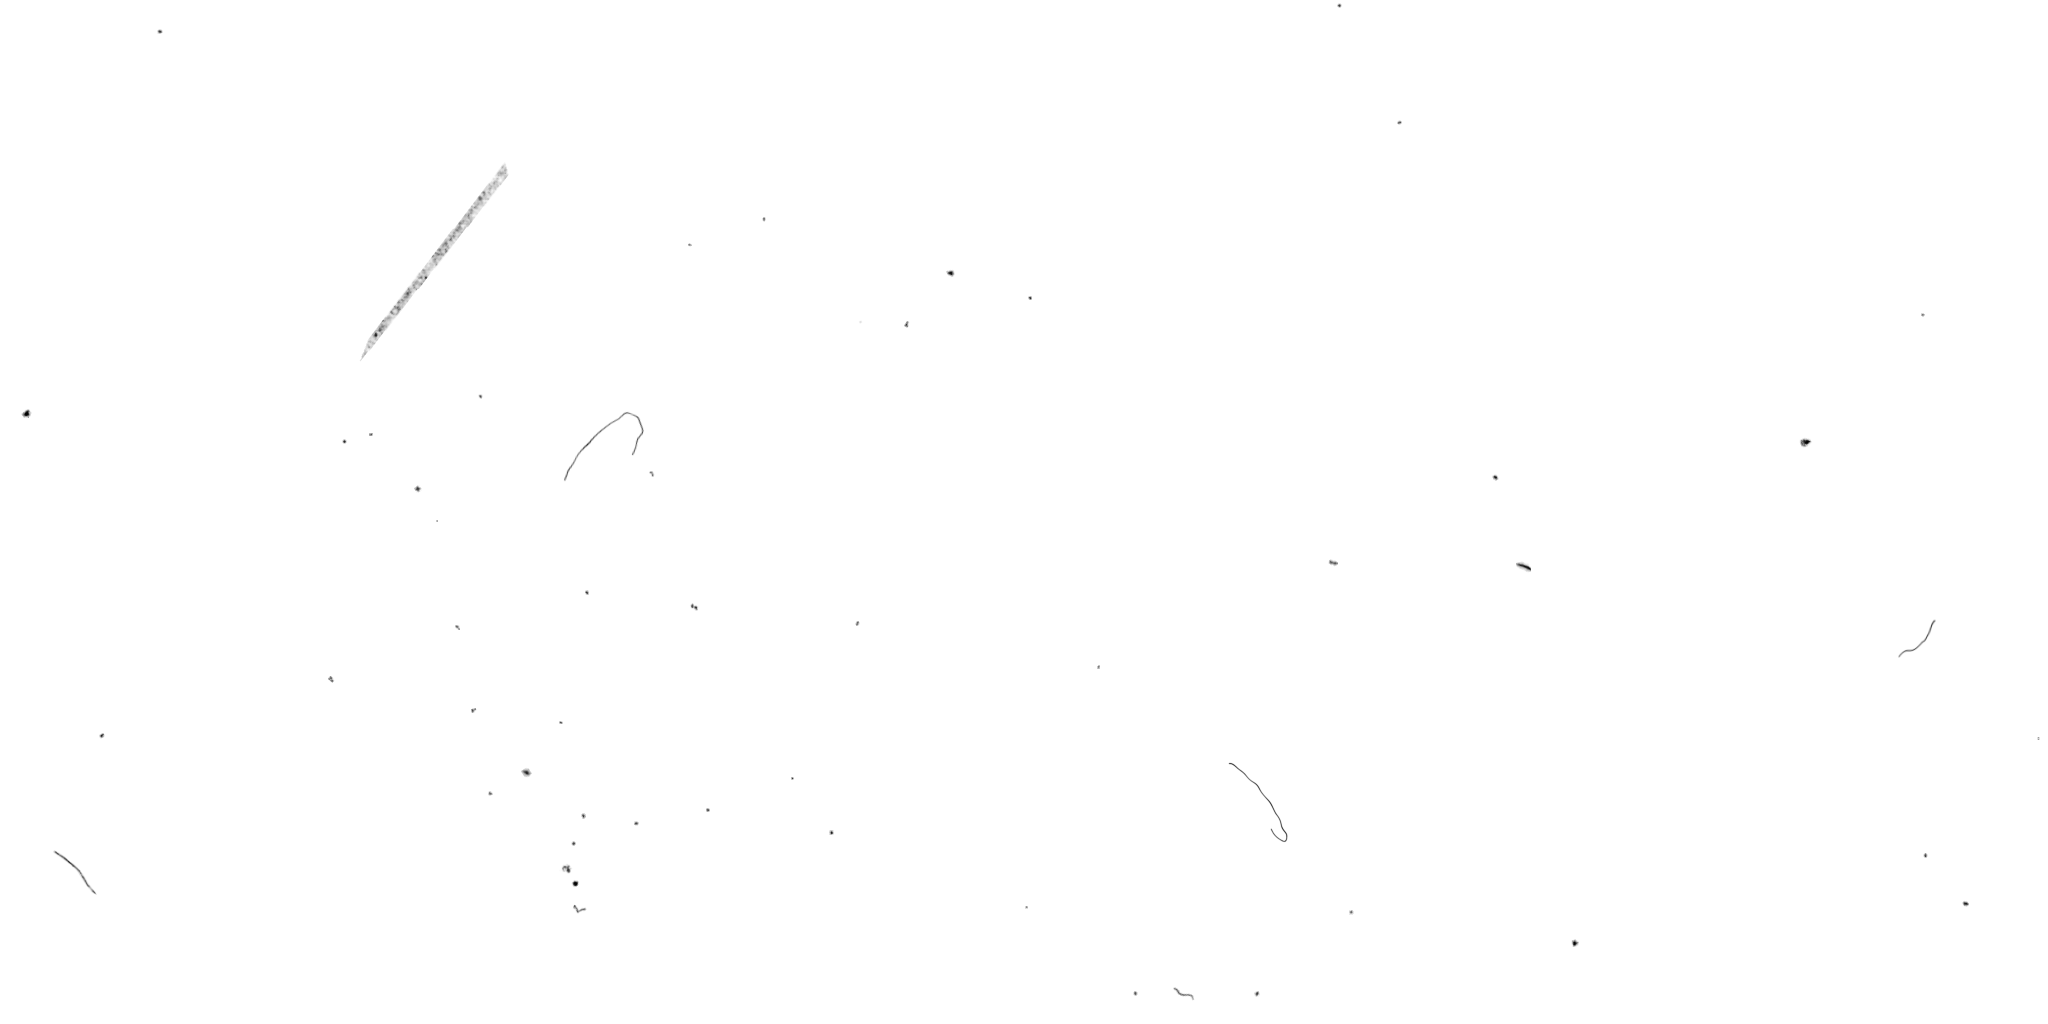

In [ ]:
mask_img_pil = Image.fromarray(mask)
if mask_img_pil.mode != 'RGB':
    mask_img_pil = mask_img_pil.convert('RGB')
mask_img_pil

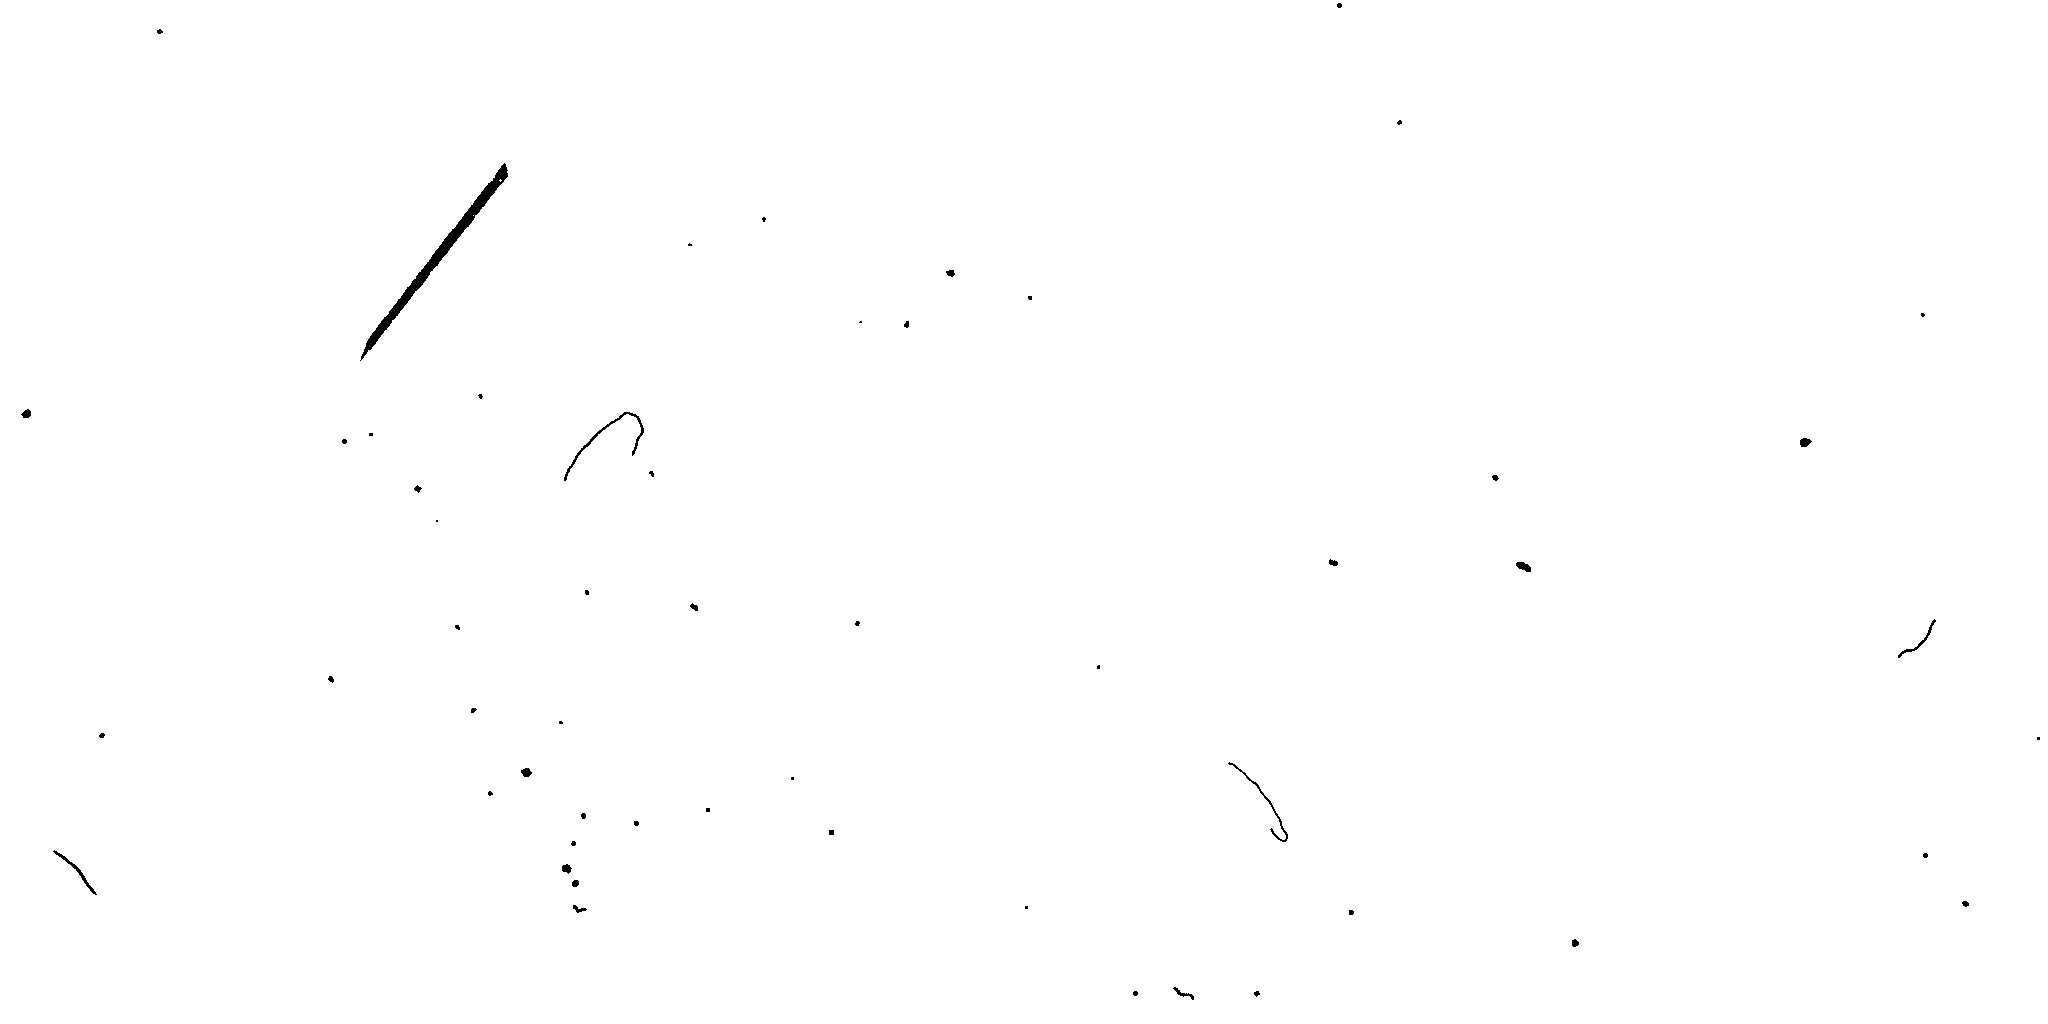

In [ ]:
mask_img_pil = Image.fromarray(binary_mask)
if mask_img_pil.mode != 'RGB':
    mask_img_pil = mask_img_pil.convert('RGB')
mask_img_pil

In [ ]:
def crop_square_pil(im):
    width, height = im.size   # Get dimensions

    new_width = int(0.95*width) if width < height else int(0.95*height)
    new_height = new_width

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    return im.crop((left, top, right, bottom))

In [ ]:
def make_tiles(image, kernel_size, channels=True):
    if channels == False:
        image = np.expand_dims(image, 2)
    img_height, img_width, channels = image.shape
    tile_height, tile_width = kernel_size

    tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width,
                                channels)
    tiled_array = tiled_array.swapaxes(1, 2)

    tiled_array = tiled_array.reshape(-1, tile_width, tile_height, channels)
    if channels == False:
        tiled_array = np.squeeze(tiled_array)
    return tiled_array

##Add masks to images

In [ ]:
from os import listdir
from os.path import isfile, join
import uuid

def center_crop_scanned_images(path, target_size=(2048, 2048), negative=True):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    for image_filename_ext in onlyfiles[:90]: 
        image_filename = os.path.splitext(image_filename_ext)[0]
        pil_image = crop_square_pil(Image.open(path+image_filename_ext)).resize(target_size)
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 
        #resolutions = [int(target_size[0]/(2**j)) for j in range(0,4+1)]

        # for res in resolutions:
        #     directory = path+'tiles/'+image_filename+'/'+str(res)+'/'
        #     if not os.path.exists(directory):
        #         os.makedirs(directory, exist_ok=True)
        #         tiles = make_tiles(open_cv_image, kernel_size=(res, res))
        #         for tile in tiles:
        #             filename = uuid.uuid4().hex
        #             cv.imwrite(directory+'tile_{}_{}.jpg'.format(filename, image_filename), tile)
        #             print('Saving '+directory+'tile_{}_{}.jpg'.format(filename, image_filename))

        mask, binary_mask, _ = create_random_mask(target_size, df_artifacts, df_synthetic_artifacts, df_per_patch_counts, use_synthetic=True, rescale=True, verbose=False)
        
        if negative:
            white_img = np.zeros(open_cv_image.shape, dtype=np.uint8)
            white_img.fill(255) 
            open_cv_image_masked = open_cv_image * np.stack(([mask/255.0]*3), axis=2) + white_img * (1. - np.stack(([mask/255.0]*3), axis=2))        
        else:
            open_cv_image_masked = open_cv_image * np.stack(([mask/255.0]*3), axis=2)

        # resolutions = [int(target_size[0]/(2**j)) for j in range(0,4+1)]
        # for res in resolutions:
        #     tiles = make_tiles(open_cv_image, kernel_size=(res, res))
        #     directory = path+'damaged/'+image_filename+'/'+str(res)+'/'
        #     if not os.path.exists(directory):
        #         os.makedirs(directory, exist_ok=True)
        #     for tile in tiles:
        #         filename = uuid.uuid4().hex
        #         cv.imwrite(directory+'tile_{}_{}.jpg'.format(filename, image_filename), tile)
        #         print('Saving '+directory+'tile_{}_{}.jpg'.format(filename, image_filename))
        target_dir = path+'target_dir/'
        masked_dir = path+'masked_dir/'
        mask_dir = path+'mask_dir/'
        binary_mask_dir = path+'binary_mask_dir/'
        dirs = [target_dir, masked_dir, mask_dir, binary_mask_dir]

        for dir in dirs:
            if not os.path.exists(dir):
                os.makedirs(dir, exist_ok=True)
        
        cv.imwrite(target_dir+'{}.jpg'.format(image_filename), open_cv_image)
        cv.imwrite(masked_dir+'{}.jpg'.format(image_filename), open_cv_image_masked)
        cv.imwrite(mask_dir+'{}.jpg'.format(image_filename), mask)
        cv.imwrite(binary_mask_dir+'{}.jpg'.format(image_filename), binary_mask)
        print('Saving {}'.format(image_filename))

In [ ]:
def closest_multiple(n, m) :
    q = int(n / m)
    n1 = m * q
     
    if((n * m) > 0) :
        n2 = (m * (q + 1))
    else :
        n2 = (m * (q - 1))
    if n1 == n:
        return n1
    if n1 > n2: 
        return n1
    else: 
        return n2

In [ ]:
closest_multiple(2048, 256)

2048

In [ ]:
closest_multiple(2049, 256)

2304

In [ ]:
def pad_image(target_shape, image, centre=False):
    padded = np.zeros(target_shape)
    h, w, _ = image.shape

    if centre:
        padded = np.pad(
            image, pad_width=(((target_shape[0]-h)//2, 
                               (target_shape[0]-h)//2), 
                              ((target_shape[1]-w)//2, 
                               (target_shape[1]-w)//2), 
                              (0, 0)), mode='symmetric')
    else:
        padded = np.pad(
            image, pad_width=((0, target_shape[0]-h), 
                              (0, target_shape[1]-w), 
                              (0, 0)), mode='symmetric')
    return padded

In [ ]:
from os import listdir
from os.path import isfile, join
import uuid

def make_masks(path, target_path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    for idx, image_filename_ext in enumerate(onlyfiles): 
        negative = random.uniform(0, 1)
        image_filename = os.path.splitext(image_filename_ext)[0]
        pil_image = Image.open(path+image_filename_ext)       
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 
        h, w, c = open_cv_image.shape 
        print(h, w, c)
        if h % 2 != 0:
            mask, binary_mask, _ = create_random_mask((h+1, w), df_artifacts, 
                                                    df_synthetic_artifacts, 
                                                    df_per_patch_counts, 
                                                    use_synthetic=True, 
                                                    rescale=True, 
                                                    verbose=False)
            mask = mask[1:, :]
            binary_mask = binary_mask[1:, :]
        elif w % 2 != 0:
            mask, binary_mask, _ = create_random_mask((h, w+1), df_artifacts, 
                                                    df_synthetic_artifacts, 
                                                    df_per_patch_counts, 
                                                    use_synthetic=True, 
                                                    rescale=True, 
                                                    verbose=False)
            mask = mask[:, 1:]
            binary_mask = binary_mask[:, 1:]
        else: 
            mask, binary_mask, _ = create_random_mask((h, w), df_artifacts, 
                                                    df_synthetic_artifacts, 
                                                    df_per_patch_counts, 
                                                    use_synthetic=True, 
                                                    rescale=True, 
                                                    verbose=False)
        if negative < 0.5:
            white_img = np.zeros(open_cv_image.shape, dtype=np.uint8)
            white_img.fill(255) 
            open_cv_image_masked = open_cv_image * np.stack(([mask/255.0]*3), axis=2) + white_img * (1. - np.stack(([mask/255.0]*3), axis=2))        
        else:
            open_cv_image_masked = open_cv_image * np.stack(([mask/255.0]*3), axis=2)

        masked_dir = target_path+'/masked_dir/'
        mask_dir = target_path+'/mask_dir/'
        binary_mask_dir = target_path+'/binary_mask_dir/'
        dirs = [masked_dir, mask_dir, binary_mask_dir]

        for dir in dirs:
            if not os.path.exists(dir):
                os.makedirs(dir, exist_ok=True)

        cv.imwrite(masked_dir+'{}.jpg'.format(image_filename), open_cv_image_masked)
        cv.imwrite(mask_dir+'{}.jpg'.format(image_filename), mask)
        cv.imwrite(binary_mask_dir+'{}.jpg'.format(image_filename), binary_mask)
        print('({}/{}) saving {}'.format(idx, len(onlyfiles), image_filename))

        del pil_image, open_cv_image, open_cv_image_masked, mask, binary_mask 

In [ ]:
df_documerica_resized = pd.read_csv('/content/drive/MyDrive/documerica2021/resized/metadata.csv', index_col=0)

In [ ]:
df_documerica_resized

Name  Original Height  Original Width  \
0     3907212018_7c3e67ea85_o             2015            3000   
1     8676002660_dd224876b9_o             3000            2030   
2     7257429986_8d5cd60bb1_o             2041            3000   
3     3857079114_c3a94ca4c8_o             3000            2014   
4     7153085781_66505be8a5_o             3000            2039   
...                       ...              ...             ...   
6223  6919701866_f7fc0f36d0_o             2026            3000   
6224  3906452297_aab2c65624_o             2025            3000   
6225  7651284778_28d69b3fd3_o             2032            3000   
6226  6990245036_08abbf408c_o             2015            3000   
6227  3769072663_25ac23f9b2_o             2020            3000   

      Resized Height  Resized Width  
0               2048           3050  
1               3028           2048  
2               2048           3012  
3               3052           2048  
4               3014           2048  
...              ...            ...  
6223            2048           3034  
6224            2048           3036  
6225            2048           3024  
6226            2048           3050  
6227            2048           3042  

[6228 rows x 5 columns]

In [ ]:
!cp -r /content/drive/MyDrive/documerica2021/resized /content/documerica

cp: cannot open '/content/drive/MyDrive/documerica2021/resized/metadata.gsheet' for reading: Operation not supported


In [ ]:
list1 = [f for f in os.listdir('/content/documerica')]
len(list1)

6229

In [ ]:
df_len = len(df_documerica_resized)

In [ ]:
from os import listdir
from os.path import isfile, join
import uuid

def pad_and_patchify(row, path, target_path, df_len, save_tiles=False):
    # onlyfiles = [f for f in listdir(path) if os.path.splitext(f)[1] == '.jpg']
    # print(len(onlyfiles))
    # for index, row in df.iterrows(): 
    image_filename = row['Name']
    image_filename_ext = image_filename + '.jpg'
    negative = random.uniform(0, 1)
    pil_image = Image.open(path+image_filename_ext)       
    open_cv_image = np.array(pil_image) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    h, w, c = open_cv_image.shape 
    target_w = closest_multiple(w, 256)
    target_h = closest_multiple(h, 256)

    padded_open_cv_image = pad_image((target_h, target_w, c), open_cv_image)

    mask, binary_mask, _ = create_random_mask((target_h, target_w), df_artifacts, df_synthetic_artifacts, df_per_patch_counts, use_synthetic=True, rescale=True, verbose=False)

    if negative < 0.5:
        white_img = np.zeros(padded_open_cv_image.shape, dtype=np.uint8)
        white_img.fill(255) 
        open_cv_image_masked = padded_open_cv_image * np.stack(([mask/255.0]*3), axis=2) + white_img * (1. - np.stack(([mask/255.0]*3), axis=2))        
    else:
        open_cv_image_masked = padded_open_cv_image * np.stack(([mask/255.0]*3), axis=2)

    if save_tiles:
        tiles_orig_image = make_tiles(padded_open_cv_image, kernel_size=(256, 256))
        tiles_masked_image = make_tiles(open_cv_image_masked, kernel_size=(256, 256))
        tiles_mask = make_tiles(mask, kernel_size=(256, 256), channels=False)
        tiles_binary_mask = make_tiles(binary_mask, kernel_size=(256, 256), channels=False)

    target_dir = target_path+'/padded/target_dir/'
    masked_dir = target_path+'/padded/masked_dir/'
    mask_dir = target_path+'/padded/mask_dir/'
    binary_mask_dir = target_path+'/padded/binary_mask_dir/'
    dirs = [target_dir, masked_dir, mask_dir, binary_mask_dir]

    for dir in dirs:
        if not os.path.exists(dir):
            os.makedirs(dir, exist_ok=True)
        
        if not os.path.exists(dir+'/tiles/{}/'.format(image_filename)):
            os.makedirs(dir+'/tiles/{}/'.format(image_filename), exist_ok=True)
    
    if save_tiles:
        for idx, tile in enumerate(tiles_orig_image):
            cv.imwrite(target_dir+'tiles/{}/'+'{}_{}.jpg'.format(image_filename, image_filename, idx), tile)
            cv.imwrite(masked_dir+'tiles/{}/'+'{}_{}.jpg'.format(image_filename, image_filename, idx), tiles_masked_image[idx])
            cv.imwrite(mask_dir+'tiles/{}/'+'{}_{}.jpg'.format(image_filename, image_filename, idx), tiles_mask[idx])
            cv.imwrite(binary_mask_dir+'tiles/{}/'+'{}_{}.jpg'.format(image_filename, image_filename, idx), tiles_binary_mask[idx])
            #print('Saving tiles for {}'.format(image_filename))
    cv.imwrite(target_dir+'{}.jpg'.format(image_filename), padded_open_cv_image)
    cv.imwrite(masked_dir+'{}.jpg'.format(image_filename), open_cv_image_masked)
    cv.imwrite(mask_dir+'{}.jpg'.format(image_filename), mask)
    cv.imwrite(binary_mask_dir+'{}.jpg'.format(image_filename), binary_mask)
    print('({}/{}) Saving {}'.format(row.name, df_len, image_filename))

    del pil_image, open_cv_image, open_cv_image_masked, mask, binary_mask, padded_open_cv_image
    if save_tiles: del tiles_orig_image, tiles_masked_image, tiles_mask, tiles_binary_mask
    return image_filename

In [ ]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16463 sha256=30878b032a47d0e39ef54f580d0a17457625980fedeb9572dc7bc7b47c63483f
  Stored in directory: /root/.cache/pip/wheels/3c/a4/19/02a1f08d032a017d5d7e22da595aa652ba0a2f2e22de73981b
Successfully built pandarallel


In [ ]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, use_memory_fs=False, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
df_documerica_resized

Name  Original Height  Original Width  \
0     3907212018_7c3e67ea85_o             2015            3000   
1     8676002660_dd224876b9_o             3000            2030   
2     7257429986_8d5cd60bb1_o             2041            3000   
3     3857079114_c3a94ca4c8_o             3000            2014   
4     7153085781_66505be8a5_o             3000            2039   
...                       ...              ...             ...   
6223  6919701866_f7fc0f36d0_o             2026            3000   
6224  3906452297_aab2c65624_o             2025            3000   
6225  7651284778_28d69b3fd3_o             2032            3000   
6226  6990245036_08abbf408c_o             2015            3000   
6227  3769072663_25ac23f9b2_o             2020            3000   

      Resized Height  Resized Width  
0               2048           3050  
1               3028           2048  
2               2048           3012  
3               3052           2048  
4               3014           2048  
...              ...            ...  
6223            2048           3034  
6224            2048           3036  
6225            2048           3024  
6226            2048           3050  
6227            2048           3042  

[6228 rows x 5 columns]

In [ ]:
df_documerica_resized.parallel_apply(
    pad_and_patchify, 
    args=('/content/documerica/', '/content/documerica_processed', df_len,),
    axis=1)

(4671/6228) Saving 6990241824_c4ae7ba9a6_o
(0/6228) Saving 3907212018_7c3e67ea85_o
(4672/6228) Saving 7158414182_754a439a56_o
(4673/6228) Saving 3926091097_02c9d0de28_o
(4674/6228) Saving 3903196519_1c8e2714e4_o
(3114/6228) Saving 3972029142_40f0d152b0_o
(4675/6228) Saving 4272392560_66e771ea71_o
(1/6228) Saving 8676002660_dd224876b9_o
(2/6228) Saving 7257429986_8d5cd60bb1_o
(4676/6228) Saving 7066003957_57c98c2e55_o
(1557/6228) Saving 4727562906_e1b67cb5d0_o
(4677/6228) Saving 7158417832_987109fa5b_o
(4678/6228) Saving 3972003212_cfc281b34e_o
(3115/6228) Saving 7153304117_cc5ff028e2_o
(4679/6228) Saving 3704388818_9c3b71ef12_o
(3116/6228) Saving 3814974998_d6da167149_o
(4680/6228) Saving 3903196569_7704843857_o
(1558/6228) Saving 3907186592_ce01278c06_o
(3117/6228) Saving 4272422860_f8ae9039d0_o
(4681/6228) Saving 3926875276_60330c8441_o
(4682/6228) Saving 6990243952_9d257632db_o
(3/6228) Saving 3857079114_c3a94ca4c8_o
(4/6228) Saving 7153085781_66505be8a5_o
(5/6228) Saving 3952955793

In [ ]:
!zip -r /content/documerica.zip /content/documerica_processed/
from google.colab import files
files.download("/content/documerica.zip")

Streaming output truncated to the last 5000 lines.
  adding: content/documerica_processed/padded/mask_dir/6919747218_85e48a66bc_o.jpg (deflated 82%)
  adding: content/documerica_processed/padded/mask_dir/6990198214_6484d60e66_o.jpg (deflated 75%)
  adding: content/documerica_processed/padded/mask_dir/7651303264_84276b80c5_o.jpg (deflated 82%)
  adding: content/documerica_processed/padded/mask_dir/7136427005_5dd42d89c2_o.jpg (deflated 80%)
  adding: content/documerica_processed/padded/mask_dir/3929212928_bb8fe3bf5a_o.jpg (deflated 71%)
  adding: content/documerica_processed/padded/mask_dir/7158169942_f7c67e6d44_o.jpg (deflated 88%)
  adding: content/documerica_processed/padded/mask_dir/3887461787_a91327e0f3_o.jpg (deflated 75%)
  adding: content/documerica_processed/padded/mask_dir/7065716249_9574a23b7d_o.jpg (deflated 82%)
  adding: content/documerica_processed/padded/mask_dir/7136467167_7ea71e0548_o.jpg (deflated 71%)
  adding: content/documerica_processed/padded/mask_dir/3930863409_3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/documerica.zip /content/documerica_processed

In [ ]:
import os, os.path

# path joining version for other paths
DIR = '/content/drive/MyDrive/documerica2021/resized/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

6230


In [ ]:
pad_and_patchify('/content/drive/MyDrive/documerica2021/resized/', '/content/drive/MyDrive/documerica2021/')

6230
(0/6230) saving 7651243608_8e5d9a74be_o
(1/6230) saving 4012328346_62f0be591e_o
(2/6230) saving 7136204547_ac77238481_o
(3/6230) saving 4727544466_66bb0fc358_o
(4/6230) saving 3907240322_407ebd3231_o
(5/6230) saving 6919734424_65326ccc0c_o
(6/6230) saving 7651241602_28caa73b4f_o
(7/6230) saving 7136208401_54b976d2a5_o
(8/6230) saving 3769087889_f441c3056e_o
(9/6230) saving 3931009515_c8ba3e792c_o
(10/6230) saving 4011562155_4d740c5c03_o
(11/6230) saving 4726899937_125bb8bcde_o
(12/6230) saving 7065814977_9602174247_o
(13/6230) saving 3906461903_66567da7fd_o
(14/6230) saving 7651240222_494e144545_o
(15/6230) saving 3931009667_a03083f8fb_o
(16/6230) saving 7136210231_9be35be549_o
(17/6230) saving 4726899983_5ee3bfc9cc_o
(18/6230) saving 4012330436_6ea9130df2_o
(19/6230) saving 3769088261_abc84d7d5e_o
(20/6230) saving 7065816099_57bc17b201_o
(21/6230) saving 7651239452_ae2e48860f_o
(22/6230) saving 3906462243_648f159221_o
(23/6230) saving 4727544644_96431f76da_o
(24/6230) saving 7136

KeyboardInterrupt: ignored

In [ ]:
!zip -r '/content/drive/scans_processed.zip' '/content/drive/MyDrive/ML Training'

Scanning files ..................................... ...........
zip I/O error: Operation not supported
zip error: Could not create output file (/content/drive/scans_processed.zip)


#Save masks

In [ ]:
save_masks_path = '/content/drive/MyDrive/generated_masks'

In [ ]:
import uuid

target_size = 256

masks_to_generate = 20000

for i in range(masks_to_generate):
    filename = uuid.uuid4().hex

    mask, binary_mask, _ = create_random_mask((target_size,target_size), 
                                              df_artifacts, 
                                              df_synthetic_artifacts, 
                                              df_per_patch_counts, 
                                              use_synthetic=True, 
                                              rescale=True, 
                                              verbose=False)
    #print('Saving mask_{}'.format(filename))
    cv.imwrite('{}/{}/mask/mask_{}.jpg'.format(save_masks_path, str(target_size), filename), mask)
    cv.imwrite('{}/{}/binary_mask/mask_{}.jpg'.format(save_masks_path, str(target_size), filename), binary_mask)

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:116: RuntimeWarning: divide by zero encountered in true_divide
  np.asarray(output_shape, dtype=float))


#Dataset

In [ ]:
class Dustify(object):
    def __init__(self, target_size, df_artifacts, df_synthetic, df_counts, use_synthetic=False):
        self.target_size = target_size
        self.df_artifacts = df_artifacts
        self.df_counts = df_counts
        self.df_synthetic = df_synthetic
        self.use_synthetic = use_synthetic
    def __call__(self, pic):
        mask, binary_mask, _ = create_random_mask((self.target_size,self.target_size), 
                                                    self.df_artifacts, self.df_synthetic, self.df_counts, 100.0, max_artifacts=500, 
                                                    rescale=True, verbose=False, use_synthetic=self.use_synthetic)
    
        if random.random() < 0.5:
            dusty_pic = pic * np.stack(([mask/255.0]*3), axis=2)
            label = 'slide'
        else:
            white_img = np.zeros(pic.shape, dtype=np.uint8)
            white_img.fill(255.) 
            dusty_pic = pic * np.stack(([mask/255.0]*3), axis=2) + white_img * (1. - np.stack(([mask/255.0]*3), axis=2))
            label = 'negative'
        return dusty_pic, mask, binary_mask, label

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
path = '/content/drive/My Drive/documerica'
path_hr = path+'/dataset/clean'
path_hr_256 = path+'/dataset/clean_256'
path_hr_128 = path+'/dataset/clean_128'
path_hr_64 = path+'/dataset/clean_64'
path_lr = path+'/dataset/dustified_512'
path_lr_256 = path+'/dataset/dustified_256'
path_lr_128 = path+'/dataset/dustified_128'
path_lr_64 = path+'/dataset/dustified_64'

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
class DustyDataSet(Dataset):
    def __init__(self, df_artifacts, df_synthetic, df_counts, dir, img_paths, split='train', input_size=512, size=256, use_synthetic=False):
        self.split = split
        self.dir = dir
        self.img_paths = img_paths
        self.size = size
        self.input_size = input_size
        self.df_artifacts = df_artifacts
        self.df_counts = df_counts
        self.df_synthetic = df_synthetic
        self.to_tensor = transforms.Compose([
                transforms.ToTensor(), 
                ])
        self.normalise = transforms.Compose([
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # I googled these         
                ])   
        self.dustify= transforms.Compose([Dustify(self.input_size, self.df_artifacts, self.df_synthetic, self.df_counts, use_synthetic=use_synthetic)])
       

        
    def __getitem__(self, idx):
        img = np.array(Image.open(self.dir+'/'+self.img_paths[idx]).convert('RGB'))
        dusty_img, mask, binary_mask, label = self.dustify(img)
        img = Image.fromarray(img.astype(np.uint8))
        dusty_img = Image.fromarray(dusty_img.astype(np.uint8))
        mask = Image.fromarray(mask.astype(np.uint8))
        binary_mask = Image.fromarray(binary_mask.astype(np.uint8))

        if self.split == 'train':
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                img, output_size=(self.size, self.size))
            img = TF.crop(img, i, j, h, w)
            dusty_img = TF.crop(dusty_img, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)
            binary_mask = TF.crop(binary_mask, i, j, h, w)

            # Random horizontal flipping
            if random.random() > 0.5:
                img = TF.hflip(img)
                dusty_img = TF.hflip(dusty_img)
                mask = TF.hflip(mask)
                binary_mask = TF.hflip(binary_mask)

        elif self.split =='val':
            img = TF.center_crop(img, self.size)
            dusty_img = TF.center_crop(dusty_img, self.size)
            mask = TF.center_crop(mask, self.size)
            binary_mask = TF.center_crop(binary_mask, self.size)
        img = self.to_tensor(img)
        dusty_img = self.to_tensor(dusty_img)
        mask = self.to_tensor(mask)
        binary_mask = self.to_tensor(binary_mask)
        img = self.normalise(img)
        dusty_img = self.normalise(dusty_img)
        return img, dusty_img, mask, binary_mask, label

    def __len__(self):
        return len(self.img_paths)

In [ ]:
import glob
#train_paths = np.array(glob.glob('/content/thumbnails128x128/**/*.png', recursive=True))
#val_paths = np.array(glob.glob('/content/celeba_hq_256/**/*.jpg', recursive=True))
paths = np.array([os.path.basename(x) for x in glob.glob(path_hr+'/*.png')])

In [ ]:
len_train_paths = int(len(paths)*0.8)
len_val_paths = len(paths) - len_train_paths
print(len_train_paths, len_val_paths, len(paths), len_train_paths+len_val_paths==len(paths))

4985 1247 6232 True


In [ ]:
train_paths = paths[len_train_paths:]
train_paths

array(['tile_resize_smelter-cemetery,-where-e3888254286.jpg.png',
       'tile_resize_citizen-of-utica-in-town-7136259091.jpg.png',
       'tile_resize_youngsters-roller-skating4726928775.jpg.png', ...,
       'tile_resize_garfield-county-fair.-jud3815034301.jpg.png',
       'tile_resize_another-experimental-hous3815041407.jpg.png',
       'tile_resize_old-engine-which-pulls-th7158316134.jpg.png'],
      dtype='<U56')

In [ ]:
val_paths = paths[:len_val_paths]
val_paths

array(['tile_resize_jack-smith,-42,-rhodell,-3906444115.jpg.png',
       'tile_resize_wallace-"whitey"-wolf-at-3925998513.jpg.png',
       'tile_resize_robert-johnson,-18,-and-l3907215078.jpg.png', ...,
       'tile_resize_a-resident-of-the-century4727547938.jpg.png',
       'tile_resize_hawaii-kai,-built-on-a-sw7007446294.jpg.png',
       'tile_resize_tricycle-club-of-the-cent4727573694.jpg.png'],
      dtype='<U56')

In [ ]:
dds_train=DustyDataSet(df_artifacts, df_synthetic_artifacts, df_per_patch_counts, path_hr, train_paths, split="train", input_size=512, size=256, use_synthetic=True)
dds_valid=DustyDataSet(df_artifacts, df_synthetic_artifacts, df_per_patch_counts, path_hr, val_paths, split="val", input_size=512, size=256, use_synthetic=True)

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

In [ ]:
def plot_sample_ds(dataset, num_samples):
    sample_indeces = random.sample(range(len(dataset)), num_samples)

    for i in sample_indeces:
        img, dusty_img, mask, binary_mask, label = dataset[i]
        fig, axes = plt.subplots(1, 4, figsize=(30, 30))
        ax = axes.flatten()

        ax[0].imshow((unorm(img).permute(1, 2, 0).numpy()*255).astype('uint8'))
        ax[0].set_axis_off()
        ax[0].set_title("Clean image", fontsize=12)
                
        ax[1].imshow((np.squeeze(mask.numpy())*255).astype('uint8'), cmap='gray')
        ax[1].set_axis_off()
        ax[1].set_title("Artifact mask", fontsize=12)        
        
        ax[2].imshow((np.squeeze(binary_mask.numpy())*255).astype('uint8'), cmap='gray')
        ax[2].set_axis_off()
        ax[2].set_title("Binary mask", fontsize=12)

        ax[3].imshow((unorm(dusty_img).permute(1, 2, 0).numpy()*255).astype('uint8'))
        ax[3].set_axis_off()
        ax[3].set_title("Dustified image ({} damage)".format(label), fontsize=12)
    
    return plt

(7390, 16) (6100, 8)
(7390, 16) (6100, 8)
(7390, 16) (6100, 8)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

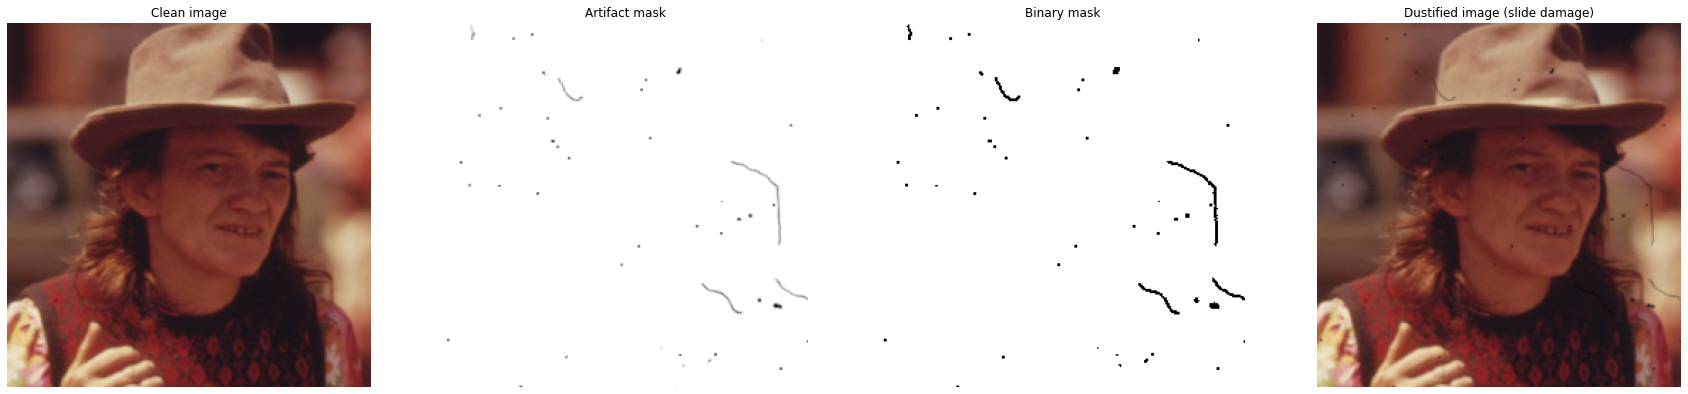

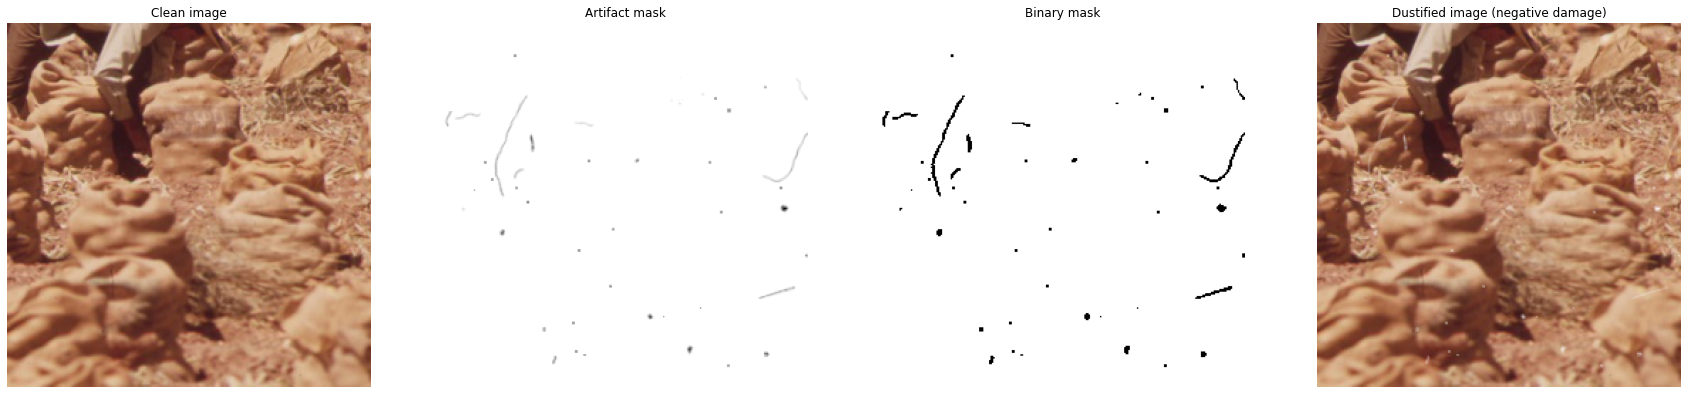

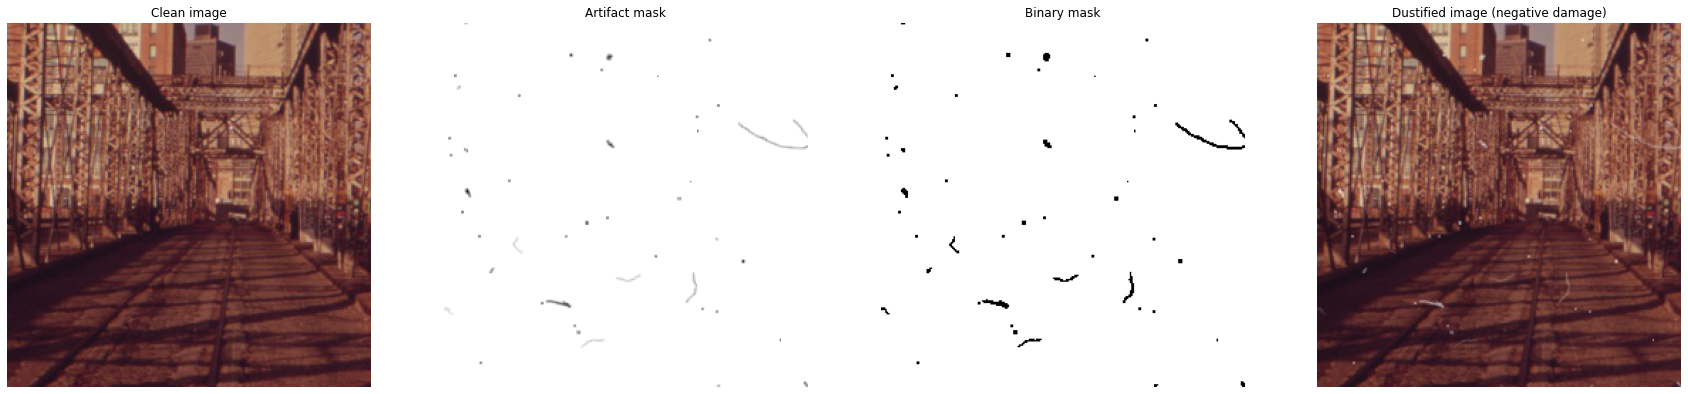

In [ ]:
plot_sample_ds(dds_train, 3)